In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Google Drive 연결


Mounted at /content/drive


In [ ]:
!pip install rasterio matplotlib

import numpy as np
import rasterio
import matplotlib.pyplot as plt
import heapq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 65.3 MB/s eta 0:00:00


In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom, gaussian_filter

def process_geotiff(file_path, target_shape=(279, 558), threshold=15, cost_increase=50, kernel_size=10, blur_sigma=2):
    """
    GeoTIFF 파일, 타겟 크기(SAR data size)로 변환
    축소된 데이터에 Gaussian 필터를 적용하여 Threshold 주변에 Cost를 추가하고 0~1로 정규화
    추가적으로 전체 데이터를 Gaussian Blur로 부드럽게 처리

    Parameters:
        file_path (str): GeoTIFF 파일 경로
        target_shape (tuple): 변환할 타겟 크기 (rows, columns)
        threshold (float): Cost를 추가할 기준 Threshold 값
        cost_increase (float): Threshold 주변에 추가할 Cost 값
        kernel_size (int): Threshold 주변 확장을 위한 Gaussian 커널 크기
        blur_sigma (float): 최종 데이터에 Gaussian Blur를 적용하기 위한 표준 편차

    Returns:
        normalized_data (numpy.ndarray): 0~1로 정규화된 최종 데이터()
    """
    # GeoTIFF 파일 열기 및 데이터 읽기
    with rasterio.open(file_path) as src:
        data = src.read(1)  # 첫 번째 밴드 읽기
        rev_data = data * -1 + 255  # 데이터 반전 및 조정

        # 1 이하 값은 0, 20 초과 값은 10으로 설정
        processed_data = np.where(rev_data <= 1, 0, 10)

    # 원본 데이터 크기 확인
    original_shape = processed_data.shape
    print(f"Original Shape: {original_shape}")
    print(f"Target Shape: {target_shape}")

    # 축소 비율 계산
    scale_factors = (target_shape[0] / original_shape[0], target_shape[1] / original_shape[1])

    # 데이터를 타겟 크기로 축소
    resized_data = zoom(processed_data, scale_factors, order=1)  # order=1: Bilinear Interpolation

    # 축소된 데이터에서 Threshold 기반 Mask 생성
    mask = resized_data >= threshold

    # Gaussian 필터를 적용하여 Mask 확장
    expanded_mask = gaussian_filter(mask.astype(float), sigma=kernel_size)

    # Cost 추가
    cost_map = expanded_mask * cost_increase
    final_data = resized_data + cost_map

    # Gaussian Blur 적용
    blurred_data = gaussian_filter(final_data, sigma=blur_sigma)

    # 최종 데이터 크기 확인
    print(f"Final Data Shape: {blurred_data.shape}")

    # 0~1 사이로 정규화
    min_val = blurred_data.min()
    max_val = blurred_data.max()
    print(f"Normalization Range: min={min_val}, max={max_val}")
    normalized_data = (blurred_data - min_val) / (max_val - min_val)

    return normalized_data


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Original Shape: (930, 1504)
Target Shape: (279, 558)
Final Data Shape: (279, 558)
Normalization Range: min=0.0, max=26.859066669562278


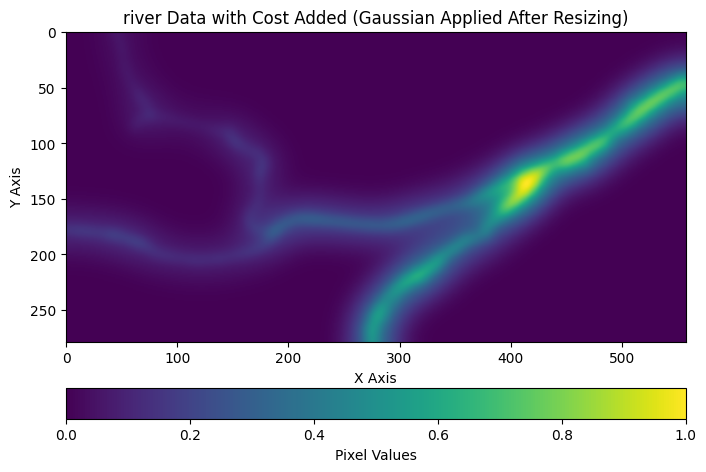

In [ ]:

file_path = '/content/drive/My Drive/EarthEngineExports/river.tif'
target_shape = (279, 558)

river_data = process_geotiff(
    file_path,
    target_shape=target_shape,
    threshold=5,
    cost_increase=50,
    kernel_size=15,
    blur_sigma=5  # Gaussian Blur 강도 설정
)

plt.figure(figsize=(8, 6))
plt.title("river Data with Cost Added (Gaussian Applied After Resizing)")
plt.imshow(river_data, cmap='viridis')
plt.colorbar(label="Pixel Values", orientation='horizontal', pad=0.1)
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.show()


Original Shape: (930, 1504)
Target Shape: (279, 558)
Final Data Shape: (279, 558)
Normalization Range: min=0.0, max=10.331719779268177
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


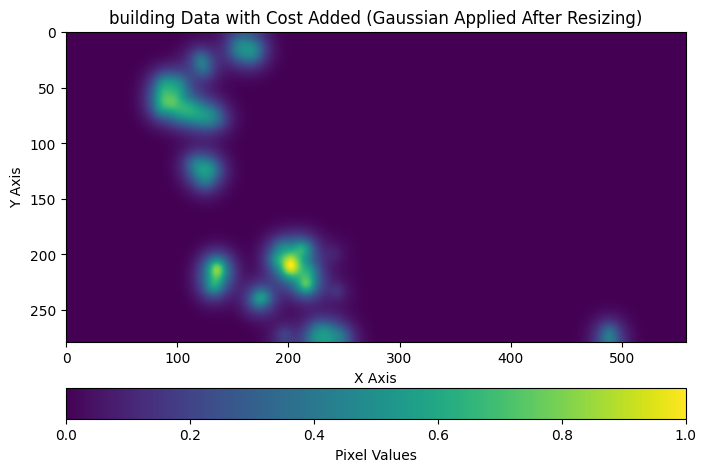

In [ ]:

file_path = '/content/drive/My Drive/EarthEngineExports/building.tif'
target_shape = (279, 558)

building_data = process_geotiff(
    file_path,
    target_shape=target_shape,
    threshold=5,
    cost_increase=50,
    kernel_size=10,
    blur_sigma=5  # Gaussian Blur 강도 설정
)
threshold = 0.1
mask = building_data >= threshold

cost_increase = 10  # 추가할 cost 값
kernel_size = 5  # 커널 크기
expanded_mask = gaussian_filter(mask.astype(float), sigma=kernel_size)

# 주변 영역에 cost 추가
mask_heatmap = building_data + cost_increase * expanded_mask
print(mask)

plt.figure(figsize=(8, 6))
plt.title("building Data with Cost Added (Gaussian Applied After Resizing)")
plt.imshow(building_data, cmap='viridis')
plt.colorbar(label="Pixel Values", orientation='horizontal', pad=0.1)
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.show()


Original Shape: (930, 1504)
Target Shape: (279, 558)
Final Data Shape: (279, 558)
Normalization Range: min=0.0, max=59.93337575111609


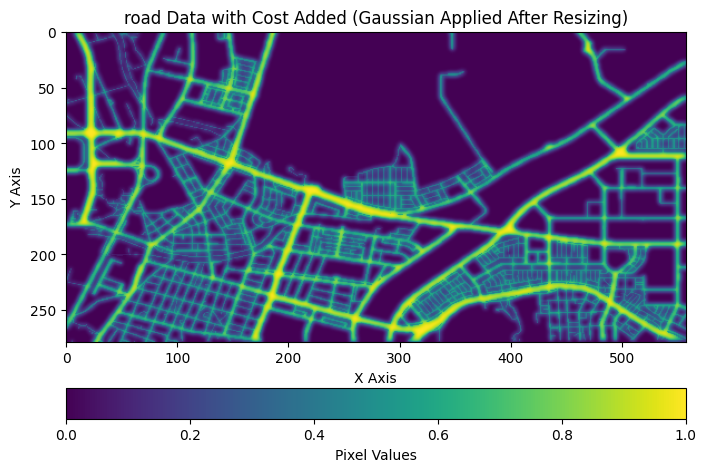

In [ ]:

file_path = '/content/drive/My Drive/EarthEngineExports/road.tif'
target_shape = (279, 558)

road_data = process_geotiff(
    file_path,
    target_shape=target_shape,
    threshold=5,
    cost_increase=50,
    kernel_size=2,
    blur_sigma=0  # Gaussian Blur 강도 설정
)

plt.figure(figsize=(8, 6))
plt.title("road Data with Cost Added (Gaussian Applied After Resizing)")
plt.imshow(road_data, cmap='viridis')
plt.colorbar(label="Pixel Values", orientation='horizontal', pad=0.1)
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.show()


## 히트맵 로드

In [ ]:
# GeoTIFF 파일 경로 (Google Drive에 저장된 파일 경로 입력)
tif_path = '/content/drive/My Drive/EarthEngineExports/BuildingDensityHeatmap1_f.tif'


In [ ]:
with rasterio.open(tif_path) as src:
    # 이미지 크기 확인
    width = src.width  # 열의 개수 (X 방향)
    height = src.height  # 행의 개수 (Y 방향)
    crs = src.crs  # 좌표계 정보
    transform = src.transform  # 변환 정보 (픽셀 크기, 기하학적 변환 등)

    print(f"Width (columns): {width}")
    print(f"Height (rows): {height}")
    print(f"CRS: {crs}")
    print(f"Transform: {transform}")

Width (columns): 558
Height (rows): 279
CRS: EPSG:4326
Transform: | 0.00, 0.00, 127.32|
| 0.00,-0.00, 36.38|
| 0.00, 0.00, 1.00|


In [ ]:
# GeoTIFF 파일 읽기
with rasterio.open(tif_path) as src:
    pixel_size = src.res  # (가로 크기, 세로 크기)
    print(f"Pixel Size: {pixel_size} meters")

# 예: Pixel Size: (10.0, 10.0)


Pixel Size: (8.983152841195215e-05, 8.983152841195215e-05) meters


## 히트맵

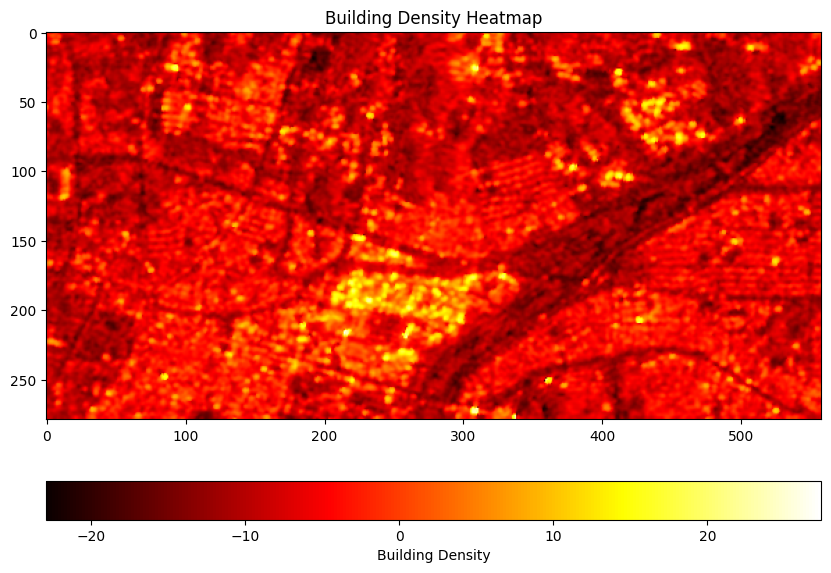

In [ ]:
# GeoTIFF 파일 경로 (Google Drive에 저장된 파일 경로 입력)
tif_path = '/content/drive/My Drive/EarthEngineExports/BuildingDensityHeatmap_final.tif'

# GeoTIFF 파일 로드
with rasterio.open(tif_path) as src:
    heatmap = src.read(1)  # 첫 번째 밴드 로드
    transform = src.transform  # GeoTIFF 좌표 변환 정보

# 히트맵 시각화
plt.figure(figsize=(10, 8))
plt.imshow(heatmap, cmap='hot')
plt.colorbar(label='Building Density', orientation='horizontal', pad=0.1)
plt.title('Building Density Heatmap')
plt.show()

Heatmap Size after Adding Cost: (279, 558)


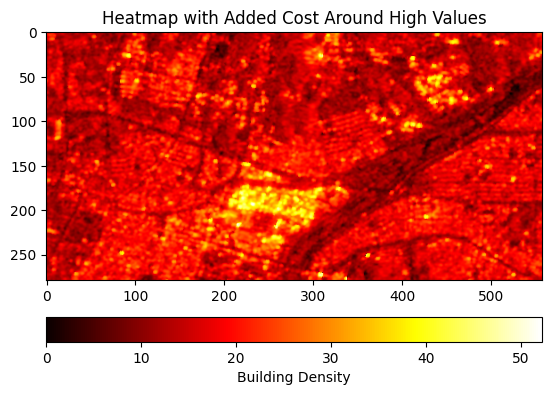

In [ ]:
from scipy.ndimage import gaussian_filter

# threshold 부분 근처에 cost 추가
threshold = 5
mask = heatmap >= threshold

cost_increase = 10  # 추가할 cost 값
kernel_size = 10  # 커널 크기
expanded_mask = gaussian_filter(mask.astype(float), sigma=kernel_size)

# 주변 영역에 cost 추가
mask_heatmap = heatmap + cost_increase * expanded_mask

# 매우 중요한 양수화
plus_heatmap = mask_heatmap + abs(mask_heatmap.min())
print(f"Heatmap Size after Adding Cost: {plus_heatmap.shape}")

# 시각화
plt.imshow(plus_heatmap, cmap='hot')
plt.colorbar(label='Building Density', orientation='horizontal', pad=0.1)
plt.title('Heatmap with Added Cost Around High Values')
plt.show()

Heatmap Size after Adding Cost: (279, 558)


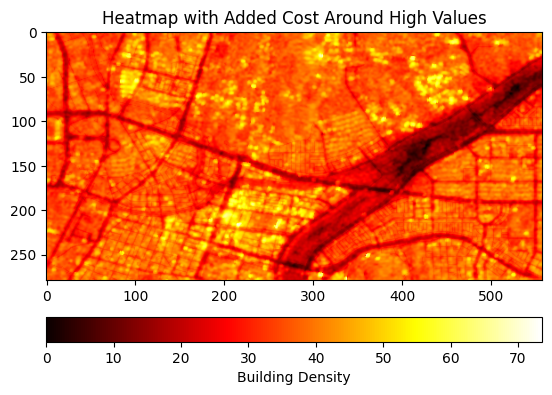

In [ ]:
final_heatmap = heatmap + (-30)*river_data + (-15)*road_data +(10)*building_data


final_heatmap += abs(final_heatmap.min())

print(f"Heatmap Size after Adding Cost: {final_heatmap.shape}")

# 시각화
plt.imshow(final_heatmap, cmap='hot')
plt.colorbar(label='Building Density', orientation='horizontal', pad=0.1)
plt.title('Heatmap with Added Cost Around High Values')
plt.show()

## a*

In [ ]:
from typing import List, Tuple, Callable
import math
import heapq

# 방향 벡터
d_row = (-1, 0, 1, 0)
d_col = (0, 1, 0, -1)
Coord = Tuple[int, int]

def get_euclidean_distance(pq1: Coord, pq2: Coord) -> float:
    p1, q1 = pq1
    p2, q2 = pq2

    return math.sqrt((p1 - p2) ** 2 + (q1 - q2) ** 2)

def is_vaild(
    matrix: List[List[bool]], vis: List[List[bool]], row: int, col: int
) -> bool:
    h = len(matrix)
    w = len(matrix[0])

    # out of bound 처리
    if not (0 <= row < h and 0 <= col < w):
        return False

    # 유효하지 않은 노드 처리
    if not matrix[row][col]:
        return False

    # 이미 방문한 노드 처리
    if vis[row][col]:
        return False

    return True


def a_star(
    matrix: List[List[int]], start: Coord, dest: Coord
) -> Tuple[int, List[Coord]]:
    global d_row
    global d_col

    h = len(matrix)
    w = len(matrix[0])

    # 휴리스틱 코스트 테이블
    heuristic_cost = [[float("inf")] * w for _ in range(h)]

    # 휴리스틱 코스트 구하기
    for i in range(h):
        for j in range(w):
            if matrix[i][j]:
                heuristic_cost[i][j] = round(get_euclidean_distance((i, j), dest))

    row, col = start
    dest_y, dest_x = dest

    vis = [[False] * w for _ in range(h)]

    heap = []
    heapq.heappush(heap, (heuristic_cost[row][col] + 0, row, col))

    total_cost = 0
    # 어떤 노드에서 어떤 노드로 이동하는지 저장할 리스트
    came_from = []

    """
    heap이 비거나 목적 지점에 도착할 때까지 반복:
        heap에서 cost가 최소인 값을 꺼내서 방문처리를 한 후,
        유효한 인접 노드가 있으면 코스트를 계산해 힙에 넣는다.
    """
    while heap and (row, col) != (dest_y, dest_x):
        total_cost, row, col = heapq.heappop(heap)

        # Total Cost 에서 휴리스틱 코스트를 빼면 시작 지점에서 현재 지점까지의 실제 거리를 구할 수 있음
        depth = total_cost - heuristic_cost[row][col]

        # 방문 처리
        vis[row][col] = True

        # 유효한 인접 노드가 있으면 코스트를 계산해 힙에 넣는다.
        for i in range(4):
            adjy = row + d_row[i]
            adjx = col + d_col[i]
            if is_vaild(matrix, vis, adjy, adjx):
                total_cost = heuristic_cost[adjy][adjx] + depth + 1
                came_from.append(((row, col), (adjy, adjx)))
                heapq.heappush(heap, (total_cost, adjy, adjx))

    # came_from을 역순으로 추적하여 최단 경로를 찾음
    from_y, from_x = came_from[-1][0]
    paths = []

    for i in range(len(came_from) - 1, -1, -1):
        from_coord, to_coord = came_from[i]
        to_y, to_x = to_coord

        if from_y == to_y and from_x == to_x:
            from_y, from_x = from_coord
            paths.insert(0, to_coord)

    return total_cost, paths, vis, heuristic_cost

In [ ]:
import matplotlib.pyplot as plt
from typing import List, Tuple
import math
import heapq

# 방향 벡터 (상, 우, 하, 좌)
d_row = (-1, 0, 1, 0)
d_col = (0, 1, 0, -1)
Coord = Tuple[int, int]

def get_euclidean_distance(pq1: Coord, pq2: Coord) -> float:
    p1, q1 = pq1
    p2, q2 = pq2
    return math.sqrt((p1 - p2) ** 2 + (q1 - q2) ** 2)

def is_valid(matrix: List[List[int]], vis: List[List[bool]], row: int, col: int) -> bool:
    h = len(matrix)
    w = len(matrix[0])

    # 범위를 벗어나거나 이미 방문한 노드라면 False
    if not (0 <= row < h and 0 <= col < w) or vis[row][col]:
        return False
    return True
def a_star_with_heatmap(
    matrix: List[List[int]], start: Coord, dest: Coord
) -> Tuple[int, List[Coord]]:
    global d_row, d_col

    h = len(matrix)
    w = len(matrix[0])

    # 휴리스틱 코스트 테이블
    heuristic_cost = [[float("inf")] * w for _ in range(h)]
    for i in range(h):
        for j in range(w):
            heuristic_cost[i][j] = get_euclidean_distance((i, j), dest)

    row, col = start
    dest_y, dest_x = dest

    vis = [[False] * w for _ in range(h)]

    heap = []
    heapq.heappush(heap, (heuristic_cost[row][col], row, col))

    came_from = {}
    total_cost = [[float("inf")] * w for _ in range(h)]
    total_cost[row][col] = 0

    # 실시간 시각화 초기화
    plt.ion()  # 인터랙티브 모드 활성화
    fig, ax = plt.subplots(figsize=(8, 8))

    while heap:
        curr_cost, row, col = heapq.heappop(heap)

        # 목표 지점에 도달한 경우
        if (row, col) == (dest_y, dest_x):
            print("Goal reached!")
            break

        vis[row][col] = True
        print(
          f"Current Node: ({row}, {col}), Total Cost: {curr_cost}, Heuristic Cost: {heuristic_cost[row][col]}")
        # 실시간 탐색 상태 시각화
        ax.clear()
        ax.imshow(matrix, cmap='hot', alpha=0.8)  # 히트맵
        vis_map = [[1 if vis[r][c] else 0 for c in range(w)] for r in range(h)]
        ax.imshow(vis_map, cmap='Blues', alpha=0.5)  # 방문 노드
        ax.scatter(col, row, c='red', label='Current Node')  # 현재 노드
        ax.scatter(dest_x, dest_y, c='green', label='Destination')  # 목표 노드
        ax.legend()
        ax.set_title('A* Pathfinding on Heatmap')
        plt.draw()
        plt.pause(0.1)

        # 유효한 인접 노드 탐색
        for i in range(4):
            adjy = row + d_row[i]
            adjx = col + d_col[i]

            if is_valid(matrix, vis, adjy, adjx):
                new_cost = total_cost[row][col] + matrix[adjy][adjx]
                if new_cost < total_cost[adjy][adjx]:
                    total_cost[adjy][adjx] = new_cost
                    priority = new_cost + heuristic_cost[adjy][adjx]
                    heapq.heappush(heap, (priority, adjy, adjx))
                    came_from[(adjy, adjx)] = (row, col)

    plt.ioff()  # 인터랙티브 모드 비활성화

    # 경로 재구성
    path = []
    curr = (dest_y, dest_x)
    while curr in came_from:
        path.append(curr)
        curr = came_from[curr]
    path.reverse()

    # 최적 경로 표시
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(matrix, cmap='hot', alpha=0.8)  # 히트맵
    for r, c in path:
        ax.text(c, r, 'x', ha='center', va='center', color='blue')  # 경로에 'x' 표시
    ax.set_title('Optimal Path on Heatmap')
    plt.show()

    return total_cost[dest_y][dest_x], path


Current Node: (10, 10), Total Cost: 42.42640687119285, Heuristic Cost: 42.42640687119285


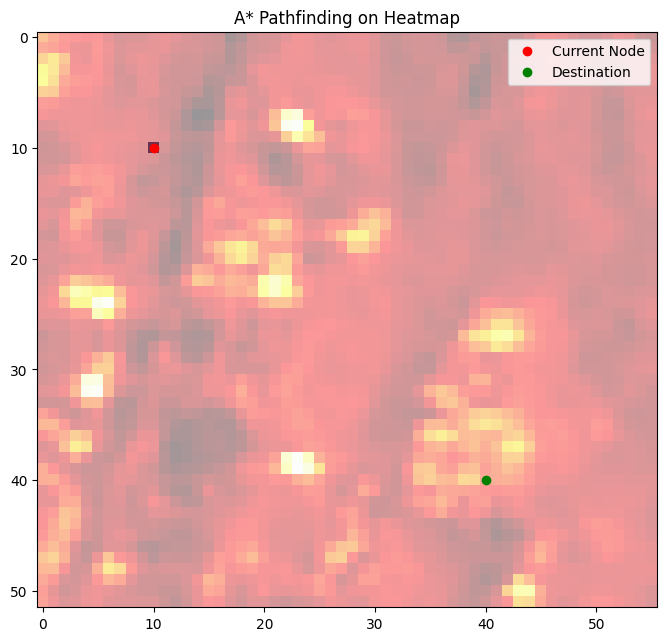

Current Node: (10, 11), Total Cost: 49.52401504731483, Heuristic Cost: 41.72529209005013


<Figure size 640x480 with 0 Axes>

Current Node: (11, 10), Total Cost: 49.982857226889486, Heuristic Cost: 41.72529209005013


<Figure size 640x480 with 0 Axes>

Current Node: (10, 9), Total Cost: 52.1608895591918, Heuristic Cost: 43.139309220245984


<Figure size 640x480 with 0 Axes>

Current Node: (9, 10), Total Cost: 52.57770922023617, Heuristic Cost: 43.139309220245984


<Figure size 640x480 with 0 Axes>

Current Node: (10, 12), Total Cost: 54.282481334761016, Heuristic Cost: 41.036569057366385


<Figure size 640x480 with 0 Axes>

Current Node: (11, 11), Total Cost: 55.15820717547471, Heuristic Cost: 41.012193308819754


<Figure size 640x480 with 0 Axes>

Current Node: (12, 10), Total Cost: 55.985911235929706, Heuristic Cost: 41.036569057366385


<Figure size 640x480 with 0 Axes>

Current Node: (10, 13), Total Cost: 57.94603942876152, Heuristic Cost: 40.36087214122113


<Figure size 640x480 with 0 Axes>

Current Node: (11, 12), Total Cost: 58.28660372342427, Heuristic Cost: 40.311288741492746


<Figure size 640x480 with 0 Axes>

Current Node: (9, 11), Total Cost: 59.055859881348354, Heuristic Cost: 42.44997055358225


<Figure size 640x480 with 0 Axes>

Current Node: (11, 9), Total Cost: 59.43191380956297, Heuristic Cost: 42.44997055358225


<Figure size 640x480 with 0 Axes>

Current Node: (11, 13), Total Cost: 60.734079370503, Heuristic Cost: 39.6232255123179


<Figure size 640x480 with 0 Axes>

Current Node: (12, 11), Total Cost: 60.83849244798549, Heuristic Cost: 40.311288741492746


<Figure size 640x480 with 0 Axes>

Current Node: (10, 14), Total Cost: 60.88549907584061, Heuristic Cost: 39.698866482558415


<Figure size 640x480 with 0 Axes>

Current Node: (13, 10), Total Cost: 61.11005955546508, Heuristic Cost: 40.36087214122113


<Figure size 640x480 with 0 Axes>

Current Node: (9, 12), Total Cost: 61.16036997299705, Heuristic Cost: 41.773197148410844


<Figure size 640x480 with 0 Axes>

Current Node: (9, 9), Total Cost: 62.65242043584605, Heuristic Cost: 43.840620433565945


<Figure size 640x480 with 0 Axes>

Current Node: (8, 10), Total Cost: 62.74818341137938, Heuristic Cost: 43.86342439892262


<Figure size 640x480 with 0 Axes>

Current Node: (10, 8), Total Cost: 62.782662831715385, Heuristic Cost: 43.86342439892262


<Figure size 640x480 with 0 Axes>

Current Node: (11, 14), Total Cost: 62.95259158586224, Heuristic Cost: 38.948684188300895


<Figure size 640x480 with 0 Axes>

Current Node: (12, 12), Total Cost: 63.09991895704396, Heuristic Cost: 39.59797974644666


<Figure size 640x480 with 0 Axes>

Current Node: (9, 13), Total Cost: 63.741946396595026, Heuristic Cost: 41.10960958218893


<Figure size 640x480 with 0 Axes>

Current Node: (12, 13), Total Cost: 64.09399041636331, Heuristic Cost: 38.897300677553446


<Figure size 640x480 with 0 Axes>

Current Node: (12, 9), Total Cost: 64.4143184051591, Heuristic Cost: 41.773197148410844


<Figure size 640x480 with 0 Axes>

Current Node: (10, 15), Total Cost: 64.90899212275474, Heuristic Cost: 39.05124837953327


<Figure size 640x480 with 0 Axes>

Current Node: (12, 14), Total Cost: 65.40314238900822, Heuristic Cost: 38.2099463490856


<Figure size 640x480 with 0 Axes>

Current Node: (9, 14), Total Cost: 66.27616117117432, Heuristic Cost: 40.45985664828782


<Figure size 640x480 with 0 Axes>

Current Node: (13, 11), Total Cost: 66.99700523243712, Heuristic Cost: 39.6232255123179


<Figure size 640x480 with 0 Axes>

Current Node: (13, 9), Total Cost: 67.1660162631224, Heuristic Cost: 41.10960958218893


<Figure size 640x480 with 0 Axes>

Current Node: (13, 13), Total Cost: 67.4836302792278, Heuristic Cost: 38.18376618407357


<Figure size 640x480 with 0 Axes>

Current Node: (8, 12), Total Cost: 67.50044849238887, Heuristic Cost: 42.5205832509386


<Figure size 640x480 with 0 Axes>

Current Node: (8, 13), Total Cost: 67.54091312308648, Heuristic Cost: 41.86884283091664


<Figure size 640x480 with 0 Axes>

Current Node: (14, 10), Total Cost: 67.54769493303004, Heuristic Cost: 39.698866482558415


<Figure size 640x480 with 0 Axes>

Current Node: (11, 15), Total Cost: 67.62753267871214, Heuristic Cost: 38.28837943815329


<Figure size 640x480 with 0 Axes>

Current Node: (8, 11), Total Cost: 67.77031830037947, Heuristic Cost: 43.18564576337837


<Figure size 640x480 with 0 Axes>

Current Node: (13, 12), Total Cost: 67.90223354186215, Heuristic Cost: 38.897300677553446


<Figure size 640x480 with 0 Axes>

Current Node: (13, 14), Total Cost: 68.13631729411742, Heuristic Cost: 37.48332962798263


<Figure size 640x480 with 0 Axes>

Current Node: (8, 14), Total Cost: 68.4282329367477, Heuristic Cost: 41.23105625617661


<Figure size 640x480 with 0 Axes>

Current Node: (8, 14), Total Cost: 68.57246716746437, Heuristic Cost: 41.23105625617661


<Figure size 640x480 with 0 Axes>

Current Node: (7, 14), Total Cost: 69.20907975577111, Heuristic Cost: 42.01190307520001


<Figure size 640x480 with 0 Axes>

Current Node: (7, 15), Total Cost: 69.07668044118883, Heuristic Cost: 41.400483088968905


<Figure size 640x480 with 0 Axes>

Current Node: (11, 8), Total Cost: 69.48419886424094, Heuristic Cost: 43.18564576337837


<Figure size 640x480 with 0 Axes>

Current Node: (14, 13), Total Cost: 69.60858335901722, Heuristic Cost: 37.48332962798263


<Figure size 640x480 with 0 Axes>

Current Node: (8, 15), Total Cost: 69.80204924354027, Heuristic Cost: 40.607881008493905


<Figure size 640x480 with 0 Axes>

Current Node: (9, 15), Total Cost: 70.8309322404693, Heuristic Cost: 39.824615503479755


<Figure size 640x480 with 0 Axes>

Current Node: (9, 15), Total Cost: 70.87237146080426, Heuristic Cost: 39.824615503479755


<Figure size 640x480 with 0 Axes>

Current Node: (12, 15), Total Cost: 71.07873906341189, Heuristic Cost: 37.53664875824692


<Figure size 640x480 with 0 Axes>

Current Node: (7, 13), Total Cost: 71.23700131618563, Heuristic Cost: 42.638011210655684


<Figure size 640x480 with 0 Axes>

Current Node: (14, 14), Total Cost: 71.75173301307294, Heuristic Cost: 36.76955262170047


<Figure size 640x480 with 0 Axes>

Current Node: (14, 12), Total Cost: 71.85054087296933, Heuristic Cost: 38.2099463490856


<Figure size 640x480 with 0 Axes>

Current Node: (6, 15), Total Cost: 72.04386063587108, Heuristic Cost: 42.20189569201838


<Figure size 640x480 with 0 Axes>

Current Node: (7, 10), Total Cost: 72.2906825888735, Heuristic Cost: 44.598206241955516


<Figure size 640x480 with 0 Axes>

Current Node: (6, 14), Total Cost: 72.4473660708528, Heuristic Cost: 42.80186911806539


<Figure size 640x480 with 0 Axes>

Current Node: (7, 16), Total Cost: 72.48981410367757, Heuristic Cost: 40.80441152620633


<Figure size 640x480 with 0 Axes>

Current Node: (15, 13), Total Cost: 72.91893785379914, Heuristic Cost: 36.796738985948195


<Figure size 640x480 with 0 Axes>

Current Node: (14, 9), Total Cost: 73.00864303671557, Heuristic Cost: 40.45985664828782


<Figure size 640x480 with 0 Axes>

Current Node: (8, 9), Total Cost: 73.27746252563261, Heuristic Cost: 44.553338819890925


<Figure size 640x480 with 0 Axes>

Current Node: (10, 7), Total Cost: 73.63705459061197, Heuristic Cost: 44.598206241955516


<Figure size 640x480 with 0 Axes>

Current Node: (14, 11), Total Cost: 73.87961038656273, Heuristic Cost: 38.948684188300895


<Figure size 640x480 with 0 Axes>

Current Node: (10, 16), Total Cost: 73.91923212638389, Heuristic Cost: 38.41874542459709


<Figure size 640x480 with 0 Axes>

Current Node: (13, 15), Total Cost: 74.0466869812371, Heuristic Cost: 36.796738985948195


<Figure size 640x480 with 0 Axes>

Current Node: (9, 8), Total Cost: 74.07334038224707, Heuristic Cost: 44.553338819890925


<Figure size 640x480 with 0 Axes>

Current Node: (15, 10), Total Cost: 74.36177056056738, Heuristic Cost: 39.05124837953327


<Figure size 640x480 with 0 Axes>

Current Node: (12, 8), Total Cost: 74.53567962084733, Heuristic Cost: 42.5205832509386


<Figure size 640x480 with 0 Axes>

Current Node: (7, 12), Total Cost: 74.55582090872532, Heuristic Cost: 43.278170016764804


<Figure size 640x480 with 0 Axes>

Current Node: (5, 15), Total Cost: 75.54052729469302, Heuristic Cost: 43.01162633521314


<Figure size 640x480 with 0 Axes>

Current Node: (13, 8), Total Cost: 75.57451383233531, Heuristic Cost: 41.86884283091664


<Figure size 640x480 with 0 Axes>

Current Node: (6, 16), Total Cost: 75.76166216999394, Heuristic Cost: 41.617304093369626


<Figure size 640x480 with 0 Axes>

Current Node: (7, 11), Total Cost: 75.98620666540175, Heuristic Cost: 43.93176527297759


<Figure size 640x480 with 0 Axes>

Current Node: (16, 13), Total Cost: 76.48849832000182, Heuristic Cost: 36.124783736376884


<Figure size 640x480 with 0 Axes>

Current Node: (8, 16), Total Cost: 76.51988063205147, Heuristic Cost: 40.0


<Figure size 640x480 with 0 Axes>

Current Node: (6, 13), Total Cost: 76.75788078465771, Heuristic Cost: 43.41658669218482


<Figure size 640x480 with 0 Axes>

Current Node: (11, 16), Total Cost: 77.08583960026144, Heuristic Cost: 37.64306044943742


<Figure size 640x480 with 0 Axes>

Current Node: (15, 12), Total Cost: 77.2530511982855, Heuristic Cost: 37.53664875824692


<Figure size 640x480 with 0 Axes>

Current Node: (15, 14), Total Cost: 78.16519314103434, Heuristic Cost: 36.069377593742864


<Figure size 640x480 with 0 Axes>

Current Node: (5, 14), Total Cost: 78.617735392398, Heuristic Cost: 43.60045871318328


<Figure size 640x480 with 0 Axes>

Current Node: (5, 16), Total Cost: 78.72742075173349, Heuristic Cost: 42.43819034784589


<Figure size 640x480 with 0 Axes>

Current Node: (14, 15), Total Cost: 79.46164471435753, Heuristic Cost: 36.069377593742864


<Figure size 640x480 with 0 Axes>

Current Node: (9, 16), Total Cost: 79.67256433396044, Heuristic Cost: 39.20459156782532


<Figure size 640x480 with 0 Axes>

Current Node: (17, 13), Total Cost: 79.89147578096268, Heuristic Cost: 35.4682957019364


<Figure size 640x480 with 0 Axes>

Current Node: (4, 15), Total Cost: 80.16425746424574, Heuristic Cost: 43.829214001622255


<Figure size 640x480 with 0 Axes>

Current Node: (11, 7), Total Cost: 80.25548213612865, Heuristic Cost: 43.93176527297759


<Figure size 640x480 with 0 Axes>

Current Node: (12, 16), Total Cost: 80.36558123970387, Heuristic Cost: 36.87817782917155


<Figure size 640x480 with 0 Axes>

Current Node: (15, 11), Total Cost: 80.47185328528695, Heuristic Cost: 38.28837943815329


<Figure size 640x480 with 0 Axes>

Current Node: (15, 9), Total Cost: 80.69438915361253, Heuristic Cost: 39.824615503479755


<Figure size 640x480 with 0 Axes>

Current Node: (7, 17), Total Cost: 81.33754261137565, Heuristic Cost: 40.22437072223753


<Figure size 640x480 with 0 Axes>

Current Node: (6, 10), Total Cost: 81.42968256990837, Heuristic Cost: 45.34313619501854


<Figure size 640x480 with 0 Axes>

Current Node: (14, 8), Total Cost: 81.70592695165813, Heuristic Cost: 41.23105625617661


<Figure size 640x480 with 0 Axes>

Current Node: (16, 10), Total Cost: 81.818739490781, Heuristic Cost: 38.41874542459709


<Figure size 640x480 with 0 Axes>

Current Node: (6, 12), Total Cost: 82.18330992561425, Heuristic Cost: 44.04543109109048


<Figure size 640x480 with 0 Axes>

Current Node: (13, 16), Total Cost: 82.64009331380547, Heuristic Cost: 36.124783736376884


<Figure size 640x480 with 0 Axes>

Current Node: (7, 9), Total Cost: 82.75892035985926, Heuristic Cost: 45.27692569068709


<Figure size 640x480 with 0 Axes>

Current Node: (16, 12), Total Cost: 83.01107556254073, Heuristic Cost: 36.87817782917155


<Figure size 640x480 with 0 Axes>

Current Node: (4, 16), Total Cost: 83.5537327512516, Heuristic Cost: 43.266615305567875


<Figure size 640x480 with 0 Axes>

Current Node: (10, 17), Total Cost: 83.56026824399473, Heuristic Cost: 37.8021163428716


<Figure size 640x480 with 0 Axes>

Current Node: (16, 14), Total Cost: 83.60797737427748, Heuristic Cost: 35.38361202590826


<Figure size 640x480 with 0 Axes>

Current Node: (16, 12), Total Cost: 83.65838770612707, Heuristic Cost: 36.87817782917155


<Figure size 640x480 with 0 Axes>

Current Node: (5, 13), Total Cost: 83.65926975674121, Heuristic Cost: 44.204072210600685


<Figure size 640x480 with 0 Axes>

Current Node: (18, 13), Total Cost: 83.74549609614259, Heuristic Cost: 34.828149534535996


<Figure size 640x480 with 0 Axes>

Current Node: (6, 11), Total Cost: 84.15461956572892, Heuristic Cost: 44.68780594300866


<Figure size 640x480 with 0 Axes>

Current Node: (8, 8), Total Cost: 84.29183765625186, Heuristic Cost: 45.254833995939045


<Figure size 640x480 with 0 Axes>

Current Node: (9, 7), Total Cost: 84.91271693014602, Heuristic Cost: 45.27692569068709


<Figure size 640x480 with 0 Axes>

Current Node: (10, 6), Total Cost: 85.0496068755709, Heuristic Cost: 45.34313619501854


<Figure size 640x480 with 0 Axes>

Current Node: (6, 17), Total Cost: 85.1560812627904, Heuristic Cost: 41.048751503547585


<Figure size 640x480 with 0 Axes>

Current Node: (17, 12), Total Cost: 85.40578086901527, Heuristic Cost: 36.235341863986875


<Figure size 640x480 with 0 Axes>

Current Node: (4, 14), Total Cost: 86.00542046898903, Heuristic Cost: 44.40720662234904


<Figure size 640x480 with 0 Axes>

Current Node: (3, 15), Total Cost: 86.26832109057472, Heuristic Cost: 44.654227123532216


<Figure size 640x480 with 0 Axes>

Current Node: (12, 7), Total Cost: 86.30512088724704, Heuristic Cost: 43.278170016764804


<Figure size 640x480 with 0 Axes>

Current Node: (18, 12), Total Cost: 86.74226774280203, Heuristic Cost: 35.608987629529715


<Figure size 640x480 with 0 Axes>

Current Node: (5, 17), Total Cost: 86.7555759252482, Heuristic Cost: 41.88078318274385


<Figure size 640x480 with 0 Axes>

Current Node: (13, 7), Total Cost: 87.12967301295973, Heuristic Cost: 42.638011210655684


<Figure size 640x480 with 0 Axes>

Current Node: (11, 17), Total Cost: 87.1636031208042, Heuristic Cost: 37.013511046643494


<Figure size 640x480 with 0 Axes>

Current Node: (19, 12), Total Cost: 87.73601119072549, Heuristic Cost: 35.0


<Figure size 640x480 with 0 Axes>

Current Node: (17, 14), Total Cost: 87.83332694378632, Heuristic Cost: 34.713109915419565


<Figure size 640x480 with 0 Axes>

Current Node: (16, 11), Total Cost: 87.98599176390974, Heuristic Cost: 37.64306044943742


<Figure size 640x480 with 0 Axes>

Current Node: (8, 17), Total Cost: 88.27586864103638, Heuristic Cost: 39.408120990476064


<Figure size 640x480 with 0 Axes>

Current Node: (19, 13), Total Cost: 88.36494108821263, Heuristic Cost: 34.20526275297414


<Figure size 640x480 with 0 Axes>

Current Node: (16, 9), Total Cost: 88.60961856897197, Heuristic Cost: 39.20459156782532


<Figure size 640x480 with 0 Axes>

Current Node: (4, 17), Total Cost: 88.77695536689438, Heuristic Cost: 42.720018726587654


<Figure size 640x480 with 0 Axes>

Current Node: (14, 16), Total Cost: 89.10036460437875, Heuristic Cost: 35.38361202590826


<Figure size 640x480 with 0 Axes>

Current Node: (3, 16), Total Cost: 89.34769057740723, Heuristic Cost: 44.10215414239989


<Figure size 640x480 with 0 Axes>

Current Node: (20, 12), Total Cost: 89.44136989352555, Heuristic Cost: 34.40930106817051


<Figure size 640x480 with 0 Axes>

Current Node: (17, 10), Total Cost: 89.87733934495981, Heuristic Cost: 37.8021163428716


<Figure size 640x480 with 0 Axes>

Current Node: (5, 12), Total Cost: 89.9811861402637, Heuristic Cost: 44.82186966202994


<Figure size 640x480 with 0 Axes>

Current Node: (15, 8), Total Cost: 90.02095446001593, Heuristic Cost: 40.607881008493905


<Figure size 640x480 with 0 Axes>

Current Node: (15, 15), Total Cost: 90.04389560909085, Heuristic Cost: 35.35533905932738


<Figure size 640x480 with 0 Axes>

Current Node: (7, 18), Total Cost: 90.2554278840743, Heuristic Cost: 39.66106403010388


<Figure size 640x480 with 0 Axes>

Current Node: (15, 8), Total Cost: 90.41585741466719, Heuristic Cost: 40.607881008493905


<Figure size 640x480 with 0 Axes>

Current Node: (12, 17), Total Cost: 91.2270193157872, Heuristic Cost: 36.235341863986875


<Figure size 640x480 with 0 Axes>

Current Node: (6, 9), Total Cost: 91.25535471490103, Heuristic Cost: 46.010868281309364


<Figure size 640x480 with 0 Axes>

Current Node: (9, 17), Total Cost: 91.32384726008472, Heuristic Cost: 38.600518131237564


<Figure size 640x480 with 0 Axes>

Current Node: (4, 13), Total Cost: 91.39484191696255, Heuristic Cost: 45.0


<Figure size 640x480 with 0 Axes>

Current Node: (10, 18), Total Cost: 91.58327496230613, Heuristic Cost: 37.20215047547655


<Figure size 640x480 with 0 Axes>

Current Node: (11, 6), Total Cost: 91.6498691051597, Heuristic Cost: 44.68780594300866


<Figure size 640x480 with 0 Axes>

Current Node: (5, 10), Total Cost: 92.06092960015832, Heuristic Cost: 46.09772228646444


<Figure size 640x480 with 0 Axes>

Current Node: (18, 14), Total Cost: 92.13022624822963, Heuristic Cost: 34.058772731852805


<Figure size 640x480 with 0 Axes>

Current Node: (14, 7), Total Cost: 92.77664991432604, Heuristic Cost: 42.01190307520001


<Figure size 640x480 with 0 Axes>

Current Node: (5, 11), Total Cost: 92.80187072321233, Heuristic Cost: 45.45327270945405


<Figure size 640x480 with 0 Axes>

Current Node: (21, 12), Total Cost: 92.91284845345614, Heuristic Cost: 33.83784863137726


<Figure size 640x480 with 0 Axes>

Current Node: (19, 11), Total Cost: 93.06583640004789, Heuristic Cost: 35.805027579936315


<Figure size 640x480 with 0 Axes>

Current Node: (3, 17), Total Cost: 93.2283389082773, Heuristic Cost: 43.56604182158393


<Figure size 640x480 with 0 Axes>

Current Node: (2, 15), Total Cost: 93.29248719722308, Heuristic Cost: 45.48626166217664


<Figure size 640x480 with 0 Axes>

Current Node: (18, 11), Total Cost: 93.31519064617339, Heuristic Cost: 36.40054944640259


<Figure size 640x480 with 0 Axes>

Current Node: (20, 13), Total Cost: 93.45968130743535, Heuristic Cost: 33.60059523282288


<Figure size 640x480 with 0 Axes>

Current Node: (7, 8), Total Cost: 93.46018939098028, Heuristic Cost: 45.967379738244816


<Figure size 640x480 with 0 Axes>

Current Node: (13, 17), Total Cost: 93.5602129592157, Heuristic Cost: 35.4682957019364


<Figure size 640x480 with 0 Axes>

Current Node: (3, 14), Total Cost: 93.79762602047009, Heuristic Cost: 45.221676218380054


<Figure size 640x480 with 0 Axes>

Current Node: (20, 11), Total Cost: 93.90819423248396, Heuristic Cost: 35.22782990761707


<Figure size 640x480 with 0 Axes>

Current Node: (3, 17), Total Cost: 94.03973911357667, Heuristic Cost: 43.56604182158393


<Figure size 640x480 with 0 Axes>

Current Node: (17, 11), Total Cost: 94.3585717040215, Heuristic Cost: 37.013511046643494


<Figure size 640x480 with 0 Axes>

Current Node: (4, 18), Total Cost: 94.43122621106343, Heuristic Cost: 42.190046219457976


<Figure size 640x480 with 0 Axes>

Current Node: (8, 7), Total Cost: 94.88141360482581, Heuristic Cost: 45.967379738244816


<Figure size 640x480 with 0 Axes>

Current Node: (16, 15), Total Cost: 95.3448391742383, Heuristic Cost: 34.655446902326915


<Figure size 640x480 with 0 Axes>

Current Node: (6, 18), Total Cost: 95.56434230918461, Heuristic Cost: 40.496913462633174


<Figure size 640x480 with 0 Axes>

Current Node: (5, 18), Total Cost: 95.89906439652758, Heuristic Cost: 41.340053217188775


<Figure size 640x480 with 0 Axes>

Current Node: (11, 18), Total Cost: 96.06846408225472, Heuristic Cost: 36.40054944640259


<Figure size 640x480 with 0 Axes>

Current Node: (2, 16), Total Cost: 96.125959872685, Heuristic Cost: 44.94441010848846


<Figure size 640x480 with 0 Axes>

Current Node: (19, 14), Total Cost: 96.22962059671441, Heuristic Cost: 33.421549934136806


<Figure size 640x480 with 0 Axes>

Current Node: (9, 6), Total Cost: 96.4188701472983, Heuristic Cost: 46.010868281309364


<Figure size 640x480 with 0 Axes>

Current Node: (17, 9), Total Cost: 96.5531672175023, Heuristic Cost: 38.600518131237564


<Figure size 640x480 with 0 Axes>

Current Node: (21, 11), Total Cost: 96.85233480980116, Heuristic Cost: 34.66987164671943


<Figure size 640x480 with 0 Axes>

Current Node: (21, 11), Total Cost: 97.24697030701314, Heuristic Cost: 34.66987164671943


<Figure size 640x480 with 0 Axes>

Current Node: (10, 5), Total Cost: 97.31852717755456, Heuristic Cost: 46.09772228646444


<Figure size 640x480 with 0 Axes>

Current Node: (2, 17), Total Cost: 97.6124678169, Heuristic Cost: 44.41846462902562


<Figure size 640x480 with 0 Axes>

Current Node: (7, 19), Total Cost: 97.65870631905366, Heuristic Cost: 39.11521443121589


<Figure size 640x480 with 0 Axes>

Current Node: (4, 12), Total Cost: 97.66957107008366, Heuristic Cost: 45.60701700396552


<Figure size 640x480 with 0 Axes>

Current Node: (16, 8), Total Cost: 98.08518376893127, Heuristic Cost: 40.0


<Figure size 640x480 with 0 Axes>

Current Node: (18, 10), Total Cost: 98.09454062959833, Heuristic Cost: 37.20215047547655


<Figure size 640x480 with 0 Axes>

Current Node: (8, 18), Total Cost: 98.28991069853126, Heuristic Cost: 38.8329756778952


<Figure size 640x480 with 0 Axes>

Current Node: (10, 19), Total Cost: 98.63230944514612, Heuristic Cost: 36.61966684720111


<Figure size 640x480 with 0 Axes>

Current Node: (3, 18), Total Cost: 98.72415217844372, Heuristic Cost: 43.04648650006177


<Figure size 640x480 with 0 Axes>

Current Node: (17, 15), Total Cost: 98.7995493700463, Heuristic Cost: 33.97057550292606


<Figure size 640x480 with 0 Axes>

Current Node: (14, 17), Total Cost: 99.08832183831653, Heuristic Cost: 34.713109915419565


<Figure size 640x480 with 0 Axes>

Current Node: (22, 12), Total Cost: 99.2541724670833, Heuristic Cost: 33.28663395418648


<Figure size 640x480 with 0 Axes>

Current Node: (3, 13), Total Cost: 99.28116599138224, Heuristic Cost: 45.803929962395145


<Figure size 640x480 with 0 Axes>

Current Node: (12, 6), Total Cost: 99.28280310186835, Heuristic Cost: 44.04543109109048


<Figure size 640x480 with 0 Axes>

Current Node: (21, 13), Total Cost: 100.46403456952729, Heuristic Cost: 33.015148038438355


<Figure size 640x480 with 0 Axes>

Current Node: (20, 14), Total Cost: 100.83014890103735, Heuristic Cost: 32.802438933713454


<Figure size 640x480 with 0 Axes>

Current Node: (6, 8), Total Cost: 100.90595720843066, Heuristic Cost: 46.69047011971501


<Figure size 640x480 with 0 Axes>

Current Node: (4, 11), Total Cost: 101.02927694387162, Heuristic Cost: 46.22769732530488


<Figure size 640x480 with 0 Axes>

Current Node: (9, 18), Total Cost: 101.07357320689354, Heuristic Cost: 38.01315561749642


<Figure size 640x480 with 0 Axes>

Current Node: (13, 6), Total Cost: 101.0839435122931, Heuristic Cost: 43.41658669218482


<Figure size 640x480 with 0 Axes>

Current Node: (1, 15), Total Cost: 101.20760148699276, Heuristic Cost: 46.32493928760188


<Figure size 640x480 with 0 Axes>

Current Node: (2, 14), Total Cost: 101.3079490198399, Heuristic Cost: 46.04345773288535


<Figure size 640x480 with 0 Axes>

Current Node: (5, 9), Total Cost: 101.50651525853222, Heuristic Cost: 46.75467891024384


<Figure size 640x480 with 0 Axes>

Current Node: (1, 17), Total Cost: 101.73921186058737, Heuristic Cost: 45.27692569068709


<Figure size 640x480 with 0 Axes>

Current Node: (15, 7), Total Cost: 101.77672748929032, Heuristic Cost: 41.400483088968905


<Figure size 640x480 with 0 Axes>

Current Node: (22, 11), Total Cost: 101.79704327901064, Heuristic Cost: 34.132096331752024


<Figure size 640x480 with 0 Axes>

Current Node: (20, 10), Total Cost: 102.141147928016, Heuristic Cost: 36.05551275463989


<Figure size 640x480 with 0 Axes>

Current Node: (19, 10), Total Cost: 102.32626015853137, Heuristic Cost: 36.61966684720111


<Figure size 640x480 with 0 Axes>

Current Node: (15, 16), Total Cost: 102.36801788301315, Heuristic Cost: 34.655446902326915


<Figure size 640x480 with 0 Axes>

Current Node: (2, 18), Total Cost: 102.37057061244536, Heuristic Cost: 43.9089968002003


<Figure size 640x480 with 0 Axes>

Current Node: (4, 19), Total Cost: 102.38661127191116, Heuristic Cost: 41.677331968349414


<Figure size 640x480 with 0 Axes>

Current Node: (12, 18), Total Cost: 102.53968160187668, Heuristic Cost: 35.608987629529715


<Figure size 640x480 with 0 Axes>

Current Node: (4, 10), Total Cost: 102.63206492068335, Heuristic Cost: 46.861498055439924


<Figure size 640x480 with 0 Axes>

Current Node: (18, 15), Total Cost: 103.16930598513122, Heuristic Cost: 33.301651610693426


<Figure size 640x480 with 0 Axes>

Current Node: (1, 16), Total Cost: 103.63717218102576, Heuristic Cost: 45.79301256742124


<Figure size 640x480 with 0 Axes>

Current Node: (11, 5), Total Cost: 103.7564021181947, Heuristic Cost: 45.45327270945405


<Figure size 640x480 with 0 Axes>

Current Node: (5, 19), Total Cost: 103.81746314372066, Heuristic Cost: 40.8166632639171


<Figure size 640x480 with 0 Axes>

Current Node: (7, 7), Total Cost: 103.81929457242182, Heuristic Cost: 46.66904755831214


<Figure size 640x480 with 0 Axes>

Current Node: (6, 19), Total Cost: 103.95794751673859, Heuristic Cost: 39.96248240537617


<Figure size 640x480 with 0 Axes>

Current Node: (10, 20), Total Cost: 104.00871682414262, Heuristic Cost: 36.05551275463989


<Figure size 640x480 with 0 Axes>

Current Node: (11, 19), Total Cost: 104.28256432125312, Heuristic Cost: 35.805027579936315


<Figure size 640x480 with 0 Axes>

Current Node: (0, 17), Total Cost: 104.39520693636143, Heuristic Cost: 46.14108798023731


<Figure size 640x480 with 0 Axes>

Current Node: (21, 10), Total Cost: 104.52823898802626, Heuristic Cost: 35.510561809129406


<Figure size 640x480 with 0 Axes>

Current Node: (17, 8), Total Cost: 105.34851458553592, Heuristic Cost: 39.408120990476064


<Figure size 640x480 with 0 Axes>

Current Node: (3, 12), Total Cost: 105.47395786017502, Heuristic Cost: 46.400431032480725


<Figure size 640x480 with 0 Axes>

Current Node: (8, 6), Total Cost: 105.56229465245863, Heuristic Cost: 46.69047011971501


<Figure size 640x480 with 0 Axes>

Current Node: (8, 19), Total Cost: 105.84918553277191, Heuristic Cost: 38.27531841800928


<Figure size 640x480 with 0 Axes>

Current Node: (1, 18), Total Cost: 106.10900423972137, Heuristic Cost: 44.77722635447622


<Figure size 640x480 with 0 Axes>

Current Node: (23, 12), Total Cost: 106.20203883197598, Heuristic Cost: 32.7566787083184


<Figure size 640x480 with 0 Axes>

Current Node: (18, 9), Total Cost: 106.20742340858652, Heuristic Cost: 38.01315561749642


<Figure size 640x480 with 0 Axes>

Current Node: (13, 18), Total Cost: 106.30291140885767, Heuristic Cost: 34.828149534535996


<Figure size 640x480 with 0 Axes>

Current Node: (14, 6), Total Cost: 106.73138718011575, Heuristic Cost: 42.80186911806539


<Figure size 640x480 with 0 Axes>

Current Node: (7, 20), Total Cost: 107.22434024625825, Heuristic Cost: 38.58756276314948


<Figure size 640x480 with 0 Axes>

Current Node: (0, 18), Total Cost: 107.30193984797349, Heuristic Cost: 45.65084884205331


<Figure size 640x480 with 0 Axes>

Current Node: (2, 13), Total Cost: 107.31243816593692, Heuristic Cost: 46.61544808322666


<Figure size 640x480 with 0 Axes>

Current Node: (16, 16), Total Cost: 107.39434755038153, Heuristic Cost: 33.94112549695428


<Figure size 640x480 with 0 Axes>

Current Node: (3, 19), Total Cost: 107.71146438763196, Heuristic Cost: 42.5440947723653


<Figure size 640x480 with 0 Axes>

Current Node: (9, 19), Total Cost: 107.80442011477918, Heuristic Cost: 37.44329045369811


<Figure size 640x480 with 0 Axes>

Current Node: (9, 5), Total Cost: 108.33238171664503, Heuristic Cost: 46.75467891024384


<Figure size 640x480 with 0 Axes>

Current Node: (17, 16), Total Cost: 108.68870650790109, Heuristic Cost: 33.24154027718932


<Figure size 640x480 with 0 Axes>

Current Node: (10, 21), Total Cost: 108.77461911370375, Heuristic Cost: 35.510561809129406


<Figure size 640x480 with 0 Axes>

Current Node: (16, 7), Total Cost: 108.79611189495282, Heuristic Cost: 40.80441152620633


<Figure size 640x480 with 0 Axes>

Current Node: (11, 20), Total Cost: 109.01484418182997, Heuristic Cost: 35.22782990761707


<Figure size 640x480 with 0 Axes>

Current Node: (23, 11), Total Cost: 109.02258757621762, Heuristic Cost: 33.61547262794322


<Figure size 640x480 with 0 Axes>

Current Node: (10, 4), Total Cost: 109.09014195363898, Heuristic Cost: 46.861498055439924


<Figure size 640x480 with 0 Axes>

Current Node: (0, 15), Total Cost: 109.24295292152104, Heuristic Cost: 47.16990566028302


<Figure size 640x480 with 0 Axes>

Current Node: (5, 8), Total Cost: 109.45326260441577, Heuristic Cost: 47.4236228055175


<Figure size 640x480 with 0 Axes>

Current Node: (1, 14), Total Cost: 109.69327222303517, Heuristic Cost: 46.87216658103186


<Figure size 640x480 with 0 Axes>

Current Node: (19, 15), Total Cost: 109.73852042919478, Heuristic Cost: 32.64965543462902


<Figure size 640x480 with 0 Axes>

Current Node: (2, 19), Total Cost: 109.77089559806478, Heuristic Cost: 43.41658669218482


<Figure size 640x480 with 0 Axes>

Current Node: (3, 11), Total Cost: 109.85669856364733, Heuristic Cost: 47.01063709417264


<Figure size 640x480 with 0 Axes>

Current Node: (15, 17), Total Cost: 109.9301147352204, Heuristic Cost: 33.97057550292606


<Figure size 640x480 with 0 Axes>

Current Node: (14, 18), Total Cost: 110.17138513535136, Heuristic Cost: 34.058772731852805


<Figure size 640x480 with 0 Axes>

Current Node: (6, 7), Total Cost: 110.2479386646821, Heuristic Cost: 47.38143096192854


<Figure size 640x480 with 0 Axes>

Current Node: (11, 21), Total Cost: 110.6792300184271, Heuristic Cost: 34.66987164671943


<Figure size 640x480 with 0 Axes>

Current Node: (20, 15), Total Cost: 110.96104463357221, Heuristic Cost: 32.01562118716424


<Figure size 640x480 with 0 Axes>

Current Node: (22, 13), Total Cost: 111.15876265166938, Heuristic Cost: 32.449961479175904


<Figure size 640x480 with 0 Axes>

Current Node: (0, 16), Total Cost: 111.17383672233835, Heuristic Cost: 46.647615158762406


<Figure size 640x480 with 0 Axes>

Current Node: (22, 10), Total Cost: 111.46873836709878, Heuristic Cost: 34.9857113690718


<Figure size 640x480 with 0 Axes>

Current Node: (4, 9), Total Cost: 112.05150830040071, Heuristic Cost: 47.50789408087881


<Figure size 640x480 with 0 Axes>

Current Node: (6, 20), Total Cost: 112.08521222236897, Heuristic Cost: 39.44616584663204


<Figure size 640x480 with 0 Axes>

Current Node: (24, 12), Total Cost: 112.34690836715569, Heuristic Cost: 32.2490309931942


<Figure size 640x480 with 0 Axes>

Current Node: (4, 20), Total Cost: 112.48098673997016, Heuristic Cost: 41.182520563948


<Figure size 640x480 with 0 Axes>

Current Node: (12, 19), Total Cost: 112.5492681631143, Heuristic Cost: 35.0


<Figure size 640x480 with 0 Axes>

Current Node: (5, 20), Total Cost: 112.57977305826634, Heuristic Cost: 40.311288741492746


<Figure size 640x480 with 0 Axes>

Current Node: (20, 9), Total Cost: 112.67005679463506, Heuristic Cost: 36.89173349139343


<Figure size 640x480 with 0 Axes>

Current Node: (1, 19), Total Cost: 112.78592293145766, Heuristic Cost: 44.294469180700204


<Figure size 640x480 with 0 Axes>

Current Node: (17, 7), Total Cost: 112.80472323907296, Heuristic Cost: 40.22437072223753


<Figure size 640x480 with 0 Axes>

Current Node: (12, 5), Total Cost: 112.89037287933901, Heuristic Cost: 44.82186966202994


<Figure size 640x480 with 0 Axes>

Current Node: (3, 10), Total Cost: 112.98985582960324, Heuristic Cost: 47.634021455258214


<Figure size 640x480 with 0 Axes>

Current Node: (9, 20), Total Cost: 113.26982942691524, Heuristic Cost: 36.89173349139343


<Figure size 640x480 with 0 Axes>

Current Node: (12, 21), Total Cost: 113.48085181667523, Heuristic Cost: 33.83784863137726


<Figure size 640x480 with 0 Axes>

Current Node: (19, 9), Total Cost: 113.49350995579726, Heuristic Cost: 37.44329045369811


<Figure size 640x480 with 0 Axes>

Current Node: (18, 8), Total Cost: 113.57822328887622, Heuristic Cost: 38.8329756778952


<Figure size 640x480 with 0 Axes>

Current Node: (0, 19), Total Cost: 113.67979843865493, Heuristic Cost: 45.17742799230607


<Figure size 640x480 with 0 Axes>

Current Node: (2, 12), Total Cost: 113.79880231243075, Heuristic Cost: 47.20169488482379


<Figure size 640x480 with 0 Axes>

Current Node: (11, 22), Total Cost: 114.11756435059563, Heuristic Cost: 34.132096331752024


<Figure size 640x480 with 0 Axes>

Current Node: (21, 9), Total Cost: 114.31064083895751, Heuristic Cost: 36.359317925395686


<Figure size 640x480 with 0 Axes>

Current Node: (7, 6), Total Cost: 114.53631256868539, Heuristic Cost: 47.38143096192854


<Figure size 640x480 with 0 Axes>

Current Node: (10, 22), Total Cost: 114.62660306045672, Heuristic Cost: 34.9857113690718


<Figure size 640x480 with 0 Axes>

Current Node: (15, 6), Total Cost: 114.71592813967303, Heuristic Cost: 42.20189569201838


<Figure size 640x480 with 0 Axes>

Current Node: (23, 13), Total Cost: 114.99983233110218, Heuristic Cost: 31.906112267087632


<Figure size 640x480 with 0 Axes>

Current Node: (21, 14), Total Cost: 115.05662026491385, Heuristic Cost: 32.202484376209235


<Figure size 640x480 with 0 Axes>

Current Node: (18, 16), Total Cost: 115.08847043344713, Heuristic Cost: 32.55764119219941


<Figure size 640x480 with 0 Axes>

Current Node: (12, 20), Total Cost: 115.17287565619162, Heuristic Cost: 34.40930106817051


<Figure size 640x480 with 0 Axes>

Current Node: (13, 5), Total Cost: 115.33091575769222, Heuristic Cost: 44.204072210600685


<Figure size 640x480 with 0 Axes>

Current Node: (11, 4), Total Cost: 115.5024034548687, Heuristic Cost: 46.22769732530488


<Figure size 640x480 with 0 Axes>

Current Node: (24, 11), Total Cost: 115.84356520755952, Heuristic Cost: 33.12099032335839


<Figure size 640x480 with 0 Axes>

Current Node: (1, 13), Total Cost: 116.01677046589438, Heuristic Cost: 47.43416490252569


<Figure size 640x480 with 0 Axes>

Current Node: (8, 20), Total Cost: 116.26390476321473, Heuristic Cost: 37.73592452822641


<Figure size 640x480 with 0 Axes>

Current Node: (8, 5), Total Cost: 116.65412310535507, Heuristic Cost: 47.4236228055175


<Figure size 640x480 with 0 Axes>

Current Node: (12, 22), Total Cost: 116.97598383053034, Heuristic Cost: 33.28663395418648


<Figure size 640x480 with 0 Axes>

Current Node: (0, 14), Total Cost: 117.44986887928214, Heuristic Cost: 47.70744176750625


<Figure size 640x480 with 0 Axes>

Current Node: (13, 19), Total Cost: 117.61647194363573, Heuristic Cost: 34.20526275297414


<Figure size 640x480 with 0 Axes>

Current Node: (4, 8), Total Cost: 117.75525635512878, Heuristic Cost: 48.16637831516918


<Figure size 640x480 with 0 Axes>

Current Node: (17, 17), Total Cost: 117.92085858261052, Heuristic Cost: 32.526911934581186


<Figure size 640x480 with 0 Axes>

Current Node: (2, 20), Total Cost: 118.0936509170578, Heuristic Cost: 42.941821107167776


<Figure size 640x480 with 0 Axes>

Current Node: (5, 7), Total Cost: 118.24393176952394, Heuristic Cost: 48.104053883222775


<Figure size 640x480 with 0 Axes>

Current Node: (3, 20), Total Cost: 118.27844354593822, Heuristic Cost: 42.05948168962618


<Figure size 640x480 with 0 Axes>

Current Node: (18, 7), Total Cost: 118.28991876513294, Heuristic Cost: 39.66106403010388


<Figure size 640x480 with 0 Axes>

Current Node: (16, 17), Total Cost: 118.29297538074354, Heuristic Cost: 33.24154027718932


<Figure size 640x480 with 0 Axes>

Current Node: (24, 13), Total Cost: 118.47844846600886, Heuristic Cost: 31.38470965295043


<Figure size 640x480 with 0 Axes>

Current Node: (13, 21), Total Cost: 118.62204754352909, Heuristic Cost: 33.015148038438355


<Figure size 640x480 with 0 Axes>

Current Node: (9, 21), Total Cost: 119.24680732440059, Heuristic Cost: 36.359317925395686


<Figure size 640x480 with 0 Axes>

Current Node: (10, 3), Total Cost: 119.3732280343213, Heuristic Cost: 47.634021455258214


<Figure size 640x480 with 0 Axes>

Current Node: (2, 11), Total Cost: 119.58792403152498, Heuristic Cost: 47.80167361086848


<Figure size 640x480 with 0 Axes>

Current Node: (16, 6), Total Cost: 119.61484751152538, Heuristic Cost: 41.617304093369626


<Figure size 640x480 with 0 Axes>

Current Node: (9, 4), Total Cost: 119.71683706157688, Heuristic Cost: 47.50789408087881


<Figure size 640x480 with 0 Axes>

Current Node: (23, 10), Total Cost: 119.81271122890314, Heuristic Cost: 34.48187929913333


<Figure size 640x480 with 0 Axes>

Current Node: (1, 20), Total Cost: 119.89255361413652, Heuristic Cost: 43.829214001622255


<Figure size 640x480 with 0 Axes>

Current Node: (15, 18), Total Cost: 119.99682088320405, Heuristic Cost: 33.301651610693426


<Figure size 640x480 with 0 Axes>

Current Node: (14, 5), Total Cost: 120.14297285396788, Heuristic Cost: 43.60045871318328


<Figure size 640x480 with 0 Axes>

Current Node: (25, 12), Total Cost: 120.19615958101822, Heuristic Cost: 31.76476034853718


<Figure size 640x480 with 0 Axes>

Current Node: (6, 6), Total Cost: 120.2262385441494, Heuristic Cost: 48.08326112068523


<Figure size 640x480 with 0 Axes>

Current Node: (17, 6), Total Cost: 120.3715180144068, Heuristic Cost: 41.048751503547585


<Figure size 640x480 with 0 Axes>

Current Node: (13, 22), Total Cost: 120.78256497935769, Heuristic Cost: 32.449961479175904


<Figure size 640x480 with 0 Axes>

Current Node: (0, 20), Total Cost: 121.06571849187318, Heuristic Cost: 44.721359549995796


<Figure size 640x480 with 0 Axes>

Current Node: (11, 23), Total Cost: 121.09145364643341, Heuristic Cost: 33.61547262794322


<Figure size 640x480 with 0 Axes>

Current Node: (22, 9), Total Cost: 122.07436888228602, Heuristic Cost: 35.84689665786984


<Figure size 640x480 with 0 Axes>

Current Node: (19, 8), Total Cost: 122.11967423275306, Heuristic Cost: 38.27531841800928


<Figure size 640x480 with 0 Axes>

Current Node: (14, 19), Total Cost: 122.15601434663203, Heuristic Cost: 33.421549934136806


<Figure size 640x480 with 0 Axes>

Current Node: (6, 21), Total Cost: 122.60611488259059, Heuristic Cost: 38.948684188300895


<Figure size 640x480 with 0 Axes>

Current Node: (12, 23), Total Cost: 122.74799936365864, Heuristic Cost: 32.7566787083184


<Figure size 640x480 with 0 Axes>

Current Node: (25, 11), Total Cost: 122.94559947484055, Heuristic Cost: 32.64965543462902


<Figure size 640x480 with 0 Axes>

Current Node: (13, 20), Total Cost: 122.98801292838513, Heuristic Cost: 33.60059523282288


<Figure size 640x480 with 0 Axes>

Current Node: (1, 12), Total Cost: 122.99373746619796, Heuristic Cost: 48.010415536631214


<Figure size 640x480 with 0 Axes>

Current Node: (3, 9), Total Cost: 122.99430768773777, Heuristic Cost: 48.27007354458868


<Figure size 640x480 with 0 Axes>

Current Node: (4, 21), Total Cost: 123.16631245308362, Heuristic Cost: 40.70626487409524


<Figure size 640x480 with 0 Axes>

Current Node: (5, 21), Total Cost: 123.23837758984999, Heuristic Cost: 39.824615503479755


<Figure size 640x480 with 0 Axes>

Current Node: (19, 8), Total Cost: 123.42464612387118, Heuristic Cost: 38.27531841800928


<Figure size 640x480 with 0 Axes>

Current Node: (7, 21), Total Cost: 123.47479737038095, Heuristic Cost: 38.07886552931954


<Figure size 640x480 with 0 Axes>

Current Node: (2, 10), Total Cost: 123.58231697089894, Heuristic Cost: 48.41487374764082


<Figure size 640x480 with 0 Axes>

Current Node: (20, 8), Total Cost: 123.80887598069782, Heuristic Cost: 37.73592452822641


<Figure size 640x480 with 0 Axes>

Current Node: (10, 23), Total Cost: 124.31001356641406, Heuristic Cost: 34.48187929913333


<Figure size 640x480 with 0 Axes>

Current Node: (25, 13), Total Cost: 124.34214589605016, Heuristic Cost: 30.886890422961002


<Figure size 640x480 with 0 Axes>

Current Node: (19, 7), Total Cost: 124.5224234220021, Heuristic Cost: 39.11521443121589


<Figure size 640x480 with 0 Axes>

Current Node: (21, 15), Total Cost: 124.68209961575187, Heuristic Cost: 31.400636936215164


<Figure size 640x480 with 0 Axes>

Current Node: (21, 8), Total Cost: 125.07545152183069, Heuristic Cost: 37.21558813185679


<Figure size 640x480 with 0 Axes>

Current Node: (18, 6), Total Cost: 125.26689737918832, Heuristic Cost: 40.496913462633174


<Figure size 640x480 with 0 Axes>

Current Node: (11, 3), Total Cost: 125.28941063216585, Heuristic Cost: 47.01063709417264


<Figure size 640x480 with 0 Axes>

Current Node: (0, 13), Total Cost: 125.29481023763546, Heuristic Cost: 48.25971404805462


<Figure size 640x480 with 0 Axes>

Current Node: (7, 5), Total Cost: 125.64637551605837, Heuristic Cost: 48.104053883222775


<Figure size 640x480 with 0 Axes>

Current Node: (20, 16), Total Cost: 125.69882711193, Heuristic Cost: 31.240998703626616


<Figure size 640x480 with 0 Axes>

Current Node: (24, 10), Total Cost: 125.83661461715542, Heuristic Cost: 34.0


<Figure size 640x480 with 0 Axes>

Current Node: (23, 14), Total Cost: 125.99519710751554, Heuristic Cost: 31.064449134018133


<Figure size 640x480 with 0 Axes>

Current Node: (13, 23), Total Cost: 126.23000461367852, Heuristic Cost: 31.906112267087632


<Figure size 640x480 with 0 Axes>

Current Node: (12, 4), Total Cost: 126.34652977871062, Heuristic Cost: 45.60701700396552


<Figure size 640x480 with 0 Axes>

Current Node: (4, 7), Total Cost: 126.48527012956552, Heuristic Cost: 48.83646178829912


<Figure size 640x480 with 0 Axes>

Current Node: (24, 14), Total Cost: 126.63888679765842, Heuristic Cost: 30.528675044947494


<Figure size 640x480 with 0 Axes>

Current Node: (19, 16), Total Cost: 126.96674838931631, Heuristic Cost: 31.89043743820395


<Figure size 640x480 with 0 Axes>

Current Node: (2, 21), Total Cost: 126.97616220830955, Heuristic Cost: 42.485291572496


<Figure size 640x480 with 0 Axes>

Current Node: (3, 8), Total Cost: 127.25604275969852, Heuristic Cost: 48.91829923454004


<Figure size 640x480 with 0 Axes>

Current Node: (26, 12), Total Cost: 127.53742650593003, Heuristic Cost: 31.304951684997057


<Figure size 640x480 with 0 Axes>

Current Node: (1, 21), Total Cost: 127.9027018684734, Heuristic Cost: 43.382023926967726


<Figure size 640x480 with 0 Axes>

Current Node: (8, 4), Total Cost: 127.97106035099922, Heuristic Cost: 48.16637831516918


<Figure size 640x480 with 0 Axes>

Current Node: (10, 2), Total Cost: 128.09793731691806, Heuristic Cost: 48.41487374764082


<Figure size 640x480 with 0 Axes>

Current Node: (18, 17), Total Cost: 128.26727938825252, Heuristic Cost: 31.827660925679098


<Figure size 640x480 with 0 Axes>

Current Node: (5, 6), Total Cost: 128.3429995195646, Heuristic Cost: 48.79549159502341


<Figure size 640x480 with 0 Axes>

Current Node: (14, 22), Total Cost: 128.40257815086312, Heuristic Cost: 31.622776601683793


<Figure size 640x480 with 0 Axes>

Current Node: (14, 21), Total Cost: 128.452942710518, Heuristic Cost: 32.202484376209235


<Figure size 640x480 with 0 Axes>

Current Node: (3, 21), Total Cost: 128.51426135922327, Heuristic Cost: 41.593268686170845


<Figure size 640x480 with 0 Axes>

Current Node: (0, 21), Total Cost: 128.57186360185324, Heuristic Cost: 44.28317965096906


<Figure size 640x480 with 0 Axes>

Current Node: (15, 5), Total Cost: 128.70251039155085, Heuristic Cost: 43.01162633521314


<Figure size 640x480 with 0 Axes>

Current Node: (26, 13), Total Cost: 128.70713296373182, Heuristic Cost: 30.4138126514911


<Figure size 640x480 with 0 Axes>

Current Node: (22, 14), Total Cost: 128.73529573357465, Heuristic Cost: 31.622776601683793


<Figure size 640x480 with 0 Axes>

Current Node: (13, 4), Total Cost: 128.86069090333845, Heuristic Cost: 45.0


<Figure size 640x480 with 0 Axes>

Current Node: (17, 18), Total Cost: 129.11923578133496, Heuristic Cost: 31.827660925679098


<Figure size 640x480 with 0 Axes>

Current Node: (26, 11), Total Cost: 129.31545979514058, Heuristic Cost: 32.202484376209235


<Figure size 640x480 with 0 Axes>

Current Node: (17, 5), Total Cost: 130.06064019464355, Heuristic Cost: 41.88078318274385


<Figure size 640x480 with 0 Axes>

Current Node: (25, 14), Total Cost: 130.28586062694396, Heuristic Cost: 30.01666203960727


<Figure size 640x480 with 0 Axes>

Current Node: (11, 24), Total Cost: 130.30844035262638, Heuristic Cost: 33.12099032335839


<Figure size 640x480 with 0 Axes>

Current Node: (9, 3), Total Cost: 130.3640174243609, Heuristic Cost: 48.27007354458868


<Figure size 640x480 with 0 Axes>

Current Node: (1, 11), Total Cost: 130.4444692762865, Heuristic Cost: 48.60041152089147


<Figure size 640x480 with 0 Axes>

Current Node: (15, 19), Total Cost: 130.6983411897102, Heuristic Cost: 32.64965543462902


<Figure size 640x480 with 0 Axes>

Current Node: (16, 18), Total Cost: 130.73388946392842, Heuristic Cost: 32.55764119219941


<Figure size 640x480 with 0 Axes>

Current Node: (23, 9), Total Cost: 131.18813864227639, Heuristic Cost: 35.35533905932738


<Figure size 640x480 with 0 Axes>

Current Node: (6, 5), Total Cost: 131.2893201119063, Heuristic Cost: 48.79549159502341


<Figure size 640x480 with 0 Axes>

Current Node: (12, 24), Total Cost: 131.5242129329253, Heuristic Cost: 32.2490309931942


<Figure size 640x480 with 0 Axes>

Current Node: (16, 5), Total Cost: 131.53545358969563, Heuristic Cost: 42.43819034784589


<Figure size 640x480 with 0 Axes>

Current Node: (14, 4), Total Cost: 131.5513515842154, Heuristic Cost: 44.40720662234904


<Figure size 640x480 with 0 Axes>

Current Node: (27, 13), Total Cost: 131.6926722259382, Heuristic Cost: 29.966648127543394


<Figure size 640x480 with 0 Axes>

Current Node: (26, 14), Total Cost: 131.77953133512378, Heuristic Cost: 29.5296461204668


<Figure size 640x480 with 0 Axes>

Current Node: (19, 6), Total Cost: 132.1075918741828, Heuristic Cost: 39.96248240537617


<Figure size 640x480 with 0 Axes>

Current Node: (27, 12), Total Cost: 132.2450655190142, Heuristic Cost: 30.870698080866262


<Figure size 640x480 with 0 Axes>

Current Node: (25, 10), Total Cost: 132.27934252993018, Heuristic Cost: 33.54101966249684


<Figure size 640x480 with 0 Axes>

Current Node: (22, 8), Total Cost: 132.56397947687935, Heuristic Cost: 36.71511950137164


<Figure size 640x480 with 0 Axes>

Current Node: (19, 6), Total Cost: 132.74481694841384, Heuristic Cost: 39.96248240537617


<Figure size 640x480 with 0 Axes>

Current Node: (20, 7), Total Cost: 132.92652765970206, Heuristic Cost: 38.58756276314948


<Figure size 640x480 with 0 Axes>

Current Node: (0, 12), Total Cost: 133.32606733772946, Heuristic Cost: 48.82622246293481


<Figure size 640x480 with 0 Axes>

Current Node: (11, 2), Total Cost: 133.40469474876852, Heuristic Cost: 47.80167361086848


<Figure size 640x480 with 0 Axes>

Current Node: (4, 22), Total Cost: 133.41489686991542, Heuristic Cost: 40.24922359499622


<Figure size 640x480 with 0 Axes>

Current Node: (8, 21), Total Cost: 133.4401302727553, Heuristic Cost: 37.21558813185679


<Figure size 640x480 with 0 Axes>

Current Node: (14, 23), Total Cost: 133.4613912429128, Heuristic Cost: 31.064449134018133


<Figure size 640x480 with 0 Axes>

Current Node: (14, 20), Total Cost: 133.57104770068358, Heuristic Cost: 32.802438933713454


<Figure size 640x480 with 0 Axes>

Current Node: (20, 7), Total Cost: 133.59227012138723, Heuristic Cost: 38.58756276314948


<Figure size 640x480 with 0 Axes>

Current Node: (27, 14), Total Cost: 133.70650007323297, Heuristic Cost: 29.068883707497267


<Figure size 640x480 with 0 Axes>

Current Node: (5, 22), Total Cost: 133.90647592255004, Heuristic Cost: 39.35733730830886


<Figure size 640x480 with 0 Axes>

Current Node: (1, 10), Total Cost: 133.98085673837727, Heuristic Cost: 49.20365840057018


<Figure size 640x480 with 0 Axes>

Current Node: (2, 9), Total Cost: 134.23644885078244, Heuristic Cost: 49.040799340956916


<Figure size 640x480 with 0 Axes>

Current Node: (6, 22), Total Cost: 134.2919623761971, Heuristic Cost: 38.47076812334269


<Figure size 640x480 with 0 Axes>

Current Node: (9, 22), Total Cost: 134.49889499856374, Heuristic Cost: 35.84689665786984


<Figure size 640x480 with 0 Axes>

Current Node: (27, 11), Total Cost: 134.51036961724253, Heuristic Cost: 31.78049716414141


<Figure size 640x480 with 0 Axes>

Current Node: (18, 5), Total Cost: 134.81644341323286, Heuristic Cost: 41.340053217188775


<Figure size 640x480 with 0 Axes>

Current Node: (3, 7), Total Cost: 134.90164258700628, Heuristic Cost: 49.57822102496216


<Figure size 640x480 with 0 Axes>

Current Node: (13, 24), Total Cost: 135.02632583556422, Heuristic Cost: 31.38470965295043


<Figure size 640x480 with 0 Axes>

Current Node: (28, 13), Total Cost: 135.10612060298783, Heuristic Cost: 29.546573405388315


<Figure size 640x480 with 0 Axes>

Current Node: (10, 1), Total Cost: 135.68822786314738, Heuristic Cost: 49.20365840057018


<Figure size 640x480 with 0 Axes>

Current Node: (24, 15), Total Cost: 135.89299830059423, Heuristic Cost: 29.68164415931166


<Figure size 640x480 with 0 Axes>

Current Node: (26, 10), Total Cost: 136.08362042651243, Heuristic Cost: 33.1058907144937


<Figure size 640x480 with 0 Axes>

Current Node: (26, 15), Total Cost: 136.17832192559536, Heuristic Cost: 28.653097563788805


<Figure size 640x480 with 0 Axes>

Current Node: (21, 7), Total Cost: 136.22405472959403, Heuristic Cost: 38.07886552931954


<Figure size 640x480 with 0 Axes>

Current Node: (21, 16), Total Cost: 136.26632303680012, Heuristic Cost: 30.610455730027933


<Figure size 640x480 with 0 Axes>

Current Node: (27, 15), Total Cost: 136.2704816835357, Heuristic Cost: 28.178005607210743


<Figure size 640x480 with 0 Axes>

Current Node: (28, 14), Total Cost: 136.50951831277646, Heuristic Cost: 28.635642126552707


<Figure size 640x480 with 0 Axes>

Current Node: (7, 4), Total Cost: 136.88968608678675, Heuristic Cost: 48.83646178829912


<Figure size 640x480 with 0 Axes>

Current Node: (2, 22), Total Cost: 137.2604979226993, Heuristic Cost: 42.04759208325728


<Figure size 640x480 with 0 Axes>

Current Node: (24, 9), Total Cost: 137.35141122823512, Heuristic Cost: 34.88552708502482


<Figure size 640x480 with 0 Axes>

Current Node: (23, 15), Total Cost: 137.45053591758162, Heuristic Cost: 30.23243291566195


<Figure size 640x480 with 0 Axes>

Current Node: (4, 6), Total Cost: 137.4851676055735, Heuristic Cost: 49.51767361255979


<Figure size 640x480 with 0 Axes>

Current Node: (12, 3), Total Cost: 137.49563993328042, Heuristic Cost: 46.400431032480725


<Figure size 640x480 with 0 Axes>

Current Node: (0, 22), Total Cost: 137.59928705183955, Heuristic Cost: 43.86342439892262


<Figure size 640x480 with 0 Axes>

Current Node: (10, 24), Total Cost: 137.6023811481156, Heuristic Cost: 34.0


<Figure size 640x480 with 0 Axes>

Current Node: (2, 8), Total Cost: 137.66280471732355, Heuristic Cost: 49.678969393496885


<Figure size 640x480 with 0 Axes>

Current Node: (1, 22), Total Cost: 138.07051315025004, Heuristic Cost: 42.95346318982906


<Figure size 640x480 with 0 Axes>

Current Node: (9, 2), Total Cost: 138.23254704046147, Heuristic Cost: 49.040799340956916


<Figure size 640x480 with 0 Axes>

Current Node: (28, 12), Total Cost: 138.37457135415963, Heuristic Cost: 30.463092423455635


<Figure size 640x480 with 0 Axes>

Current Node: (27, 10), Total Cost: 138.5261223776311, Heuristic Cost: 32.69556544854363


<Figure size 640x480 with 0 Axes>

Current Node: (3, 22), Total Cost: 138.58689769866936, Heuristic Cost: 41.14608122288197


<Figure size 640x480 with 0 Axes>

Current Node: (15, 22), Total Cost: 138.65215083547636, Heuristic Cost: 30.805843601498726


<Figure size 640x480 with 0 Axes>

Current Node: (25, 15), Total Cost: 138.9761035708413, Heuristic Cost: 29.154759474226502


<Figure size 640x480 with 0 Axes>

Current Node: (11, 25), Total Cost: 139.342971370258, Heuristic Cost: 32.64965543462902


<Figure size 640x480 with 0 Axes>

Current Node: (15, 21), Total Cost: 139.44453938051964, Heuristic Cost: 31.400636936215164


<Figure size 640x480 with 0 Axes>

Current Node: (8, 3), Total Cost: 139.45261535516644, Heuristic Cost: 48.91829923454004


<Figure size 640x480 with 0 Axes>

Current Node: (29, 13), Total Cost: 139.7449629972665, Heuristic Cost: 29.154759474226502


<Figure size 640x480 with 0 Axes>

Current Node: (28, 15), Total Cost: 139.949050232703, Heuristic Cost: 27.730849247724095


<Figure size 640x480 with 0 Axes>

Current Node: (5, 5), Total Cost: 139.96794355366927, Heuristic Cost: 49.49747468305833


<Figure size 640x480 with 0 Axes>

Current Node: (20, 6), Total Cost: 140.09857664077683, Heuristic Cost: 39.44616584663204


<Figure size 640x480 with 0 Axes>

Current Node: (28, 15), Total Cost: 140.16765012280422, Heuristic Cost: 27.730849247724095


<Figure size 640x480 with 0 Axes>

Current Node: (29, 14), Total Cost: 140.20239968449965, Heuristic Cost: 28.231188426986208


<Figure size 640x480 with 0 Axes>

Current Node: (11, 1), Total Cost: 141.23426572010715, Heuristic Cost: 48.60041152089147


<Figure size 640x480 with 0 Axes>

Current Node: (14, 3), Total Cost: 141.46585853956515, Heuristic Cost: 45.221676218380054


<Figure size 640x480 with 0 Axes>

Current Node: (0, 11), Total Cost: 141.6469254403935, Heuristic Cost: 49.4064773081425


<Figure size 640x480 with 0 Axes>

Current Node: (22, 15), Total Cost: 141.70806303894523, Heuristic Cost: 30.805843601498726


<Figure size 640x480 with 0 Axes>

Current Node: (12, 25), Total Cost: 141.91598017004878, Heuristic Cost: 31.76476034853718


<Figure size 640x480 with 0 Axes>

Current Node: (15, 20), Total Cost: 141.91977019797346, Heuristic Cost: 32.01562118716424


<Figure size 640x480 with 0 Axes>

Current Node: (15, 23), Total Cost: 142.02510470206897, Heuristic Cost: 30.23243291566195


<Figure size 640x480 with 0 Axes>

Current Node: (14, 24), Total Cost: 142.0988977732213, Heuristic Cost: 30.528675044947494


<Figure size 640x480 with 0 Axes>

Current Node: (18, 18), Total Cost: 142.09938978859853, Heuristic Cost: 31.11269837220809


<Figure size 640x480 with 0 Axes>

Current Node: (26, 16), Total Cost: 142.39735470970012, Heuristic Cost: 27.784887978899608


<Figure size 640x480 with 0 Axes>

Current Node: (17, 19), Total Cost: 142.51907816192735, Heuristic Cost: 31.144823004794873


<Figure size 640x480 with 0 Axes>

Current Node: (25, 9), Total Cost: 142.73131606863242, Heuristic Cost: 34.438350715445125


<Figure size 640x480 with 0 Axes>

Current Node: (27, 16), Total Cost: 142.73408796293566, Heuristic Cost: 27.294688127912362


<Figure size 640x480 with 0 Axes>

Current Node: (12, 2), Total Cost: 142.7349808866873, Heuristic Cost: 47.20169488482379


<Figure size 640x480 with 0 Axes>

Current Node: (16, 19), Total Cost: 142.74489469853265, Heuristic Cost: 31.89043743820395


<Figure size 640x480 with 0 Axes>

Current Node: (6, 4), Total Cost: 142.93914166186812, Heuristic Cost: 49.51767361255979


<Figure size 640x480 with 0 Axes>

Current Node: (27, 9), Total Cost: 142.96489105302624, Heuristic Cost: 33.61547262794322


<Figure size 640x480 with 0 Axes>

Current Node: (10, 0), Total Cost: 143.24073588545608, Heuristic Cost: 50.0


<Figure size 640x480 with 0 Axes>

Current Node: (4, 23), Total Cost: 143.24650454391934, Heuristic Cost: 39.81205847478876


<Figure size 640x480 with 0 Axes>

Current Node: (19, 5), Total Cost: 143.28958130828076, Heuristic Cost: 40.8166632639171


<Figure size 640x480 with 0 Axes>

Current Node: (13, 3), Total Cost: 143.38096631634494, Heuristic Cost: 45.803929962395145


<Figure size 640x480 with 0 Axes>

Current Node: (5, 23), Total Cost: 143.52470617048738, Heuristic Cost: 38.91015291668744


<Figure size 640x480 with 0 Axes>

Current Node: (26, 9), Total Cost: 143.54952994326396, Heuristic Cost: 34.0147027033899


<Figure size 640x480 with 0 Axes>

Current Node: (23, 8), Total Cost: 143.73086581084797, Heuristic Cost: 36.235341863986875


<Figure size 640x480 with 0 Axes>

Current Node: (1, 9), Total Cost: 143.76108499965363, Heuristic Cost: 49.8196748283246


<Figure size 640x480 with 0 Axes>

Current Node: (17, 4), Total Cost: 143.91622215859653, Heuristic Cost: 42.720018726587654


<Figure size 640x480 with 0 Axes>

Current Node: (9, 1), Total Cost: 143.92732494464948, Heuristic Cost: 49.8196748283246


<Figure size 640x480 with 0 Axes>

Current Node: (2, 7), Total Cost: 143.93348363220383, Heuristic Cost: 50.32891812864648


<Figure size 640x480 with 0 Axes>

Current Node: (28, 11), Total Cost: 144.11094618648266, Heuristic Cost: 31.38470965295043


<Figure size 640x480 with 0 Axes>

Current Node: (0, 10), Total Cost: 144.20376930857552, Heuristic Cost: 50.0


<Figure size 640x480 with 0 Axes>

Current Node: (22, 7), Total Cost: 144.44312847510759, Heuristic Cost: 37.589892258425


<Figure size 640x480 with 0 Axes>

Current Node: (28, 10), Total Cost: 144.51290682970614, Heuristic Cost: 32.31098884280702


<Figure size 640x480 with 0 Axes>

Current Node: (6, 23), Total Cost: 144.82063837689097, Heuristic Cost: 38.01315561749642


<Figure size 640x480 with 0 Axes>

Current Node: (15, 4), Total Cost: 144.83850464944726, Heuristic Cost: 43.829214001622255


<Figure size 640x480 with 0 Axes>

Current Node: (13, 25), Total Cost: 144.85869536091394, Heuristic Cost: 30.886890422961002


<Figure size 640x480 with 0 Axes>

Current Node: (20, 17), Total Cost: 145.1820910248439, Heuristic Cost: 30.479501308256342


<Figure size 640x480 with 0 Axes>

Current Node: (3, 6), Total Cost: 145.56428951912432, Heuristic Cost: 50.24937810560445


<Figure size 640x480 with 0 Axes>

Current Node: (28, 9), Total Cost: 145.57726987504782, Heuristic Cost: 33.24154027718932


<Figure size 640x480 with 0 Axes>

Current Node: (29, 15), Total Cost: 145.91954805415122, Heuristic Cost: 27.313000567495326


<Figure size 640x480 with 0 Axes>

Current Node: (29, 15), Total Cost: 146.16653778161668, Heuristic Cost: 27.313000567495326


<Figure size 640x480 with 0 Axes>

Current Node: (24, 16), Total Cost: 146.2880497756792, Heuristic Cost: 28.844410203711913


<Figure size 640x480 with 0 Axes>

Current Node: (29, 12), Total Cost: 146.6351372434176, Heuristic Cost: 30.083217912982647


<Figure size 640x480 with 0 Axes>

Current Node: (11, 26), Total Cost: 146.6540346029735, Heuristic Cost: 32.202484376209235


<Figure size 640x480 with 0 Axes>

Current Node: (18, 4), Total Cost: 146.72886238693698, Heuristic Cost: 42.190046219457976


<Figure size 640x480 with 0 Axes>

Current Node: (1, 8), Total Cost: 147.49576013603073, Heuristic Cost: 50.44799302251776


<Figure size 640x480 with 0 Axes>

Current Node: (30, 14), Total Cost: 147.67070733254633, Heuristic Cost: 27.85677655436824


<Figure size 640x480 with 0 Axes>

Current Node: (28, 16), Total Cost: 147.78480545683095, Heuristic Cost: 26.832815729997478


<Figure size 640x480 with 0 Axes>

Current Node: (2, 23), Total Cost: 147.80634028784803, Heuristic Cost: 41.6293165929973


<Figure size 640x480 with 0 Axes>

Current Node: (21, 6), Total Cost: 147.86079529956615, Heuristic Cost: 38.948684188300895


<Figure size 640x480 with 0 Axes>

Current Node: (19, 17), Total Cost: 147.98802511719384, Heuristic Cost: 31.144823004794873


<Figure size 640x480 with 0 Axes>

Current Node: (16, 4), Total Cost: 148.04106024680266, Heuristic Cost: 43.266615305567875


<Figure size 640x480 with 0 Axes>

Current Node: (7, 3), Total Cost: 148.2931157953368, Heuristic Cost: 49.57822102496216


<Figure size 640x480 with 0 Axes>

Current Node: (30, 13), Total Cost: 148.30149689937772, Heuristic Cost: 28.792360097775937


<Figure size 640x480 with 0 Axes>

Current Node: (0, 23), Total Cost: 148.41028518919245, Heuristic Cost: 43.46262762420146


<Figure size 640x480 with 0 Axes>

Current Node: (25, 16), Total Cost: 148.42974242313912, Heuristic Cost: 28.30194339616981


<Figure size 640x480 with 0 Axes>

Current Node: (29, 9), Total Cost: 148.4992823435246, Heuristic Cost: 32.89376840679705


<Figure size 640x480 with 0 Axes>

Current Node: (3, 23), Total Cost: 148.70072524299835, Heuristic Cost: 40.718546143004666


<Figure size 640x480 with 0 Axes>

Current Node: (1, 23), Total Cost: 148.8710919293381, Heuristic Cost: 42.5440947723653


<Figure size 640x480 with 0 Axes>

Current Node: (15, 24), Total Cost: 148.8870154666149, Heuristic Cost: 29.68164415931166


<Figure size 640x480 with 0 Axes>

Current Node: (12, 1), Total Cost: 148.90488129728584, Heuristic Cost: 48.010415536631214


<Figure size 640x480 with 0 Axes>

Current Node: (11, 0), Total Cost: 149.07109927138703, Heuristic Cost: 49.4064773081425


<Figure size 640x480 with 0 Axes>

Current Node: (15, 24), Total Cost: 149.1094645247481, Heuristic Cost: 29.68164415931166


<Figure size 640x480 with 0 Axes>

Current Node: (8, 2), Total Cost: 149.25367995669723, Heuristic Cost: 49.678969393496885


<Figure size 640x480 with 0 Axes>

Current Node: (27, 8), Total Cost: 149.55015325081777, Heuristic Cost: 34.539832078341085


<Figure size 640x480 with 0 Axes>

Current Node: (4, 5), Total Cost: 150.01783180260742, Heuristic Cost: 50.20956084253277


<Figure size 640x480 with 0 Axes>

Current Node: (23, 16), Total Cost: 150.02402934141193, Heuristic Cost: 29.410882339705484


<Figure size 640x480 with 0 Axes>

Current Node: (21, 17), Total Cost: 150.04991026122084, Heuristic Cost: 29.832867780352597


<Figure size 640x480 with 0 Axes>

Current Node: (24, 8), Total Cost: 150.2409229551996, Heuristic Cost: 35.77708763999664


<Figure size 640x480 with 0 Axes>

Current Node: (22, 16), Total Cost: 150.27786352807706, Heuristic Cost: 30.0


<Figure size 640x480 with 0 Axes>

Current Node: (14, 25), Total Cost: 150.40704598904114, Heuristic Cost: 30.01666203960727


<Figure size 640x480 with 0 Axes>

Current Node: (10, 25), Total Cost: 150.63850614853104, Heuristic Cost: 33.54101966249684


<Figure size 640x480 with 0 Axes>

Current Node: (16, 22), Total Cost: 150.83956332532532, Heuristic Cost: 30.0


<Figure size 640x480 with 0 Axes>

Current Node: (12, 26), Total Cost: 150.93332937740288, Heuristic Cost: 31.304951684997057


<Figure size 640x480 with 0 Axes>

Current Node: (14, 2), Total Cost: 151.10642497663721, Heuristic Cost: 46.04345773288535


<Figure size 640x480 with 0 Axes>

Current Node: (9, 0), Total Cost: 151.26715097958777, Heuristic Cost: 50.60632371551998


<Figure size 640x480 with 0 Axes>

Current Node: (28, 8), Total Cost: 151.53677772539837, Heuristic Cost: 34.17601498127012


<Figure size 640x480 with 0 Axes>

Current Node: (20, 5), Total Cost: 151.57757562631718, Heuristic Cost: 40.311288741492746


<Figure size 640x480 with 0 Axes>

Current Node: (9, 23), Total Cost: 151.62155130070576, Heuristic Cost: 35.35533905932738


<Figure size 640x480 with 0 Axes>

Current Node: (16, 23), Total Cost: 151.62332779701828, Heuristic Cost: 29.410882339705484


<Figure size 640x480 with 0 Axes>

Current Node: (7, 22), Total Cost: 151.6648605868934, Heuristic Cost: 37.589892258425


<Figure size 640x480 with 0 Axes>

Current Node: (27, 17), Total Cost: 151.67296149969965, Heuristic Cost: 26.419689627245813


<Figure size 640x480 with 0 Axes>

Current Node: (26, 8), Total Cost: 151.89666419215348, Heuristic Cost: 34.92849839314596


<Figure size 640x480 with 0 Axes>

Current Node: (26, 17), Total Cost: 152.03920799997482, Heuristic Cost: 26.92582403567252


<Figure size 640x480 with 0 Axes>

Current Node: (16, 21), Total Cost: 152.161076366137, Heuristic Cost: 30.610455730027933


<Figure size 640x480 with 0 Axes>

Current Node: (29, 10), Total Cost: 152.22963414308472, Heuristic Cost: 31.953090617340916


<Figure size 640x480 with 0 Axes>

Current Node: (5, 4), Total Cost: 152.5948122821177, Heuristic Cost: 50.20956084253277


<Figure size 640x480 with 0 Axes>

Current Node: (0, 9), Total Cost: 152.92470084146365, Heuristic Cost: 50.60632371551998


<Figure size 640x480 with 0 Axes>

Current Node: (5, 24), Total Cost: 153.21000553033278, Heuristic Cost: 38.48376280978771


<Figure size 640x480 with 0 Axes>

Current Node: (1, 7), Total Cost: 153.2114996252323, Heuristic Cost: 51.088159097779204


<Figure size 640x480 with 0 Axes>

Current Node: (4, 24), Total Cost: 153.3482247346323, Heuristic Cost: 39.395431207184416


<Figure size 640x480 with 0 Axes>

Current Node: (13, 2), Total Cost: 153.4162747566325, Heuristic Cost: 46.61544808322666


<Figure size 640x480 with 0 Axes>

Current Node: (30, 9), Total Cost: 153.5374449041867, Heuristic Cost: 32.57299494980466


<Figure size 640x480 with 0 Axes>

Current Node: (15, 3), Total Cost: 153.55366278957948, Heuristic Cost: 44.654227123532216


<Figure size 640x480 with 0 Axes>

Current Node: (11, 27), Total Cost: 153.57231951744063, Heuristic Cost: 31.78049716414141


<Figure size 640x480 with 0 Axes>

Current Node: (13, 26), Total Cost: 153.58239840462574, Heuristic Cost: 30.4138126514911


<Figure size 640x480 with 0 Axes>

Current Node: (16, 20), Total Cost: 153.66805460758232, Heuristic Cost: 31.240998703626616


<Figure size 640x480 with 0 Axes>

Current Node: (8, 1), Total Cost: 153.69795561191728, Heuristic Cost: 50.44799302251776


<Figure size 640x480 with 0 Axes>

Current Node: (25, 8), Total Cost: 154.06720286647186, Heuristic Cost: 35.34119409414458


<Figure size 640x480 with 0 Axes>

Current Node: (6, 24), Total Cost: 154.19455358928977, Heuristic Cost: 37.57658845611187


<Figure size 640x480 with 0 Axes>

Current Node: (6, 3), Total Cost: 154.3284103710996, Heuristic Cost: 50.24937810560445


<Figure size 640x480 with 0 Axes>

Current Node: (29, 8), Total Cost: 154.57626646636245, Heuristic Cost: 33.83784863137726


<Figure size 640x480 with 0 Axes>

Current Node: (30, 15), Total Cost: 154.62063541471647, Heuristic Cost: 26.92582403567252


<Figure size 640x480 with 0 Axes>

Current Node: (28, 17), Total Cost: 154.89204665360367, Heuristic Cost: 25.942243542145693


<Figure size 640x480 with 0 Axes>

Current Node: (18, 19), Total Cost: 154.9280125650246, Heuristic Cost: 30.4138126514911


<Figure size 640x480 with 0 Axes>

Current Node: (2, 6), Total Cost: 155.01979254488106, Heuristic Cost: 50.99019513592785


<Figure size 640x480 with 0 Axes>

Current Node: (15, 25), Total Cost: 155.38404577218125, Heuristic Cost: 29.154759474226502


<Figure size 640x480 with 0 Axes>

Current Node: (29, 11), Total Cost: 155.54308849607216, Heuristic Cost: 31.016124838541646


<Figure size 640x480 with 0 Axes>

Current Node: (31, 14), Total Cost: 155.60402716811265, Heuristic Cost: 27.51363298439521


<Figure size 640x480 with 0 Axes>

Current Node: (29, 16), Total Cost: 155.64643329932503, Heuristic Cost: 26.40075756488817


<Figure size 640x480 with 0 Axes>

Current Node: (31, 13), Total Cost: 155.65117232426266, Heuristic Cost: 28.460498941515414


<Figure size 640x480 with 0 Axes>

Current Node: (19, 4), Total Cost: 155.72942507432228, Heuristic Cost: 41.677331968349414


<Figure size 640x480 with 0 Axes>

Current Node: (16, 24), Total Cost: 155.8039479576308, Heuristic Cost: 28.844410203711913


<Figure size 640x480 with 0 Axes>

Current Node: (12, 0), Total Cost: 156.3396159373484, Heuristic Cost: 48.82622246293481


<Figure size 640x480 with 0 Axes>

Current Node: (30, 12), Total Cost: 156.42828339663384, Heuristic Cost: 29.732137494637012


<Figure size 640x480 with 0 Axes>

Current Node: (0, 8), Total Cost: 156.83796946263064, Heuristic Cost: 51.22499389946279


<Figure size 640x480 with 0 Axes>

Current Node: (10, 26), Total Cost: 156.901297273537, Heuristic Cost: 33.1058907144937


<Figure size 640x480 with 0 Axes>

Current Node: (12, 0), Total Cost: 157.56945973475854, Heuristic Cost: 48.82622246293481


<Figure size 640x480 with 0 Axes>

Current Node: (12, 27), Total Cost: 157.89158760824122, Heuristic Cost: 30.870698080866262


<Figure size 640x480 with 0 Axes>

Current Node: (14, 26), Total Cost: 157.91694746931756, Heuristic Cost: 29.5296461204668


<Figure size 640x480 with 0 Axes>

Current Node: (24, 17), Total Cost: 157.96957717623994, Heuristic Cost: 28.0178514522438


<Figure size 640x480 with 0 Axes>

Current Node: (2, 24), Total Cost: 158.02549512373244, Heuristic Cost: 41.23105625617661


<Figure size 640x480 with 0 Axes>

Current Node: (3, 5), Total Cost: 158.36666507565144, Heuristic Cost: 50.93132631298737


<Figure size 640x480 with 0 Axes>

Current Node: (0, 24), Total Cost: 158.53139906014187, Heuristic Cost: 43.08131845707603


<Figure size 640x480 with 0 Axes>

Current Node: (3, 24), Total Cost: 158.60524678314414, Heuristic Cost: 40.311288741492746


<Figure size 640x480 with 0 Axes>

Current Node: (13, 1), Total Cost: 158.63994906088556, Heuristic Cost: 47.43416490252569


<Figure size 640x480 with 0 Axes>

Current Node: (17, 20), Total Cost: 158.69825641544998, Heuristic Cost: 30.479501308256342


<Figure size 640x480 with 0 Axes>

Current Node: (27, 7), Total Cost: 158.95190378331972, Heuristic Cost: 35.4682957019364


<Figure size 640x480 with 0 Axes>

Current Node: (15, 2), Total Cost: 158.95607114628064, Heuristic Cost: 45.48626166217664


<Figure size 640x480 with 0 Axes>

Current Node: (1, 24), Total Cost: 159.05773865963036, Heuristic Cost: 42.15447781671598


<Figure size 640x480 with 0 Axes>

Current Node: (27, 18), Total Cost: 159.19953333960513, Heuristic Cost: 25.553864678361276


<Figure size 640x480 with 0 Axes>

Current Node: (25, 17), Total Cost: 159.4112892877896, Heuristic Cost: 27.459060435491963


<Figure size 640x480 with 0 Axes>

Current Node: (30, 10), Total Cost: 159.48198991975218, Heuristic Cost: 31.622776601683793


<Figure size 640x480 with 0 Axes>

Current Node: (7, 2), Total Cost: 159.71606352443888, Heuristic Cost: 50.32891812864648


<Figure size 640x480 with 0 Axes>

Current Node: (17, 3), Total Cost: 159.79596086338393, Heuristic Cost: 43.56604182158393


<Figure size 640x480 with 0 Axes>

Current Node: (26, 18), Total Cost: 159.89632692881753, Heuristic Cost: 26.076809620810597


<Figure size 640x480 with 0 Axes>

Current Node: (28, 18), Total Cost: 159.90158033820387, Heuristic Cost: 25.059928172283335


<Figure size 640x480 with 0 Axes>

Current Node: (22, 6), Total Cost: 159.93532881145728, Heuristic Cost: 38.47076812334269


<Figure size 640x480 with 0 Axes>

Current Node: (9, 24), Total Cost: 160.1001850151373, Heuristic Cost: 34.88552708502482


<Figure size 640x480 with 0 Axes>

Current Node: (18, 3), Total Cost: 160.2830623580335, Heuristic Cost: 43.04648650006177


<Figure size 640x480 with 0 Axes>

Current Node: (21, 5), Total Cost: 160.36482053981084, Heuristic Cost: 39.824615503479755


<Figure size 640x480 with 0 Axes>

Current Node: (8, 0), Total Cost: 160.72160887845905, Heuristic Cost: 51.22499389946279


<Figure size 640x480 with 0 Axes>

Current Node: (23, 7), Total Cost: 160.78974660404646, Heuristic Cost: 37.12142238654117


<Figure size 640x480 with 0 Axes>

Current Node: (30, 8), Total Cost: 160.80177465982177, Heuristic Cost: 33.52610922848042


<Figure size 640x480 with 0 Axes>

Current Node: (31, 9), Total Cost: 160.90679669764307, Heuristic Cost: 32.28002478313795


<Figure size 640x480 with 0 Axes>

Current Node: (28, 7), Total Cost: 161.00968723170064, Heuristic Cost: 35.11409973215888


<Figure size 640x480 with 0 Axes>

Current Node: (30, 8), Total Cost: 161.02780677921868, Heuristic Cost: 33.52610922848042


<Figure size 640x480 with 0 Axes>

Current Node: (13, 27), Total Cost: 161.1434729937427, Heuristic Cost: 29.966648127543394


<Figure size 640x480 with 0 Axes>

Current Node: (23, 7), Total Cost: 161.43203433422502, Heuristic Cost: 37.12142238654117


<Figure size 640x480 with 0 Axes>

Current Node: (16, 25), Total Cost: 161.48821738009474, Heuristic Cost: 28.30194339616981


<Figure size 640x480 with 0 Axes>

Current Node: (14, 1), Total Cost: 161.66563873104644, Heuristic Cost: 46.87216658103186


<Figure size 640x480 with 0 Axes>

Current Node: (26, 7), Total Cost: 161.98407626211824, Heuristic Cost: 35.84689665786984


<Figure size 640x480 with 0 Axes>

Current Node: (0, 7), Total Cost: 162.0103689289112, Heuristic Cost: 51.85556864985669


<Figure size 640x480 with 0 Axes>

Current Node: (15, 26), Total Cost: 162.06126791644976, Heuristic Cost: 28.653097563788805


<Figure size 640x480 with 0 Axes>

Current Node: (11, 28), Total Cost: 162.30118472215364, Heuristic Cost: 31.38470965295043


<Figure size 640x480 with 0 Axes>

Current Node: (21, 18), Total Cost: 162.5751024734474, Heuristic Cost: 29.068883707497267


<Figure size 640x480 with 0 Axes>

Current Node: (29, 17), Total Cost: 162.62119816880687, Heuristic Cost: 25.495097567963924


<Figure size 640x480 with 0 Axes>

Current Node: (20, 4), Total Cost: 162.82427871010572, Heuristic Cost: 41.182520563948


<Figure size 640x480 with 0 Axes>

Current Node: (32, 13), Total Cost: 162.88198187577763, Heuristic Cost: 28.160255680657446


<Figure size 640x480 with 0 Axes>

Current Node: (4, 4), Total Cost: 163.22181589942298, Heuristic Cost: 50.91168824543142


<Figure size 640x480 with 0 Axes>

Current Node: (32, 14), Total Cost: 163.38529345515673, Heuristic Cost: 27.202941017470888


<Figure size 640x480 with 0 Axes>

Current Node: (17, 23), Total Cost: 163.3910336130187, Heuristic Cost: 28.600699292150182


<Figure size 640x480 with 0 Axes>

Current Node: (5, 25), Total Cost: 163.61252851751962, Heuristic Cost: 38.07886552931954


<Figure size 640x480 with 0 Axes>

Current Node: (4, 25), Total Cost: 163.69240671005613, Heuristic Cost: 39.0


<Figure size 640x480 with 0 Axes>

Current Node: (23, 17), Total Cost: 164.42397239856797, Heuristic Cost: 28.600699292150182


<Figure size 640x480 with 0 Axes>

Current Node: (10, 27), Total Cost: 164.50026584681, Heuristic Cost: 32.69556544854363


<Figure size 640x480 with 0 Axes>

Current Node: (1, 6), Total Cost: 164.52940144959754, Heuristic Cost: 51.73973328110612


<Figure size 640x480 with 0 Axes>

Current Node: (6, 25), Total Cost: 164.60842196166902, Heuristic Cost: 37.16180835212409


<Figure size 640x480 with 0 Axes>

Current Node: (17, 24), Total Cost: 164.60879316981504, Heuristic Cost: 28.0178514522438


<Figure size 640x480 with 0 Axes>

Current Node: (31, 12), Total Cost: 164.61841944880848, Heuristic Cost: 29.410882339705484


<Figure size 640x480 with 0 Axes>

Current Node: (30, 16), Total Cost: 164.64296883598897, Heuristic Cost: 26.0


<Figure size 640x480 with 0 Axes>

Current Node: (8, 22), Total Cost: 164.67342339588657, Heuristic Cost: 36.71511950137164


<Figure size 640x480 with 0 Axes>

Current Node: (16, 3), Total Cost: 164.7735628626303, Heuristic Cost: 44.10215414239989


<Figure size 640x480 with 0 Axes>

Current Node: (19, 18), Total Cost: 164.78316495440728, Heuristic Cost: 30.4138126514911


<Figure size 640x480 with 0 Axes>

Current Node: (30, 11), Total Cost: 165.02420840109937, Heuristic Cost: 30.675723300355934


<Figure size 640x480 with 0 Axes>

Current Node: (31, 15), Total Cost: 165.09335289385405, Heuristic Cost: 26.570660511172846


<Figure size 640x480 with 0 Axes>

Current Node: (31, 12), Total Cost: 165.11294692955892, Heuristic Cost: 29.410882339705484


<Figure size 640x480 with 0 Axes>

Current Node: (5, 3), Total Cost: 165.1892368531582, Heuristic Cost: 50.93132631298737


<Figure size 640x480 with 0 Axes>

Current Node: (7, 1), Total Cost: 165.2901560737746, Heuristic Cost: 51.088159097779204


<Figure size 640x480 with 0 Axes>

Current Node: (13, 0), Total Cost: 165.4013207434602, Heuristic Cost: 48.25971404805462


<Figure size 640x480 with 0 Axes>

Current Node: (14, 27), Total Cost: 165.49915262217561, Heuristic Cost: 29.068883707497267


<Figure size 640x480 with 0 Axes>

Current Node: (12, 28), Total Cost: 165.51762175270258, Heuristic Cost: 30.463092423455635


<Figure size 640x480 with 0 Axes>

Current Node: (22, 17), Total Cost: 165.61110093130992, Heuristic Cost: 29.206163733020468


<Figure size 640x480 with 0 Axes>

Current Node: (26, 19), Total Cost: 165.7038091312358, Heuristic Cost: 25.238858928247925


<Figure size 640x480 with 0 Axes>

Current Node: (27, 19), Total Cost: 165.80155972309606, Heuristic Cost: 24.698178070456937


<Figure size 640x480 with 0 Axes>

Current Node: (28, 19), Total Cost: 166.05953039160804, Heuristic Cost: 24.186773244895647


<Figure size 640x480 with 0 Axes>

Current Node: (6, 2), Total Cost: 166.11069878373073, Heuristic Cost: 50.99019513592785


<Figure size 640x480 with 0 Axes>

Current Node: (7, 24), Total Cost: 166.43206810174343, Heuristic Cost: 36.6742416417845


<Figure size 640x480 with 0 Axes>

Current Node: (29, 18), Total Cost: 166.80706375700376, Heuristic Cost: 24.596747752497688


<Figure size 640x480 with 0 Axes>

Current Node: (29, 7), Total Cost: 166.96683311634922, Heuristic Cost: 34.785054261852174


<Figure size 640x480 with 0 Axes>

Current Node: (20, 18), Total Cost: 166.9735942549887, Heuristic Cost: 29.732137494637012


<Figure size 640x480 with 0 Axes>

Current Node: (32, 9), Total Cost: 167.22818597778075, Heuristic Cost: 32.01562118716424


<Figure size 640x480 with 0 Axes>

Current Node: (0, 25), Total Cost: 167.47293777032365, Heuristic Cost: 42.720018726587654


<Figure size 640x480 with 0 Axes>

Current Node: (2, 25), Total Cost: 167.5461354193479, Heuristic Cost: 40.85339643163099


<Figure size 640x480 with 0 Axes>

Current Node: (31, 10), Total Cost: 167.81109080851846, Heuristic Cost: 31.32091952673165


<Figure size 640x480 with 0 Axes>

Current Node: (19, 3), Total Cost: 167.9473823755344, Heuristic Cost: 42.5440947723653


<Figure size 640x480 with 0 Axes>

Current Node: (16, 26), Total Cost: 168.00251045876976, Heuristic Cost: 27.784887978899608


<Figure size 640x480 with 0 Axes>

Current Node: (2, 5), Total Cost: 168.10181716917873, Heuristic Cost: 51.66236541235796


<Figure size 640x480 with 0 Axes>

Current Node: (17, 22), Total Cost: 168.12096644992934, Heuristic Cost: 29.206163733020468


<Figure size 640x480 with 0 Axes>

Current Node: (3, 25), Total Cost: 168.21509042456884, Heuristic Cost: 39.92492955535426


<Figure size 640x480 with 0 Axes>

Current Node: (15, 1), Total Cost: 168.25523677655352, Heuristic Cost: 46.32493928760188


<Figure size 640x480 with 0 Axes>

Current Node: (1, 25), Total Cost: 168.26693339992363, Heuristic Cost: 41.78516483155236


<Figure size 640x480 with 0 Axes>

Current Node: (25, 18), Total Cost: 168.41106196439915, Heuristic Cost: 26.627053911388696


<Figure size 640x480 with 0 Axes>

Current Node: (24, 18), Total Cost: 168.4280137467636, Heuristic Cost: 27.202941017470888


<Figure size 640x480 with 0 Axes>

Current Node: (9, 25), Total Cost: 168.4822662514632, Heuristic Cost: 34.438350715445125


<Figure size 640x480 with 0 Axes>

Current Node: (13, 28), Total Cost: 168.54230232891462, Heuristic Cost: 29.546573405388315


<Figure size 640x480 with 0 Axes>

Current Node: (9, 26), Total Cost: 168.80724583398876, Heuristic Cost: 34.0147027033899


<Figure size 640x480 with 0 Axes>

Current Node: (18, 20), Total Cost: 168.99376238038462, Heuristic Cost: 29.732137494637012


<Figure size 640x480 with 0 Axes>

Current Node: (31, 8), Total Cost: 169.36098061171276, Heuristic Cost: 33.24154027718932


<Figure size 640x480 with 0 Axes>

Current Node: (16, 2), Total Cost: 169.44252304691915, Heuristic Cost: 44.94441010848846


<Figure size 640x480 with 0 Axes>

Current Node: (15, 27), Total Cost: 169.48747087623278, Heuristic Cost: 28.178005607210743


<Figure size 640x480 with 0 Axes>

Current Node: (27, 6), Total Cost: 169.87328766220008, Heuristic Cost: 36.40054944640259


<Figure size 640x480 with 0 Axes>

Current Node: (25, 7), Total Cost: 169.91699069896742, Heuristic Cost: 36.24913792078372


<Figure size 640x480 with 0 Axes>

Current Node: (30, 17), Total Cost: 170.19168717413265, Heuristic Cost: 25.079872407968907


<Figure size 640x480 with 0 Axes>

Current Node: (24, 7), Total Cost: 170.4878137419171, Heuristic Cost: 36.6742416417845


<Figure size 640x480 with 0 Axes>

Current Node: (3, 4), Total Cost: 170.49482394643303, Heuristic Cost: 51.62363799656123


<Figure size 640x480 with 0 Axes>

Current Node: (17, 25), Total Cost: 170.50875101998952, Heuristic Cost: 27.459060435491963


<Figure size 640x480 with 0 Axes>

Current Node: (33, 13), Total Cost: 170.60873015169028, Heuristic Cost: 27.892651361962706


<Figure size 640x480 with 0 Axes>

Current Node: (33, 14), Total Cost: 171.15269939125932, Heuristic Cost: 26.92582403567252


<Figure size 640x480 with 0 Axes>

Current Node: (32, 12), Total Cost: 171.51003096892057, Heuristic Cost: 29.120439557122072


<Figure size 640x480 with 0 Axes>

Current Node: (17, 21), Total Cost: 171.80502744183994, Heuristic Cost: 29.832867780352597


<Figure size 640x480 with 0 Axes>

Current Node: (21, 4), Total Cost: 172.0116579388891, Heuristic Cost: 40.70626487409524


<Figure size 640x480 with 0 Axes>

Current Node: (28, 6), Total Cost: 172.02037666575677, Heuristic Cost: 36.05551275463989


<Figure size 640x480 with 0 Axes>

Current Node: (17, 2), Total Cost: 172.23223048544378, Heuristic Cost: 44.41846462902562


<Figure size 640x480 with 0 Axes>

Current Node: (14, 0), Total Cost: 172.2636278007523, Heuristic Cost: 47.70744176750625


<Figure size 640x480 with 0 Axes>

Current Node: (18, 2), Total Cost: 172.36729384599118, Heuristic Cost: 43.9089968002003


<Figure size 640x480 with 0 Axes>

Current Node: (0, 6), Total Cost: 172.423872500924, Heuristic Cost: 52.49761899362675


<Figure size 640x480 with 0 Axes>

Current Node: (7, 0), Total Cost: 172.7948707680295, Heuristic Cost: 51.85556864985669


<Figure size 640x480 with 0 Axes>

Current Node: (21, 19), Total Cost: 172.7999031551289, Heuristic Cost: 28.319604517012593


<Figure size 640x480 with 0 Axes>

Current Node: (11, 29), Total Cost: 172.81857913378414, Heuristic Cost: 31.016124838541646


<Figure size 640x480 with 0 Axes>

Current Node: (30, 7), Total Cost: 172.87647363939013, Heuristic Cost: 34.48187929913333


<Figure size 640x480 with 0 Axes>

Current Node: (32, 15), Total Cost: 173.0845866458462, Heuristic Cost: 26.248809496813376


<Figure size 640x480 with 0 Axes>

Current Node: (14, 28), Total Cost: 173.23230503811655, Heuristic Cost: 28.635642126552707


<Figure size 640x480 with 0 Axes>

Current Node: (20, 3), Total Cost: 173.4336066438266, Heuristic Cost: 42.05948168962618


<Figure size 640x480 with 0 Axes>

Current Node: (31, 11), Total Cost: 173.77623612217948, Heuristic Cost: 30.364452901377952


<Figure size 640x480 with 0 Axes>

Current Node: (4, 26), Total Cost: 174.02536381108234, Heuristic Cost: 38.62641583165593


<Figure size 640x480 with 0 Axes>

Current Node: (7, 23), Total Cost: 174.11124938593122, Heuristic Cost: 37.12142238654117


<Figure size 640x480 with 0 Axes>

Current Node: (33, 9), Total Cost: 174.14899063723374, Heuristic Cost: 31.78049716414141


<Figure size 640x480 with 0 Axes>

Current Node: (26, 20), Total Cost: 174.22586829798936, Heuristic Cost: 24.413111231467404


<Figure size 640x480 with 0 Axes>

Current Node: (12, 29), Total Cost: 174.31213903068294, Heuristic Cost: 30.083217912982647


<Figure size 640x480 with 0 Axes>

Current Node: (30, 18), Total Cost: 174.3464924143899, Heuristic Cost: 24.166091947189145


<Figure size 640x480 with 0 Axes>

Current Node: (19, 19), Total Cost: 174.4988660707071, Heuristic Cost: 29.698484809834994


<Figure size 640x480 with 0 Axes>

Current Node: (32, 10), Total Cost: 174.51078783407658, Heuristic Cost: 31.04834939252005


<Figure size 640x480 with 0 Axes>

Current Node: (7, 25), Total Cost: 174.60052256014455, Heuristic Cost: 36.24913792078372


<Figure size 640x480 with 0 Axes>

Current Node: (29, 19), Total Cost: 174.6306334388613, Heuristic Cost: 23.706539182259394


<Figure size 640x480 with 0 Axes>

Current Node: (31, 11), Total Cost: 174.63528813053904, Heuristic Cost: 30.364452901377952


<Figure size 640x480 with 0 Axes>

Current Node: (5, 26), Total Cost: 174.6378984137568, Heuristic Cost: 37.69615364994153


<Figure size 640x480 with 0 Axes>

Current Node: (28, 20), Total Cost: 174.64695878041985, Heuristic Cost: 23.323807579381203


<Figure size 640x480 with 0 Axes>

Current Node: (32, 8), Total Cost: 174.65335535807486, Heuristic Cost: 32.984845004941285


<Figure size 640x480 with 0 Axes>

Current Node: (10, 28), Total Cost: 174.77214861079307, Heuristic Cost: 32.31098884280702


<Figure size 640x480 with 0 Axes>

Current Node: (18, 24), Total Cost: 174.7828685108476, Heuristic Cost: 27.202941017470888


<Figure size 640x480 with 0 Axes>

Current Node: (16, 27), Total Cost: 175.05785103806147, Heuristic Cost: 27.294688127912362


<Figure size 640x480 with 0 Axes>

Current Node: (25, 19), Total Cost: 175.08654382188195, Heuristic Cost: 25.80697580112788


<Figure size 640x480 with 0 Axes>

Current Node: (27, 20), Total Cost: 175.09338822438025, Heuristic Cost: 23.853720883753127


<Figure size 640x480 with 0 Axes>

Current Node: (26, 6), Total Cost: 175.21993032570174, Heuristic Cost: 36.76955262170047


<Figure size 640x480 with 0 Axes>

Current Node: (31, 16), Total Cost: 175.27928101257524, Heuristic Cost: 25.632011235952593


<Figure size 640x480 with 0 Axes>

Current Node: (9, 27), Total Cost: 175.3160035180432, Heuristic Cost: 33.61547262794322


<Figure size 640x480 with 0 Axes>

Current Node: (31, 16), Total Cost: 175.39955746588302, Heuristic Cost: 25.632011235952593


<Figure size 640x480 with 0 Axes>

Current Node: (18, 23), Total Cost: 175.73306507205172, Heuristic Cost: 27.80287754891569


<Figure size 640x480 with 0 Axes>

Current Node: (34, 14), Total Cost: 175.89009459601877, Heuristic Cost: 26.68332812825267


<Figure size 640x480 with 0 Axes>

Current Node: (0, 26), Total Cost: 175.89481559873818, Heuristic Cost: 42.37924020083418


<Figure size 640x480 with 0 Axes>

Current Node: (22, 5), Total Cost: 175.90976963106425, Heuristic Cost: 39.35733730830886


<Figure size 640x480 with 0 Axes>

Current Node: (34, 13), Total Cost: 175.96096836669298, Heuristic Cost: 27.65863337187866


<Figure size 640x480 with 0 Axes>

Current Node: (6, 26), Total Cost: 176.174802357128, Heuristic Cost: 36.76955262170047


<Figure size 640x480 with 0 Axes>

Current Node: (13, 29), Total Cost: 176.47947722589868, Heuristic Cost: 29.154759474226502


<Figure size 640x480 with 0 Axes>

Current Node: (2, 26), Total Cost: 176.71448360699674, Heuristic Cost: 40.496913462633174


<Figure size 640x480 with 0 Axes>

Current Node: (22, 5), Total Cost: 176.83412528284776, Heuristic Cost: 39.35733730830886


<Figure size 640x480 with 0 Axes>

Current Node: (4, 3), Total Cost: 176.89103610079485, Heuristic Cost: 51.62363799656123


<Figure size 640x480 with 0 Axes>

Current Node: (16, 1), Total Cost: 176.97145607286572, Heuristic Cost: 45.79301256742124


<Figure size 640x480 with 0 Axes>

Current Node: (1, 26), Total Cost: 177.1397062687994, Heuristic Cost: 41.43669871020132


<Figure size 640x480 with 0 Axes>

Current Node: (33, 15), Total Cost: 177.4481048314408, Heuristic Cost: 25.96150997149434


<Figure size 640x480 with 0 Axes>

Current Node: (3, 26), Total Cost: 177.4684397324026, Heuristic Cost: 39.56008088970496


<Figure size 640x480 with 0 Axes>

Current Node: (22, 18), Total Cost: 177.55180623607723, Heuristic Cost: 28.42534080710379


<Figure size 640x480 with 0 Axes>

Current Node: (33, 12), Total Cost: 177.6411019917415, Heuristic Cost: 28.861739379323623


<Figure size 640x480 with 0 Axes>

Current Node: (1, 5), Total Cost: 177.83035652816466, Heuristic Cost: 52.40229002629561


<Figure size 640x480 with 0 Axes>

Current Node: (15, 0), Total Cost: 177.91687769074423, Heuristic Cost: 47.16990566028302


<Figure size 640x480 with 0 Axes>

Current Node: (33, 12), Total Cost: 177.96758936967058, Heuristic Cost: 28.861739379323623


<Figure size 640x480 with 0 Axes>

Current Node: (15, 28), Total Cost: 178.28091843378968, Heuristic Cost: 27.730849247724095


<Figure size 640x480 with 0 Axes>

Current Node: (35, 13), Total Cost: 178.39572612653637, Heuristic Cost: 27.459060435491963


<Figure size 640x480 with 0 Axes>

Current Node: (23, 18), Total Cost: 178.44258704854033, Heuristic Cost: 27.80287754891569


<Figure size 640x480 with 0 Axes>

Current Node: (6, 1), Total Cost: 178.57473496097458, Heuristic Cost: 51.73973328110612


<Figure size 640x480 with 0 Axes>

Current Node: (33, 8), Total Cost: 178.74063255240912, Heuristic Cost: 32.7566787083184


<Figure size 640x480 with 0 Axes>

Current Node: (34, 15), Total Cost: 178.80321045866623, Heuristic Cost: 25.709920264364882


<Figure size 640x480 with 0 Axes>

Current Node: (27, 5), Total Cost: 178.81718960609123, Heuristic Cost: 37.33630940518894


<Figure size 640x480 with 0 Axes>

Current Node: (2, 4), Total Cost: 178.91312561458224, Heuristic Cost: 52.3450093132096


<Figure size 640x480 with 0 Axes>

Current Node: (19, 2), Total Cost: 178.92066116630605, Heuristic Cost: 43.41658669218482


<Figure size 640x480 with 0 Axes>

Current Node: (35, 14), Total Cost: 179.0891723236441, Heuristic Cost: 26.476404589747453


<Figure size 640x480 with 0 Axes>

Current Node: (5, 2), Total Cost: 179.31924680145107, Heuristic Cost: 51.66236541235796


<Figure size 640x480 with 0 Axes>

Current Node: (8, 26), Total Cost: 179.33189869955854, Heuristic Cost: 34.92849839314596


<Figure size 640x480 with 0 Axes>

Current Node: (24, 19), Total Cost: 179.37298787631386, Heuristic Cost: 26.40075756488817


<Figure size 640x480 with 0 Axes>

Current Node: (33, 8), Total Cost: 179.44061567236787, Heuristic Cost: 32.7566787083184


<Figure size 640x480 with 0 Axes>

Current Node: (17, 26), Total Cost: 179.75859610780086, Heuristic Cost: 26.92582403567252


<Figure size 640x480 with 0 Axes>

Current Node: (31, 17), Total Cost: 179.93448858307272, Heuristic Cost: 24.698178070456937


<Figure size 640x480 with 0 Axes>

Current Node: (32, 11), Total Cost: 180.0270048961449, Heuristic Cost: 30.083217912982647


<Figure size 640x480 with 0 Axes>

Current Node: (18, 1), Total Cost: 180.44714989095797, Heuristic Cost: 44.77722635447622


<Figure size 640x480 with 0 Axes>

Current Node: (8, 25), Total Cost: 180.54406961050276, Heuristic Cost: 35.34119409414458


<Figure size 640x480 with 0 Axes>

Current Node: (36, 13), Total Cost: 180.7718718571162, Heuristic Cost: 27.294688127912362


<Figure size 640x480 with 0 Axes>

Current Node: (17, 1), Total Cost: 180.86086187480925, Heuristic Cost: 45.27692569068709


<Figure size 640x480 with 0 Axes>

Current Node: (28, 5), Total Cost: 180.9197501648463, Heuristic Cost: 37.0


<Figure size 640x480 with 0 Axes>

Current Node: (18, 25), Total Cost: 181.13263865191166, Heuristic Cost: 26.627053911388696


<Figure size 640x480 with 0 Axes>

Current Node: (31, 7), Total Cost: 181.28679732073735, Heuristic Cost: 34.20526275297414


<Figure size 640x480 with 0 Axes>

Current Node: (30, 19), Total Cost: 181.44597955813333, Heuristic Cost: 23.259406699226016


<Figure size 640x480 with 0 Axes>

Current Node: (34, 9), Total Cost: 181.49224237996825, Heuristic Cost: 31.575306807693888


<Figure size 640x480 with 0 Axes>

Current Node: (34, 12), Total Cost: 181.49387549106382, Heuristic Cost: 28.635642126552707


<Figure size 640x480 with 0 Axes>

Current Node: (14, 29), Total Cost: 181.6076014061013, Heuristic Cost: 28.231188426986208


<Figure size 640x480 with 0 Axes>

Current Node: (33, 10), Total Cost: 181.66084402972146, Heuristic Cost: 30.805843601498726


<Figure size 640x480 with 0 Axes>

Current Node: (34, 16), Total Cost: 181.8511068053989, Heuristic Cost: 24.73863375370596


<Figure size 640x480 with 0 Axes>

Current Node: (35, 15), Total Cost: 182.08893268633403, Heuristic Cost: 25.495097567963924


<Figure size 640x480 with 0 Axes>

Current Node: (19, 24), Total Cost: 182.17730469670713, Heuristic Cost: 26.40075756488817


<Figure size 640x480 with 0 Axes>

Current Node: (36, 14), Total Cost: 182.29359896182422, Heuristic Cost: 26.30589287593181


<Figure size 640x480 with 0 Axes>

Current Node: (35, 15), Total Cost: 182.56945514673873, Heuristic Cost: 25.495097567963924


<Figure size 640x480 with 0 Axes>

Current Node: (19, 20), Total Cost: 182.60897214207964, Heuristic Cost: 29.0


<Figure size 640x480 with 0 Axes>

Current Node: (32, 16), Total Cost: 182.63515427631532, Heuristic Cost: 25.298221281347036


<Figure size 640x480 with 0 Axes>

Current Node: (35, 12), Total Cost: 182.66790899997602, Heuristic Cost: 28.442925306655784


<Figure size 640x480 with 0 Axes>

Current Node: (3, 3), Total Cost: 182.8051219144555, Heuristic Cost: 52.32590180780452


<Figure size 640x480 with 0 Axes>

Current Node: (37, 13), Total Cost: 182.81447657882194, Heuristic Cost: 27.16615541441225


<Figure size 640x480 with 0 Axes>

Current Node: (18, 22), Total Cost: 183.15169384939037, Heuristic Cost: 28.42534080710379


<Figure size 640x480 with 0 Axes>

Current Node: (29, 20), Total Cost: 183.1624058967535, Heuristic Cost: 22.825424421026653


<Figure size 640x480 with 0 Axes>

Current Node: (20, 2), Total Cost: 183.19305918059388, Heuristic Cost: 42.941821107167776


<Figure size 640x480 with 0 Axes>

Current Node: (26, 21), Total Cost: 183.37778151885877, Heuristic Cost: 23.600847442411894


<Figure size 640x480 with 0 Axes>

Current Node: (11, 30), Total Cost: 183.39769457521592, Heuristic Cost: 30.675723300355934


<Figure size 640x480 with 0 Axes>

Current Node: (34, 8), Total Cost: 183.46423899313908, Heuristic Cost: 32.55764119219941


<Figure size 640x480 with 0 Axes>

Current Node: (23, 6), Total Cost: 183.8612681809542, Heuristic Cost: 38.01315561749642


<Figure size 640x480 with 0 Axes>

Current Node: (12, 30), Total Cost: 184.015977869145, Heuristic Cost: 29.732137494637012


<Figure size 640x480 with 0 Axes>

Current Node: (32, 7), Total Cost: 184.1005770071807, Heuristic Cost: 33.95585369269929


<Figure size 640x480 with 0 Axes>

Current Node: (36, 12), Total Cost: 184.20050066485578, Heuristic Cost: 28.284271247461902


<Figure size 640x480 with 0 Axes>

Current Node: (4, 27), Total Cost: 184.21384484661084, Heuristic Cost: 38.27531841800928


<Figure size 640x480 with 0 Axes>

Current Node: (21, 3), Total Cost: 184.23605089448364, Heuristic Cost: 41.593268686170845


<Figure size 640x480 with 0 Axes>

Current Node: (28, 21), Total Cost: 184.38102684059106, Heuristic Cost: 22.47220505424423


<Figure size 640x480 with 0 Axes>

Current Node: (33, 7), Total Cost: 184.4271841813763, Heuristic Cost: 33.734255586866


<Figure size 640x480 with 0 Axes>

Current Node: (35, 16), Total Cost: 184.575868775507, Heuristic Cost: 24.515301344262525


<Figure size 640x480 with 0 Axes>

Current Node: (33, 16), Total Cost: 184.62423909527232, Heuristic Cost: 25.0


<Figure size 640x480 with 0 Axes>

Current Node: (8, 23), Total Cost: 184.6388174281202, Heuristic Cost: 36.235341863986875


<Figure size 640x480 with 0 Axes>

Current Node: (27, 21), Total Cost: 184.6516930546871, Heuristic Cost: 23.021728866442675


<Figure size 640x480 with 0 Axes>

Current Node: (38, 13), Total Cost: 184.7966269763532, Heuristic Cost: 27.073972741361768


<Figure size 640x480 with 0 Axes>

Current Node: (33, 11), Total Cost: 184.89172007748357, Heuristic Cost: 29.832867780352597


<Figure size 640x480 with 0 Axes>

Current Node: (0, 27), Total Cost: 184.89857670499023, Heuristic Cost: 42.05948168962618


<Figure size 640x480 with 0 Axes>

Current Node: (8, 27), Total Cost: 184.94756447838415, Heuristic Cost: 34.539832078341085


<Figure size 640x480 with 0 Axes>

Current Node: (16, 28), Total Cost: 184.9970198896708, Heuristic Cost: 26.832815729997478


<Figure size 640x480 with 0 Axes>

Current Node: (37, 14), Total Cost: 185.04860275795977, Heuristic Cost: 26.1725046566048


<Figure size 640x480 with 0 Axes>

Current Node: (35, 16), Total Cost: 185.09450670882984, Heuristic Cost: 24.515301344262525


<Figure size 640x480 with 0 Axes>

Current Node: (37, 12), Total Cost: 185.11114374894012, Heuristic Cost: 28.160255680657446


<Figure size 640x480 with 0 Axes>

Current Node: (25, 20), Total Cost: 185.17202234353618, Heuristic Cost: 25.0


<Figure size 640x480 with 0 Axes>

Current Node: (13, 30), Total Cost: 185.1847674743414, Heuristic Cost: 28.792360097775937


<Figure size 640x480 with 0 Axes>

Current Node: (37, 14), Total Cost: 185.38798767944246, Heuristic Cost: 26.1725046566048


<Figure size 640x480 with 0 Axes>

Current Node: (0, 5), Total Cost: 185.44423821859348, Heuristic Cost: 53.150729063673246


<Figure size 640x480 with 0 Axes>

Current Node: (36, 15), Total Cost: 185.49908376749477, Heuristic Cost: 25.317977802344327


<Figure size 640x480 with 0 Axes>

Current Node: (20, 19), Total Cost: 185.69084036562828, Heuristic Cost: 29.0


<Figure size 640x480 with 0 Axes>

Current Node: (25, 20), Total Cost: 185.70521138930408, Heuristic Cost: 25.0


<Figure size 640x480 with 0 Axes>

Current Node: (18, 21), Total Cost: 185.74215781265738, Heuristic Cost: 29.068883707497267


<Figure size 640x480 with 0 Axes>

Current Node: (26, 5), Total Cost: 185.78069419029092, Heuristic Cost: 37.69615364994153


<Figure size 640x480 with 0 Axes>

Current Node: (5, 27), Total Cost: 185.78567048545426, Heuristic Cost: 37.33630940518894


<Figure size 640x480 with 0 Axes>

Current Node: (2, 27), Total Cost: 185.81469803934735, Heuristic Cost: 40.162171256046406


<Figure size 640x480 with 0 Axes>

Current Node: (10, 29), Total Cost: 185.82123403743836, Heuristic Cost: 31.953090617340916


<Figure size 640x480 with 0 Axes>

Current Node: (8, 24), Total Cost: 185.95382863366217, Heuristic Cost: 35.77708763999664


<Figure size 640x480 with 0 Axes>

Current Node: (9, 28), Total Cost: 186.02588258668715, Heuristic Cost: 33.24154027718932


<Figure size 640x480 with 0 Axes>

Current Node: (19, 23), Total Cost: 186.04143569372775, Heuristic Cost: 27.018512172212592


<Figure size 640x480 with 0 Axes>

Current Node: (7, 26), Total Cost: 186.0997846163617, Heuristic Cost: 35.84689665786984


<Figure size 640x480 with 0 Axes>

Current Node: (36, 15), Total Cost: 186.10521279997246, Heuristic Cost: 25.317977802344327


<Figure size 640x480 with 0 Axes>

Current Node: (29, 6), Total Cost: 186.1395591388645, Heuristic Cost: 35.73513677041127


<Figure size 640x480 with 0 Axes>

Current Node: (21, 20), Total Cost: 186.23926240047996, Heuristic Cost: 27.586228448267445


<Figure size 640x480 with 0 Axes>

Current Node: (6, 0), Total Cost: 186.35316266317017, Heuristic Cost: 52.49761899362675


<Figure size 640x480 with 0 Axes>

Current Node: (34, 17), Total Cost: 186.4176228570164, Heuristic Cost: 23.769728648009426


<Figure size 640x480 with 0 Axes>

Current Node: (38, 12), Total Cost: 186.47190189082664, Heuristic Cost: 28.071337695236398


<Figure size 640x480 with 0 Axes>

Current Node: (1, 27), Total Cost: 186.50137762464018, Heuristic Cost: 41.10960958218893


<Figure size 640x480 with 0 Axes>

Current Node: (3, 27), Total Cost: 186.6297348220271, Heuristic Cost: 39.21734310225516


<Figure size 640x480 with 0 Axes>

Current Node: (38, 14), Total Cost: 186.77870969884322, Heuristic Cost: 26.076809620810597


<Figure size 640x480 with 0 Axes>

Current Node: (22, 19), Total Cost: 186.7806494514604, Heuristic Cost: 27.65863337187866


<Figure size 640x480 with 0 Axes>

Current Node: (9, 28), Total Cost: 186.7865114645732, Heuristic Cost: 33.24154027718932


<Figure size 640x480 with 0 Axes>

Current Node: (35, 17), Total Cost: 186.85179321383848, Heuristic Cost: 23.53720459187964


<Figure size 640x480 with 0 Axes>

Current Node: (31, 18), Total Cost: 186.94869358993796, Heuristic Cost: 23.769728648009426


<Figure size 640x480 with 0 Axes>

Current Node: (38, 12), Total Cost: 187.24366805753542, Heuristic Cost: 28.071337695236398


<Figure size 640x480 with 0 Axes>

Current Node: (17, 27), Total Cost: 187.3212851375115, Heuristic Cost: 26.419689627245813


<Figure size 640x480 with 0 Axes>

Current Node: (16, 0), Total Cost: 187.43939929518154, Heuristic Cost: 46.647615158762406


<Figure size 640x480 with 0 Axes>

Current Node: (34, 11), Total Cost: 187.64907323846003, Heuristic Cost: 29.614185789921695


<Figure size 640x480 with 0 Axes>

Current Node: (16, 0), Total Cost: 187.8708707701648, Heuristic Cost: 46.647615158762406


<Figure size 640x480 with 0 Axes>

Current Node: (6, 27), Total Cost: 187.87732503619583, Heuristic Cost: 36.40054944640259


<Figure size 640x480 with 0 Axes>

Current Node: (20, 24), Total Cost: 187.9044290239391, Heuristic Cost: 25.612496949731394


<Figure size 640x480 with 0 Axes>

Current Node: (39, 13), Total Cost: 187.97090600301817, Heuristic Cost: 27.018512172212592


<Figure size 640x480 with 0 Axes>

Current Node: (34, 10), Total Cost: 188.091717676602, Heuristic Cost: 30.59411708155671


<Figure size 640x480 with 0 Axes>

Current Node: (34, 7), Total Cost: 188.28765743654242, Heuristic Cost: 33.54101966249684


<Figure size 640x480 with 0 Axes>

Current Node: (19, 25), Total Cost: 188.2957076303964, Heuristic Cost: 25.80697580112788


<Figure size 640x480 with 0 Axes>

Current Node: (37, 15), Total Cost: 188.3941457457835, Heuristic Cost: 25.179356624028344


<Figure size 640x480 with 0 Axes>

Current Node: (15, 29), Total Cost: 188.4092030930238, Heuristic Cost: 27.313000567495326


<Figure size 640x480 with 0 Axes>

Current Node: (30, 20), Total Cost: 188.41927209049027, Heuristic Cost: 22.360679774997898


<Figure size 640x480 with 0 Axes>

Current Node: (19, 1), Total Cost: 188.46239096607735, Heuristic Cost: 44.294469180700204


<Figure size 640x480 with 0 Axes>

Current Node: (34, 7), Total Cost: 188.50132664297178, Heuristic Cost: 33.54101966249684


<Figure size 640x480 with 0 Axes>

Current Node: (36, 16), Total Cost: 188.51565028503364, Heuristic Cost: 24.331050121192877


<Figure size 640x480 with 0 Axes>

Current Node: (18, 0), Total Cost: 188.6259397113844, Heuristic Cost: 45.65084884205331


<Figure size 640x480 with 0 Axes>

Current Node: (35, 8), Total Cost: 188.64469139777165, Heuristic Cost: 32.38826948140329


<Figure size 640x480 with 0 Axes>

Current Node: (1, 4), Total Cost: 188.7745653201559, Heuristic Cost: 53.075418038862395


<Figure size 640x480 with 0 Axes>

Current Node: (22, 4), Total Cost: 189.14022660986453, Heuristic Cost: 40.24922359499622


<Figure size 640x480 with 0 Axes>

Current Node: (39, 12), Total Cost: 189.2057623298639, Heuristic Cost: 28.0178514522438


<Figure size 640x480 with 0 Axes>

Current Node: (27, 4), Total Cost: 189.20687251158623, Heuristic Cost: 38.27531841800928


<Figure size 640x480 with 0 Axes>

Current Node: (35, 11), Total Cost: 189.27381112118275, Heuristic Cost: 29.427877939124322


<Figure size 640x480 with 0 Axes>

Current Node: (35, 9), Total Cost: 189.42445700430704, Heuristic Cost: 31.400636936215164


<Figure size 640x480 with 0 Axes>

Current Node: (38, 15), Total Cost: 189.60712818334596, Heuristic Cost: 25.079872407968907


<Figure size 640x480 with 0 Axes>

Current Node: (37, 11), Total Cost: 189.89524448079865, Heuristic Cost: 29.154759474226502


<Figure size 640x480 with 0 Axes>

Current Node: (36, 17), Total Cost: 190.07518702540943, Heuristic Cost: 23.345235059857504


<Figure size 640x480 with 0 Axes>

Current Node: (14, 30), Total Cost: 190.35768464291368, Heuristic Cost: 27.85677655436824


<Figure size 640x480 with 0 Axes>

Current Node: (39, 14), Total Cost: 190.5527810174965, Heuristic Cost: 26.019223662515376


<Figure size 640x480 with 0 Axes>

Current Node: (36, 11), Total Cost: 190.61440014520633, Heuristic Cost: 29.274562336608895


<Figure size 640x480 with 0 Axes>

Current Node: (2, 3), Total Cost: 190.62226296413223, Heuristic Cost: 53.03772242470448


<Figure size 640x480 with 0 Axes>

Current Node: (17, 0), Total Cost: 190.71251477121407, Heuristic Cost: 46.14108798023731


<Figure size 640x480 with 0 Axes>

Current Node: (32, 17), Total Cost: 191.3175990296852, Heuristic Cost: 24.351591323771842


<Figure size 640x480 with 0 Axes>

Current Node: (26, 22), Total Cost: 191.3747842134573, Heuristic Cost: 22.80350850198276


<Figure size 640x480 with 0 Axes>

Current Node: (28, 4), Total Cost: 191.49834953159063, Heuristic Cost: 37.94733192202055


<Figure size 640x480 with 0 Axes>

Current Node: (38, 11), Total Cost: 191.7046075719001, Heuristic Cost: 29.068883707497267


<Figure size 640x480 with 0 Axes>

Current Node: (37, 16), Total Cost: 191.80770213384406, Heuristic Cost: 24.186773244895647


<Figure size 640x480 with 0 Axes>

Current Node: (4, 2), Total Cost: 191.83099139819507, Heuristic Cost: 52.3450093132096


<Figure size 640x480 with 0 Axes>

Current Node: (31, 19), Total Cost: 191.90293917304638, Heuristic Cost: 22.847319317591726


<Figure size 640x480 with 0 Axes>

Current Node: (29, 21), Total Cost: 192.21608250889778, Heuristic Cost: 21.95449840010015


<Figure size 640x480 with 0 Axes>

Current Node: (35, 18), Total Cost: 192.4727402015307, Heuristic Cost: 22.561028345356956


<Figure size 640x480 with 0 Axes>

Current Node: (40, 13), Total Cost: 192.50989092426786, Heuristic Cost: 27.0


<Figure size 640x480 with 0 Axes>

Current Node: (11, 31), Total Cost: 192.6290617903729, Heuristic Cost: 30.364452901377952


<Figure size 640x480 with 0 Axes>

Current Node: (35, 7), Total Cost: 192.63078748637867, Heuristic Cost: 33.37663853655727


<Figure size 640x480 with 0 Axes>

Current Node: (20, 1), Total Cost: 192.70800594980335, Heuristic Cost: 43.829214001622255


<Figure size 640x480 with 0 Axes>

Current Node: (21, 2), Total Cost: 192.93289064835503, Heuristic Cost: 42.485291572496


<Figure size 640x480 with 0 Axes>

Current Node: (38, 16), Total Cost: 192.95562009509592, Heuristic Cost: 24.08318915758459


<Figure size 640x480 with 0 Axes>

Current Node: (30, 6), Total Cost: 193.02659231376072, Heuristic Cost: 35.4400902933387


<Figure size 640x480 with 0 Axes>

Current Node: (18, 26), Total Cost: 193.09133808607334, Heuristic Cost: 26.076809620810597


<Figure size 640x480 with 0 Axes>

Current Node: (27, 22), Total Cost: 193.17989775292216, Heuristic Cost: 22.20360331117452


<Figure size 640x480 with 0 Axes>

Current Node: (37, 17), Total Cost: 193.5152677902574, Heuristic Cost: 23.194827009486403


<Figure size 640x480 with 0 Axes>

Current Node: (40, 12), Total Cost: 193.5549971358075, Heuristic Cost: 28.0


<Figure size 640x480 with 0 Axes>

Current Node: (4, 28), Total Cost: 193.67622149753066, Heuristic Cost: 37.94733192202055


<Figure size 640x480 with 0 Axes>

Current Node: (12, 31), Total Cost: 193.72502065451081, Heuristic Cost: 29.410882339705484


<Figure size 640x480 with 0 Axes>

Current Node: (36, 18), Total Cost: 193.7436633741268, Heuristic Cost: 22.360679774997898


<Figure size 640x480 with 0 Axes>

Current Node: (13, 31), Total Cost: 193.91358460934663, Heuristic Cost: 28.460498941515414


<Figure size 640x480 with 0 Axes>

Current Node: (28, 22), Total Cost: 193.9577617773949, Heuristic Cost: 21.633307652783937


<Figure size 640x480 with 0 Axes>

Current Node: (39, 11), Total Cost: 194.17281011495697, Heuristic Cost: 29.017236257093817


<Figure size 640x480 with 0 Axes>

Current Node: (39, 15), Total Cost: 194.21757065283, Heuristic Cost: 25.019992006393608


<Figure size 640x480 with 0 Axes>

Current Node: (24, 20), Total Cost: 194.32246274511087, Heuristic Cost: 25.612496949731394


<Figure size 640x480 with 0 Axes>

Current Node: (33, 17), Total Cost: 194.33540758991484, Heuristic Cost: 24.041630560342615


<Figure size 640x480 with 0 Axes>

Current Node: (23, 19), Total Cost: 194.35765824059067, Heuristic Cost: 27.018512172212592


<Figure size 640x480 with 0 Axes>

Current Node: (20, 25), Total Cost: 194.39799546072663, Heuristic Cost: 25.0


<Figure size 640x480 with 0 Axes>

Current Node: (0, 28), Total Cost: 194.46128003795275, Heuristic Cost: 41.7612260356422


<Figure size 640x480 with 0 Axes>

Current Node: (33, 6), Total Cost: 194.77202022368482, Heuristic Cost: 34.713109915419565


<Figure size 640x480 with 0 Axes>

Current Node: (2, 28), Total Cost: 194.94996050342507, Heuristic Cost: 39.84971769034255


<Figure size 640x480 with 0 Axes>

Current Node: (8, 28), Total Cost: 195.19915386588482, Heuristic Cost: 34.17601498127012


<Figure size 640x480 with 0 Axes>

Current Node: (34, 18), Total Cost: 195.20133473683654, Heuristic Cost: 22.80350850198276


<Figure size 640x480 with 0 Axes>

Current Node: (25, 21), Total Cost: 195.54640341291042, Heuristic Cost: 24.20743687382041


<Figure size 640x480 with 0 Axes>

Current Node: (10, 30), Total Cost: 195.69615226527702, Heuristic Cost: 31.622776601683793


<Figure size 640x480 with 0 Axes>

Current Node: (3, 28), Total Cost: 195.77059811944565, Heuristic Cost: 38.897300677553446


<Figure size 640x480 with 0 Axes>

Current Node: (36, 8), Total Cost: 195.79992256958298, Heuristic Cost: 32.2490309931942


<Figure size 640x480 with 0 Axes>

Current Node: (41, 13), Total Cost: 195.83384718906694, Heuristic Cost: 27.018512172212592


<Figure size 640x480 with 0 Axes>

Current Node: (25, 6), Total Cost: 195.8436065803875, Heuristic Cost: 37.16180835212409


<Figure size 640x480 with 0 Axes>

Current Node: (29, 5), Total Cost: 195.8797006720372, Heuristic Cost: 36.68787265568828


<Figure size 640x480 with 0 Axes>

Current Node: (19, 21), Total Cost: 195.97348326405853, Heuristic Cost: 28.319604517012593


<Figure size 640x480 with 0 Axes>

Current Node: (35, 10), Total Cost: 196.02422353946704, Heuristic Cost: 30.4138126514911


<Figure size 640x480 with 0 Axes>

Current Node: (5, 28), Total Cost: 196.11283095505183, Heuristic Cost: 37.0


<Figure size 640x480 with 0 Axes>

Current Node: (34, 6), Total Cost: 196.21762629696494, Heuristic Cost: 34.52535300326414


<Figure size 640x480 with 0 Axes>

Current Node: (1, 28), Total Cost: 196.35081184839854, Heuristic Cost: 40.80441152620633


<Figure size 640x480 with 0 Axes>

Current Node: (26, 4), Total Cost: 196.4635025284374, Heuristic Cost: 38.62641583165593


<Figure size 640x480 with 0 Axes>

Current Node: (40, 14), Total Cost: 196.47914832859857, Heuristic Cost: 26.0


<Figure size 640x480 with 0 Axes>

Current Node: (19, 22), Total Cost: 196.5405199783155, Heuristic Cost: 27.65863337187866


<Figure size 640x480 with 0 Axes>

Current Node: (38, 17), Total Cost: 196.59001649337097, Heuristic Cost: 23.08679276123039


<Figure size 640x480 with 0 Axes>

Current Node: (19, 0), Total Cost: 196.69505977888278, Heuristic Cost: 45.17742799230607


<Figure size 640x480 with 0 Axes>

Current Node: (20, 20), Total Cost: 196.85479493484183, Heuristic Cost: 28.284271247461902


<Figure size 640x480 with 0 Axes>

Current Node: (19, 26), Total Cost: 196.8697681110811, Heuristic Cost: 25.238858928247925


<Figure size 640x480 with 0 Axes>

Current Node: (37, 18), Total Cost: 197.30226926790903, Heuristic Cost: 22.20360331117452


<Figure size 640x480 with 0 Axes>

Current Node: (21, 24), Total Cost: 197.32189097007614, Heuristic Cost: 24.839484696748443


<Figure size 640x480 with 0 Axes>

Current Node: (7, 27), Total Cost: 197.3492580763724, Heuristic Cost: 35.4682957019364


<Figure size 640x480 with 0 Axes>

Current Node: (41, 12), Total Cost: 197.37724442560864, Heuristic Cost: 28.0178514522438


<Figure size 640x480 with 0 Axes>

Current Node: (9, 29), Total Cost: 197.49272133300772, Heuristic Cost: 32.89376840679705


<Figure size 640x480 with 0 Axes>

Current Node: (30, 21), Total Cost: 197.50160818181857, Heuristic Cost: 21.470910553583888


<Figure size 640x480 with 0 Axes>

Current Node: (7, 27), Total Cost: 197.50410251792363, Heuristic Cost: 35.4682957019364


<Figure size 640x480 with 0 Axes>

Current Node: (5, 1), Total Cost: 197.55612089294436, Heuristic Cost: 52.40229002629561


<Figure size 640x480 with 0 Axes>

Current Node: (31, 20), Total Cost: 197.6240973868758, Heuristic Cost: 21.93171219946131


<Figure size 640x480 with 0 Axes>

Current Node: (36, 7), Total Cost: 197.74648001557634, Heuristic Cost: 33.24154027718932


<Figure size 640x480 with 0 Axes>

Current Node: (19, 0), Total Cost: 197.88789069492884, Heuristic Cost: 45.17742799230607


<Figure size 640x480 with 0 Axes>

Current Node: (0, 4), Total Cost: 197.9050485908925, Heuristic Cost: 53.81449618829484


<Figure size 640x480 with 0 Axes>

Current Node: (17, 28), Total Cost: 198.54987174177145, Heuristic Cost: 25.942243542145693


<Figure size 640x480 with 0 Axes>

Current Node: (9, 29), Total Cost: 198.57652244360736, Heuristic Cost: 32.89376840679705


<Figure size 640x480 with 0 Axes>

Current Node: (39, 16), Total Cost: 198.65478030004635, Heuristic Cost: 24.020824298928627


<Figure size 640x480 with 0 Axes>

Current Node: (15, 30), Total Cost: 198.86390154947702, Heuristic Cost: 26.92582403567252


<Figure size 640x480 with 0 Axes>

Current Node: (14, 31), Total Cost: 198.89891029148964, Heuristic Cost: 27.51363298439521


<Figure size 640x480 with 0 Axes>

Current Node: (20, 23), Total Cost: 199.02705483543102, Heuristic Cost: 26.248809496813376


<Figure size 640x480 with 0 Axes>

Current Node: (31, 6), Total Cost: 199.16139613962642, Heuristic Cost: 35.17101079013795


<Figure size 640x480 with 0 Axes>

Current Node: (36, 9), Total Cost: 199.3331860995671, Heuristic Cost: 31.25699921617557


<Figure size 640x480 with 0 Axes>

Current Node: (16, 29), Total Cost: 199.3836060330224, Heuristic Cost: 26.40075756488817


<Figure size 640x480 with 0 Axes>

Current Node: (23, 5), Total Cost: 199.51826808649741, Heuristic Cost: 38.91015291668744


<Figure size 640x480 with 0 Axes>

Current Node: (6, 28), Total Cost: 199.67661722746053, Heuristic Cost: 36.05551275463989


<Figure size 640x480 with 0 Axes>

Current Node: (3, 2), Total Cost: 199.78015455491033, Heuristic Cost: 53.03772242470448


<Figure size 640x480 with 0 Axes>

Current Node: (40, 11), Total Cost: 199.82055187450203, Heuristic Cost: 29.0


<Figure size 640x480 with 0 Axes>

Current Node: (27, 3), Total Cost: 199.85577982844507, Heuristic Cost: 39.21734310225516


<Figure size 640x480 with 0 Axes>

Current Node: (1, 3), Total Cost: 200.17539200230374, Heuristic Cost: 53.75872022286245


<Figure size 640x480 with 0 Axes>

Current Node: (11, 32), Total Cost: 200.20646063157847, Heuristic Cost: 30.083217912982647


<Figure size 640x480 with 0 Axes>

Current Node: (40, 11), Total Cost: 200.21997515244638, Heuristic Cost: 29.0


<Figure size 640x480 with 0 Axes>

Current Node: (42, 13), Total Cost: 200.26026678696476, Heuristic Cost: 27.073972741361768


<Figure size 640x480 with 0 Axes>

Current Node: (35, 6), Total Cost: 200.50969117454247, Heuristic Cost: 34.36568055487916


<Figure size 640x480 with 0 Axes>

Current Node: (21, 1), Total Cost: 200.56881896135627, Heuristic Cost: 43.382023926967726


<Figure size 640x480 with 0 Axes>

Current Node: (41, 14), Total Cost: 200.79202192029678, Heuristic Cost: 26.019223662515376


<Figure size 640x480 with 0 Axes>

Current Node: (26, 23), Total Cost: 200.9728143305319, Heuristic Cost: 22.02271554554524


<Figure size 640x480 with 0 Axes>

Current Node: (36, 19), Total Cost: 200.99751373529094, Heuristic Cost: 21.37755832643195


<Figure size 640x480 with 0 Axes>

Current Node: (37, 10), Total Cost: 201.02068671994502, Heuristic Cost: 30.14962686336267


<Figure size 640x480 with 0 Axes>

Current Node: (32, 6), Total Cost: 201.364494270883, Heuristic Cost: 34.92849839314596


<Figure size 640x480 with 0 Axes>

Current Node: (36, 10), Total Cost: 201.4351699588501, Heuristic Cost: 30.265491900843113


<Figure size 640x480 with 0 Axes>

Current Node: (38, 10), Total Cost: 201.45319732194264, Heuristic Cost: 30.066592756745816


<Figure size 640x480 with 0 Axes>

Current Node: (32, 18), Total Cost: 201.4570037252613, Heuristic Cost: 23.40939982143925


<Figure size 640x480 with 0 Axes>

Current Node: (12, 32), Total Cost: 201.4933713375065, Heuristic Cost: 29.120439557122072


<Figure size 640x480 with 0 Axes>

Current Node: (13, 32), Total Cost: 201.5524030461572, Heuristic Cost: 28.160255680657446


<Figure size 640x480 with 0 Axes>

Current Node: (40, 15), Total Cost: 201.70673619395177, Heuristic Cost: 25.0


<Figure size 640x480 with 0 Axes>

Current Node: (29, 22), Total Cost: 201.74303569240556, Heuristic Cost: 21.095023109728988


<Figure size 640x480 with 0 Axes>

Current Node: (28, 3), Total Cost: 201.9174469743935, Heuristic Cost: 38.897300677553446


<Figure size 640x480 with 0 Axes>

Current Node: (39, 10), Total Cost: 202.0911605206169, Heuristic Cost: 30.01666203960727


<Figure size 640x480 with 0 Axes>

Current Node: (20, 0), Total Cost: 202.32240922351434, Heuristic Cost: 44.721359549995796


<Figure size 640x480 with 0 Axes>

Current Node: (35, 19), Total Cost: 202.41421356958637, Heuristic Cost: 21.587033144922902


<Figure size 640x480 with 0 Axes>

Current Node: (22, 3), Total Cost: 202.44153630056275, Heuristic Cost: 41.14608122288197


<Figure size 640x480 with 0 Axes>

Current Node: (25, 22), Total Cost: 202.76705246740042, Heuristic Cost: 23.430749027719962


<Figure size 640x480 with 0 Axes>

Current Node: (29, 4), Total Cost: 202.89149495784474, Heuristic Cost: 37.64306044943742


<Figure size 640x480 with 0 Axes>

Current Node: (20, 26), Total Cost: 202.95985655166643, Heuristic Cost: 24.413111231467404


<Figure size 640x480 with 0 Axes>

Current Node: (4, 29), Total Cost: 203.0266404543245, Heuristic Cost: 37.64306044943742


<Figure size 640x480 with 0 Axes>

Current Node: (21, 25), Total Cost: 203.2815282393693, Heuristic Cost: 24.20743687382041


<Figure size 640x480 with 0 Axes>

Current Node: (37, 7), Total Cost: 203.33568751066935, Heuristic Cost: 33.13608305156178


<Figure size 640x480 with 0 Axes>

Current Node: (32, 19), Total Cost: 203.4113521162707, Heuristic Cost: 22.47220505424423


<Figure size 640x480 with 0 Axes>

Current Node: (27, 23), Total Cost: 203.41254084860543, Heuristic Cost: 21.400934559032695


<Figure size 640x480 with 0 Axes>

Current Node: (24, 6), Total Cost: 203.45906969860323, Heuristic Cost: 37.57658845611187


<Figure size 640x480 with 0 Axes>

Current Node: (10, 31), Total Cost: 203.55425875730106, Heuristic Cost: 31.32091952673165


<Figure size 640x480 with 0 Axes>

Current Node: (39, 17), Total Cost: 203.6018981634364, Heuristic Cost: 23.021728866442675


<Figure size 640x480 with 0 Axes>

Current Node: (38, 18), Total Cost: 203.6469851914332, Heuristic Cost: 22.090722034374522


<Figure size 640x480 with 0 Axes>

Current Node: (37, 19), Total Cost: 203.76277242863358, Heuristic Cost: 21.213203435596427


<Figure size 640x480 with 0 Axes>

Current Node: (42, 12), Total Cost: 203.78652893791136, Heuristic Cost: 28.071337695236398


<Figure size 640x480 with 0 Axes>

Current Node: (42, 14), Total Cost: 204.22874529977662, Heuristic Cost: 26.076809620810597


<Figure size 640x480 with 0 Axes>

Current Node: (0, 29), Total Cost: 204.25350544813443, Heuristic Cost: 41.48493702538308


<Figure size 640x480 with 0 Axes>

Current Node: (41, 11), Total Cost: 204.31728019167284, Heuristic Cost: 29.017236257093817


<Figure size 640x480 with 0 Axes>

Current Node: (18, 27), Total Cost: 204.54525798587198, Heuristic Cost: 25.553864678361276


<Figure size 640x480 with 0 Axes>

Current Node: (28, 23), Total Cost: 204.69228748110194, Heuristic Cost: 20.808652046684813


<Figure size 640x480 with 0 Axes>

Current Node: (2, 29), Total Cost: 204.75116943472773, Heuristic Cost: 39.56008088970496


<Figure size 640x480 with 0 Axes>

Current Node: (3, 29), Total Cost: 205.1999403773251, Heuristic Cost: 38.600518131237564


<Figure size 640x480 with 0 Axes>

Current Node: (40, 16), Total Cost: 205.41302424176718, Heuristic Cost: 24.0


<Figure size 640x480 with 0 Axes>

Current Node: (37, 8), Total Cost: 205.4221071670425, Heuristic Cost: 32.14031735997639


<Figure size 640x480 with 0 Axes>

Current Node: (5, 29), Total Cost: 205.64900981840702, Heuristic Cost: 36.68787265568828


<Figure size 640x480 with 0 Axes>

Current Node: (11, 33), Total Cost: 206.06001240911547, Heuristic Cost: 29.832867780352597


<Figure size 640x480 with 0 Axes>

Current Node: (22, 2), Total Cost: 206.08384978865004, Heuristic Cost: 42.04759208325728


<Figure size 640x480 with 0 Axes>

Current Node: (5, 0), Total Cost: 206.09020120677263, Heuristic Cost: 53.150729063673246


<Figure size 640x480 with 0 Axes>

Current Node: (21, 21), Total Cost: 206.16207467064027, Heuristic Cost: 26.870057685088806


<Figure size 640x480 with 0 Axes>

Current Node: (8, 29), Total Cost: 206.41589894691668, Heuristic Cost: 33.83784863137726


<Figure size 640x480 with 0 Axes>

Current Node: (1, 29), Total Cost: 206.446377387977, Heuristic Cost: 40.52159917870962


<Figure size 640x480 with 0 Axes>

Current Node: (36, 6), Total Cost: 206.5618770734219, Heuristic Cost: 34.23448553724738


<Figure size 640x480 with 0 Axes>

Current Node: (14, 32), Total Cost: 206.7229292258111, Heuristic Cost: 27.202941017470888


<Figure size 640x480 with 0 Axes>

Current Node: (12, 33), Total Cost: 206.94150352289176, Heuristic Cost: 28.861739379323623


<Figure size 640x480 with 0 Axes>

Current Node: (34, 19), Total Cost: 207.02565450185858, Heuristic Cost: 21.840329667841555


<Figure size 640x480 with 0 Axes>

Current Node: (33, 18), Total Cost: 207.04708462637652, Heuristic Cost: 23.08679276123039


<Figure size 640x480 with 0 Axes>

Current Node: (32, 20), Total Cost: 207.069476969329, Heuristic Cost: 21.540659228538015


<Figure size 640x480 with 0 Axes>

Current Node: (26, 3), Total Cost: 207.51429620600186, Heuristic Cost: 39.56008088970496


<Figure size 640x480 with 0 Axes>

Current Node: (43, 13), Total Cost: 207.75754700867148, Heuristic Cost: 27.16615541441225


<Figure size 640x480 with 0 Axes>

Current Node: (13, 33), Total Cost: 207.79103243740076, Heuristic Cost: 27.892651361962706


<Figure size 640x480 with 0 Axes>

Current Node: (34, 5), Total Cost: 207.96613035865425, Heuristic Cost: 35.510561809129406


<Figure size 640x480 with 0 Axes>

Current Node: (15, 31), Total Cost: 208.14356817449942, Heuristic Cost: 26.570660511172846


<Figure size 640x480 with 0 Axes>

Current Node: (9, 30), Total Cost: 208.16963326322312, Heuristic Cost: 32.57299494980466


<Figure size 640x480 with 0 Axes>

Current Node: (31, 21), Total Cost: 208.175681363355, Heuristic Cost: 21.02379604162864


<Figure size 640x480 with 0 Axes>

Current Node: (31, 21), Total Cost: 208.51399380417521, Heuristic Cost: 21.02379604162864


<Figure size 640x480 with 0 Axes>

Current Node: (40, 10), Total Cost: 208.62118372990247, Heuristic Cost: 30.0


<Figure size 640x480 with 0 Axes>

Current Node: (22, 24), Total Cost: 208.64574513340312, Heuristic Cost: 24.08318915758459


<Figure size 640x480 with 0 Axes>

Current Node: (30, 22), Total Cost: 208.6576816587251, Heuristic Cost: 20.591260281974


<Figure size 640x480 with 0 Axes>

Current Node: (15, 31), Total Cost: 208.69636838120948, Heuristic Cost: 26.570660511172846


<Figure size 640x480 with 0 Axes>

Current Node: (27, 2), Total Cost: 208.81461359574843, Heuristic Cost: 40.162171256046406


<Figure size 640x480 with 0 Axes>

Current Node: (19, 27), Total Cost: 208.90497398943853, Heuristic Cost: 24.698178070456937


<Figure size 640x480 with 0 Axes>

Current Node: (7, 28), Total Cost: 209.23303277057968, Heuristic Cost: 35.11409973215888


<Figure size 640x480 with 0 Axes>

Current Node: (21, 0), Total Cost: 209.3909294381414, Heuristic Cost: 44.28317965096906


<Figure size 640x480 with 0 Axes>

Current Node: (10, 32), Total Cost: 209.44269166390225, Heuristic Cost: 31.04834939252005


<Figure size 640x480 with 0 Axes>

Current Node: (2, 2), Total Cost: 209.51993304148394, Heuristic Cost: 53.74011537017761


<Figure size 640x480 with 0 Axes>

Current Node: (41, 15), Total Cost: 209.84240815064337, Heuristic Cost: 25.019992006393608


<Figure size 640x480 with 0 Axes>

Current Node: (22, 1), Total Cost: 210.05360261227958, Heuristic Cost: 42.95346318982906


<Figure size 640x480 with 0 Axes>

Current Node: (25, 4), Total Cost: 210.28882878161076, Heuristic Cost: 39.0


<Figure size 640x480 with 0 Axes>

Current Node: (36, 20), Total Cost: 210.29946692380446, Heuristic Cost: 20.396078054371138


<Figure size 640x480 with 0 Axes>

Current Node: (21, 23), Total Cost: 210.62854950785032, Heuristic Cost: 25.495097567963924


<Figure size 640x480 with 0 Axes>

Current Node: (37, 9), Total Cost: 210.7914933051868, Heuristic Cost: 31.144823004794873


<Figure size 640x480 with 0 Axes>

Current Node: (6, 29), Total Cost: 210.8212654807395, Heuristic Cost: 35.73513677041127


<Figure size 640x480 with 0 Axes>

Current Node: (28, 2), Total Cost: 210.87384954577152, Heuristic Cost: 39.84971769034255


<Figure size 640x480 with 0 Axes>

Current Node: (38, 7), Total Cost: 210.8948684302216, Heuristic Cost: 33.06055050963308


<Figure size 640x480 with 0 Axes>

Current Node: (0, 3), Total Cost: 211.03657331770756, Heuristic Cost: 54.48853090330111


<Figure size 640x480 with 0 Axes>

Current Node: (11, 34), Total Cost: 211.05447540103836, Heuristic Cost: 29.614185789921695


<Figure size 640x480 with 0 Axes>

Current Node: (42, 15), Total Cost: 211.0788408962724, Heuristic Cost: 25.079872407968907


<Figure size 640x480 with 0 Axes>

Current Node: (40, 17), Total Cost: 211.1085231479539, Heuristic Cost: 23.0


<Figure size 640x480 with 0 Axes>

Current Node: (35, 5), Total Cost: 211.14698889748615, Heuristic Cost: 35.35533905932738


<Figure size 640x480 with 0 Axes>

Current Node: (24, 21), Total Cost: 211.2182852937911, Heuristic Cost: 24.839484696748443


<Figure size 640x480 with 0 Axes>

Current Node: (29, 3), Total Cost: 211.25641741406503, Heuristic Cost: 38.600518131237564


<Figure size 640x480 with 0 Axes>

Current Node: (39, 9), Total Cost: 211.39199232562999, Heuristic Cost: 31.016124838541646


<Figure size 640x480 with 0 Axes>

Current Node: (4, 30), Total Cost: 211.43259401371185, Heuristic Cost: 37.36308338453881


<Figure size 640x480 with 0 Axes>

Current Node: (37, 6), Total Cost: 211.48437320154906, Heuristic Cost: 34.132096331752024


<Figure size 640x480 with 0 Axes>

Current Node: (12, 34), Total Cost: 211.61683648136426, Heuristic Cost: 28.635642126552707


<Figure size 640x480 with 0 Axes>

Current Node: (43, 14), Total Cost: 211.71583698353749, Heuristic Cost: 26.1725046566048


<Figure size 640x480 with 0 Axes>

Current Node: (22, 20), Total Cost: 211.75855358586233, Heuristic Cost: 26.90724809414742


<Figure size 640x480 with 0 Axes>

Current Node: (26, 24), Total Cost: 211.8565537812261, Heuristic Cost: 21.2602916254693


<Figure size 640x480 with 0 Axes>

Current Node: (43, 12), Total Cost: 212.21665944080044, Heuristic Cost: 28.160255680657446


<Figure size 640x480 with 0 Axes>

Current Node: (35, 20), Total Cost: 212.24830773206486, Heuristic Cost: 20.615528128088304


<Figure size 640x480 with 0 Axes>

Current Node: (37, 20), Total Cost: 212.2697118677424, Heuristic Cost: 20.223748416156685


<Figure size 640x480 with 0 Axes>

Current Node: (25, 23), Total Cost: 212.28988550457433, Heuristic Cost: 22.67156809750927


<Figure size 640x480 with 0 Axes>

Current Node: (20, 27), Total Cost: 212.33654220407357, Heuristic Cost: 23.853720883753127


<Figure size 640x480 with 0 Axes>

Current Node: (38, 9), Total Cost: 212.55620061778518, Heuristic Cost: 31.064449134018133


<Figure size 640x480 with 0 Axes>

Current Node: (29, 23), Total Cost: 212.55830166684595, Heuristic Cost: 20.248456731316587


<Figure size 640x480 with 0 Axes>

Current Node: (33, 5), Total Cost: 212.62668297523533, Heuristic Cost: 35.6931365951495


<Figure size 640x480 with 0 Axes>

Current Node: (0, 30), Total Cost: 212.73506079599898, Heuristic Cost: 41.23105625617661


<Figure size 640x480 with 0 Axes>

Current Node: (38, 19), Total Cost: 212.74227660592413, Heuristic Cost: 21.095023109728988


<Figure size 640x480 with 0 Axes>

Current Node: (30, 5), Total Cost: 212.93412993755157, Heuristic Cost: 36.40054944640259


<Figure size 640x480 with 0 Axes>

Current Node: (21, 26), Total Cost: 212.99801553632304, Heuristic Cost: 23.600847442411894


<Figure size 640x480 with 0 Axes>

Current Node: (10, 33), Total Cost: 213.1676578395854, Heuristic Cost: 30.805843601498726


<Figure size 640x480 with 0 Axes>

Current Node: (39, 18), Total Cost: 213.26367981183455, Heuristic Cost: 22.02271554554524


<Figure size 640x480 with 0 Axes>

Current Node: (2, 30), Total Cost: 213.292924528655, Heuristic Cost: 39.293765408777


<Figure size 640x480 with 0 Axes>

Current Node: (13, 34), Total Cost: 213.34418109673013, Heuristic Cost: 27.65863337187866


<Figure size 640x480 with 0 Axes>

Current Node: (1, 2), Total Cost: 213.34489955994135, Heuristic Cost: 54.45181356024793


<Figure size 640x480 with 0 Axes>

Current Node: (41, 16), Total Cost: 213.41724953864957, Heuristic Cost: 24.020824298928627


<Figure size 640x480 with 0 Axes>

Current Node: (14, 33), Total Cost: 213.46495684864698, Heuristic Cost: 26.92582403567252


<Figure size 640x480 with 0 Axes>

Current Node: (22, 25), Total Cost: 213.47910493979333, Heuristic Cost: 23.430749027719962


<Figure size 640x480 with 0 Axes>

Current Node: (4, 1), Total Cost: 213.59941051375807, Heuristic Cost: 53.075418038862395


<Figure size 640x480 with 0 Axes>

Current Node: (3, 30), Total Cost: 213.65956785656132, Heuristic Cost: 38.3275357934736


<Figure size 640x480 with 0 Axes>

Current Node: (25, 5), Total Cost: 213.66395981678437, Heuristic Cost: 38.07886552931954


<Figure size 640x480 with 0 Axes>

Current Node: (42, 11), Total Cost: 213.77126292740252, Heuristic Cost: 29.068883707497267


<Figure size 640x480 with 0 Axes>

Current Node: (44, 13), Total Cost: 213.77625298001857, Heuristic Cost: 27.294688127912362


<Figure size 640x480 with 0 Axes>

Current Node: (5, 30), Total Cost: 213.95951867915477, Heuristic Cost: 36.40054944640259


<Figure size 640x480 with 0 Axes>

Current Node: (42, 11), Total Cost: 214.18641023549847, Heuristic Cost: 29.068883707497267


<Figure size 640x480 with 0 Axes>

Current Node: (20, 21), Total Cost: 214.22185446091973, Heuristic Cost: 27.586228448267445


<Figure size 640x480 with 0 Axes>

Current Node: (15, 32), Total Cost: 214.23283266537527, Heuristic Cost: 26.248809496813376


<Figure size 640x480 with 0 Axes>

Current Node: (41, 10), Total Cost: 214.4101579278214, Heuristic Cost: 30.01666203960727


<Figure size 640x480 with 0 Axes>

Current Node: (27, 24), Total Cost: 214.77754241367435, Heuristic Cost: 20.615528128088304


<Figure size 640x480 with 0 Axes>

Current Node: (23, 4), Total Cost: 214.78623707065455, Heuristic Cost: 39.81205847478876


<Figure size 640x480 with 0 Axes>

Current Node: (9, 31), Total Cost: 214.82219320970924, Heuristic Cost: 32.28002478313795


<Figure size 640x480 with 0 Axes>

Current Node: (16, 30), Total Cost: 215.1228035930365, Heuristic Cost: 26.0


<Figure size 640x480 with 0 Axes>

Current Node: (1, 30), Total Cost: 215.16796287669368, Heuristic Cost: 40.26164427839479


<Figure size 640x480 with 0 Axes>

Current Node: (20, 22), Total Cost: 216.067633767764, Heuristic Cost: 26.90724809414742


<Figure size 640x480 with 0 Axes>

Current Node: (33, 19), Total Cost: 216.0824835866115, Heuristic Cost: 22.135943621178654


<Figure size 640x480 with 0 Axes>

Current Node: (12, 35), Total Cost: 216.1354004681664, Heuristic Cost: 28.442925306655784


<Figure size 640x480 with 0 Axes>

Current Node: (11, 35), Total Cost: 216.15990961864705, Heuristic Cost: 29.427877939124322


<Figure size 640x480 with 0 Axes>

Current Node: (28, 24), Total Cost: 216.19466170698004, Heuristic Cost: 20.0


<Figure size 640x480 with 0 Axes>

Current Node: (30, 4), Total Cost: 216.3480994882039, Heuristic Cost: 37.36308338453881


<Figure size 640x480 with 0 Axes>

Current Node: (38, 8), Total Cost: 216.58234070970119, Heuristic Cost: 32.0624390837628


<Figure size 640x480 with 0 Axes>

Current Node: (17, 29), Total Cost: 216.89947777175826, Heuristic Cost: 25.495097567963924


<Figure size 640x480 with 0 Axes>

Current Node: (26, 2), Total Cost: 217.0645799304247, Heuristic Cost: 40.496913462633174


<Figure size 640x480 with 0 Axes>

Current Node: (10, 34), Total Cost: 217.32761253380875, Heuristic Cost: 30.59411708155671


<Figure size 640x480 with 0 Axes>

Current Node: (27, 1), Total Cost: 217.46962281456828, Heuristic Cost: 41.10960958218893


<Figure size 640x480 with 0 Axes>

Current Node: (8, 30), Total Cost: 217.5202957273072, Heuristic Cost: 33.52610922848042


<Figure size 640x480 with 0 Axes>

Current Node: (33, 20), Total Cost: 217.52132799649402, Heuristic Cost: 21.18962010041709


<Figure size 640x480 with 0 Axes>

Current Node: (38, 6), Total Cost: 217.55200780096743, Heuristic Cost: 34.058772731852805


<Figure size 640x480 with 0 Axes>

Current Node: (22, 0), Total Cost: 217.56549662377245, Heuristic Cost: 43.86342439892262


<Figure size 640x480 with 0 Axes>

Current Node: (34, 4), Total Cost: 217.74859558615984, Heuristic Cost: 36.49657518178932


<Figure size 640x480 with 0 Axes>

Current Node: (40, 9), Total Cost: 217.93151633551813, Heuristic Cost: 31.0


<Figure size 640x480 with 0 Axes>

Current Node: (38, 6), Total Cost: 218.0340488517589, Heuristic Cost: 34.058772731852805


<Figure size 640x480 with 0 Axes>

Current Node: (4, 31), Total Cost: 218.17574108954523, Heuristic Cost: 37.107950630558946


<Figure size 640x480 with 0 Axes>

Current Node: (34, 20), Total Cost: 218.26747594576534, Heuristic Cost: 20.8806130178211


<Figure size 640x480 with 0 Axes>

Current Node: (41, 17), Total Cost: 218.35211294350233, Heuristic Cost: 23.021728866442675


<Figure size 640x480 with 0 Axes>

Current Node: (36, 5), Total Cost: 218.44217149375686, Heuristic Cost: 35.22782990761707


<Figure size 640x480 with 0 Axes>

Current Node: (44, 12), Total Cost: 218.51512158678824, Heuristic Cost: 28.284271247461902


<Figure size 640x480 with 0 Axes>

Current Node: (9, 32), Total Cost: 218.52622435362616, Heuristic Cost: 32.01562118716424


<Figure size 640x480 with 0 Axes>

Current Node: (29, 2), Total Cost: 218.58397437963265, Heuristic Cost: 39.56008088970496


<Figure size 640x480 with 0 Axes>

Current Node: (13, 35), Total Cost: 218.58712806892083, Heuristic Cost: 27.459060435491963


<Figure size 640x480 with 0 Axes>

Current Node: (32, 21), Total Cost: 218.66400280011882, Heuristic Cost: 20.615528128088304


<Figure size 640x480 with 0 Axes>

Current Node: (42, 16), Total Cost: 218.6970016118104, Heuristic Cost: 24.08318915758459


<Figure size 640x480 with 0 Axes>

Current Node: (43, 15), Total Cost: 218.75793235773799, Heuristic Cost: 25.179356624028344


<Figure size 640x480 with 0 Axes>

Current Node: (14, 34), Total Cost: 218.86076321550013, Heuristic Cost: 26.68332812825267


<Figure size 640x480 with 0 Axes>

Current Node: (45, 13), Total Cost: 218.95346456250593, Heuristic Cost: 27.459060435491963


<Figure size 640x480 with 0 Axes>

Current Node: (44, 14), Total Cost: 219.0869109297988, Heuristic Cost: 26.30589287593181


<Figure size 640x480 with 0 Axes>

Current Node: (43, 15), Total Cost: 219.21356851910878, Heuristic Cost: 25.179356624028344


<Figure size 640x480 with 0 Axes>

Current Node: (0, 31), Total Cost: 219.27468142638116, Heuristic Cost: 41.0


<Figure size 640x480 with 0 Axes>

Current Node: (15, 33), Total Cost: 219.3148850072045, Heuristic Cost: 25.96150997149434


<Figure size 640x480 with 0 Axes>

Current Node: (23, 20), Total Cost: 219.39407516074817, Heuristic Cost: 26.248809496813376


<Figure size 640x480 with 0 Axes>

Current Node: (28, 1), Total Cost: 219.5314117161718, Heuristic Cost: 40.80441152620633


<Figure size 640x480 with 0 Axes>

Current Node: (2, 31), Total Cost: 219.62216835069086, Heuristic Cost: 39.05124837953327


<Figure size 640x480 with 0 Axes>

Current Node: (40, 18), Total Cost: 219.77232329776763, Heuristic Cost: 22.0


<Figure size 640x480 with 0 Axes>

Current Node: (39, 7), Total Cost: 220.1377218557548, Heuristic Cost: 33.015148038438355


<Figure size 640x480 with 0 Axes>

Current Node: (7, 29), Total Cost: 220.26212655592062, Heuristic Cost: 34.785054261852174


<Figure size 640x480 with 0 Axes>

Current Node: (36, 21), Total Cost: 220.27196577412627, Heuristic Cost: 19.4164878389476


<Figure size 640x480 with 0 Axes>

Current Node: (23, 24), Total Cost: 220.284855681716, Heuristic Cost: 23.345235059857504


<Figure size 640x480 with 0 Axes>

Current Node: (3, 31), Total Cost: 220.2959454125466, Heuristic Cost: 38.07886552931954


<Figure size 640x480 with 0 Axes>

Current Node: (6, 30), Total Cost: 220.49023245624065, Heuristic Cost: 35.4400902933387


<Figure size 640x480 with 0 Axes>

Current Node: (9, 33), Total Cost: 220.5489668663169, Heuristic Cost: 31.78049716414141


<Figure size 640x480 with 0 Axes>

Current Node: (30, 23), Total Cost: 220.5989045909985, Heuristic Cost: 19.72308292331602


<Figure size 640x480 with 0 Axes>

Current Node: (31, 22), Total Cost: 220.620015644595, Heuristic Cost: 20.12461179749811


<Figure size 640x480 with 0 Axes>

Current Node: (23, 20), Total Cost: 220.76489488774956, Heuristic Cost: 26.248809496813376


<Figure size 640x480 with 0 Axes>

Current Node: (18, 28), Total Cost: 220.8465912541235, Heuristic Cost: 25.059928172283335


<Figure size 640x480 with 0 Axes>

Current Node: (30, 3), Total Cost: 220.865578620999, Heuristic Cost: 38.3275357934736


<Figure size 640x480 with 0 Axes>

Current Node: (23, 1), Total Cost: 220.89460875238842, Heuristic Cost: 42.5440947723653


<Figure size 640x480 with 0 Axes>

Current Node: (5, 31), Total Cost: 220.9184354364449, Heuristic Cost: 36.138621999185304


<Figure size 640x480 with 0 Axes>

Current Node: (25, 3), Total Cost: 221.1133251091082, Heuristic Cost: 39.92492955535426


<Figure size 640x480 with 0 Axes>

Current Node: (24, 22), Total Cost: 221.19237198852306, Heuristic Cost: 24.08318915758459


<Figure size 640x480 with 0 Axes>

Current Node: (35, 4), Total Cost: 221.1932529215252, Heuristic Cost: 36.345563690772494


<Figure size 640x480 with 0 Axes>

Current Node: (1, 31), Total Cost: 221.50755965452242, Heuristic Cost: 40.024992192379


<Figure size 640x480 with 0 Axes>

Current Node: (37, 21), Total Cost: 221.55224396164758, Heuristic Cost: 19.235384061671343


<Figure size 640x480 with 0 Axes>

Current Node: (25, 24), Total Cost: 222.3712709337843, Heuristic Cost: 21.93171219946131


<Figure size 640x480 with 0 Axes>

Current Node: (37, 5), Total Cost: 222.38012975820612, Heuristic Cost: 35.12833614050059


<Figure size 640x480 with 0 Axes>

Current Node: (43, 11), Total Cost: 222.39210261258506, Heuristic Cost: 29.154759474226502


<Figure size 640x480 with 0 Axes>

Current Node: (3, 1), Total Cost: 222.40850205757536, Heuristic Cost: 53.75872022286245


<Figure size 640x480 with 0 Axes>

Current Node: (21, 27), Total Cost: 222.41509350777648, Heuristic Cost: 23.021728866442675


<Figure size 640x480 with 0 Axes>

Current Node: (35, 21), Total Cost: 222.45688718201401, Heuristic Cost: 19.6468827043885


<Figure size 640x480 with 0 Axes>

Current Node: (16, 31), Total Cost: 222.4611341543559, Heuristic Cost: 25.632011235952593


<Figure size 640x480 with 0 Axes>

Current Node: (38, 20), Total Cost: 222.54016029507395, Heuristic Cost: 20.09975124224178


<Figure size 640x480 with 0 Axes>

Current Node: (12, 36), Total Cost: 222.63644944960666, Heuristic Cost: 28.284271247461902


<Figure size 640x480 with 0 Axes>

Current Node: (39, 8), Total Cost: 222.7173987954294, Heuristic Cost: 32.01562118716424


<Figure size 640x480 with 0 Axes>

Current Node: (10, 35), Total Cost: 222.8291729368668, Heuristic Cost: 30.4138126514911


<Figure size 640x480 with 0 Axes>

Current Node: (16, 32), Total Cost: 222.86150581638682, Heuristic Cost: 25.298221281347036


<Figure size 640x480 with 0 Axes>

Current Node: (38, 20), Total Cost: 222.9388702504645, Heuristic Cost: 20.09975124224178


<Figure size 640x480 with 0 Axes>

Current Node: (26, 25), Total Cost: 223.05417567779944, Heuristic Cost: 20.518284528683193


<Figure size 640x480 with 0 Axes>

Current Node: (22, 23), Total Cost: 223.1567317703562, Heuristic Cost: 24.758836806279895


<Figure size 640x480 with 0 Axes>

Current Node: (11, 36), Total Cost: 223.24875667387175, Heuristic Cost: 29.274562336608895


<Figure size 640x480 with 0 Axes>

Current Node: (25, 24), Total Cost: 223.34921568247603, Heuristic Cost: 21.93171219946131


<Figure size 640x480 with 0 Axes>

Current Node: (41, 9), Total Cost: 223.45898376062314, Heuristic Cost: 31.016124838541646


<Figure size 640x480 with 0 Axes>

Current Node: (23, 25), Total Cost: 223.47744946798363, Heuristic Cost: 22.67156809750927


<Figure size 640x480 with 0 Axes>

Current Node: (22, 26), Total Cost: 223.588713708629, Heuristic Cost: 22.80350850198276


<Figure size 640x480 with 0 Axes>

Current Node: (45, 12), Total Cost: 223.59753267891352, Heuristic Cost: 28.442925306655784


<Figure size 640x480 with 0 Axes>

Current Node: (20, 28), Total Cost: 223.9016215761581, Heuristic Cost: 23.323807579381203


<Figure size 640x480 with 0 Axes>

Current Node: (29, 24), Total Cost: 224.13900919652193, Heuristic Cost: 19.4164878389476


<Figure size 640x480 with 0 Axes>

Current Node: (45, 14), Total Cost: 224.26560103327913, Heuristic Cost: 26.476404589747453


<Figure size 640x480 with 0 Axes>

Current Node: (39, 19), Total Cost: 224.5457620979455, Heuristic Cost: 21.02379604162864


<Figure size 640x480 with 0 Axes>

Current Node: (0, 2), Total Cost: 224.59615910814202, Heuristic Cost: 55.17245689653489


<Figure size 640x480 with 0 Axes>

Current Node: (46, 13), Total Cost: 224.61253461658004, Heuristic Cost: 27.65863337187866


<Figure size 640x480 with 0 Axes>

Current Node: (14, 35), Total Cost: 224.65044223733838, Heuristic Cost: 26.476404589747453


<Figure size 640x480 with 0 Axes>

Current Node: (4, 32), Total Cost: 224.69574446235026, Heuristic Cost: 36.87817782917155


<Figure size 640x480 with 0 Axes>

Current Node: (27, 0), Total Cost: 224.77333477492363, Heuristic Cost: 42.05948168962618


<Figure size 640x480 with 0 Axes>

Current Node: (9, 34), Total Cost: 224.80686272254098, Heuristic Cost: 31.575306807693888


<Figure size 640x480 with 0 Axes>

Current Node: (39, 19), Total Cost: 224.9520513278513, Heuristic Cost: 21.02379604162864


<Figure size 640x480 with 0 Axes>

Current Node: (39, 6), Total Cost: 224.97745600984985, Heuristic Cost: 34.0147027033899


<Figure size 640x480 with 0 Axes>

Current Node: (38, 5), Total Cost: 225.00847358813513, Heuristic Cost: 35.05709628591621


<Figure size 640x480 with 0 Axes>

Current Node: (15, 34), Total Cost: 225.13200388540608, Heuristic Cost: 25.709920264364882


<Figure size 640x480 with 0 Axes>

Current Node: (2, 32), Total Cost: 225.22786713725787, Heuristic Cost: 38.8329756778952


<Figure size 640x480 with 0 Axes>

Current Node: (0, 32), Total Cost: 225.23725120423734, Heuristic Cost: 40.792156108742276


<Figure size 640x480 with 0 Axes>

Current Node: (16, 33), Total Cost: 225.33182583087915, Heuristic Cost: 25.0


<Figure size 640x480 with 0 Axes>

Current Node: (13, 36), Total Cost: 225.37411163911477, Heuristic Cost: 27.294688127912362


<Figure size 640x480 with 0 Axes>

Current Node: (21, 22), Total Cost: 225.41623490178273, Heuristic Cost: 26.1725046566048


<Figure size 640x480 with 0 Axes>

Current Node: (8, 31), Total Cost: 225.41723171401048, Heuristic Cost: 33.24154027718932


<Figure size 640x480 with 0 Axes>

Current Node: (34, 3), Total Cost: 225.4582432972049, Heuristic Cost: 37.48332962798263


<Figure size 640x480 with 0 Axes>

Current Node: (41, 18), Total Cost: 225.5940189644536, Heuristic Cost: 22.02271554554524


<Figure size 640x480 with 0 Axes>

Current Node: (23, 2), Total Cost: 225.99300050665332, Heuristic Cost: 41.6293165929973


<Figure size 640x480 with 0 Axes>

Current Node: (27, 25), Total Cost: 226.05212924880743, Heuristic Cost: 19.849433241279208


<Figure size 640x480 with 0 Axes>

Current Node: (42, 10), Total Cost: 226.0538434634078, Heuristic Cost: 30.066592756745816


<Figure size 640x480 with 0 Axes>

Current Node: (42, 17), Total Cost: 226.22123643410518, Heuristic Cost: 23.08679276123039


<Figure size 640x480 with 0 Axes>

Current Node: (3, 32), Total Cost: 226.2574754732028, Heuristic Cost: 37.8549864614954


<Figure size 640x480 with 0 Axes>

Current Node: (44, 11), Total Cost: 226.26372744254564, Heuristic Cost: 29.274562336608895


<Figure size 640x480 with 0 Axes>

Current Node: (42, 10), Total Cost: 226.36272679509892, Heuristic Cost: 30.066592756745816


<Figure size 640x480 with 0 Axes>

Current Node: (44, 15), Total Cost: 226.6352605170459, Heuristic Cost: 25.317977802344327


<Figure size 640x480 with 0 Axes>

Current Node: (43, 16), Total Cost: 226.66195480688256, Heuristic Cost: 24.186773244895647


<Figure size 640x480 with 0 Axes>

Current Node: (26, 1), Total Cost: 226.71102160391024, Heuristic Cost: 41.43669871020132


<Figure size 640x480 with 0 Axes>

Current Node: (30, 2), Total Cost: 226.79046897145048, Heuristic Cost: 39.293765408777


<Figure size 640x480 with 0 Axes>

Current Node: (23, 0), Total Cost: 226.88181574103584, Heuristic Cost: 43.46262762420146


<Figure size 640x480 with 0 Axes>

Current Node: (26, 1), Total Cost: 226.91867483932245, Heuristic Cost: 41.43669871020132


<Figure size 640x480 with 0 Axes>

Current Node: (42, 17), Total Cost: 226.93780805693902, Heuristic Cost: 23.08679276123039


<Figure size 640x480 with 0 Axes>

Current Node: (8, 32), Total Cost: 226.98595140895688, Heuristic Cost: 32.984845004941285


<Figure size 640x480 with 0 Axes>

Current Node: (28, 25), Total Cost: 227.04217292856825, Heuristic Cost: 19.209372712298546


<Figure size 640x480 with 0 Axes>

Current Node: (1, 32), Total Cost: 227.34158698348895, Heuristic Cost: 39.81205847478876


<Figure size 640x480 with 0 Axes>

Current Node: (44, 15), Total Cost: 227.43281819688858, Heuristic Cost: 25.317977802344327


<Figure size 640x480 with 0 Axes>

Current Node: (29, 1), Total Cost: 227.45454993070956, Heuristic Cost: 40.52159917870962


<Figure size 640x480 with 0 Axes>

Current Node: (24, 23), Total Cost: 227.52032895960795, Heuristic Cost: 23.345235059857504


<Figure size 640x480 with 0 Axes>

Current Node: (28, 0), Total Cost: 227.52573362016503, Heuristic Cost: 41.7612260356422


<Figure size 640x480 with 0 Axes>

Current Node: (5, 32), Total Cost: 227.6348881366771, Heuristic Cost: 35.90264614203248


<Figure size 640x480 with 0 Axes>

Current Node: (43, 16), Total Cost: 227.69719152739873, Heuristic Cost: 24.186773244895647


<Figure size 640x480 with 0 Axes>

Current Node: (8, 33), Total Cost: 227.7386725129433, Heuristic Cost: 32.7566787083184


<Figure size 640x480 with 0 Axes>

Current Node: (29, 1), Total Cost: 227.75144323067178, Heuristic Cost: 40.52159917870962


<Figure size 640x480 with 0 Axes>

Current Node: (1, 1), Total Cost: 227.7582839307217, Heuristic Cost: 55.154328932550705


<Figure size 640x480 with 0 Axes>

Current Node: (19, 28), Total Cost: 227.90457176610445, Heuristic Cost: 24.186773244895647


<Figure size 640x480 with 0 Axes>

Current Node: (33, 21), Total Cost: 227.96009239217273, Heuristic Cost: 20.248456731316587


<Figure size 640x480 with 0 Axes>

Current Node: (6, 31), Total Cost: 228.2562367822739, Heuristic Cost: 35.17101079013795


<Figure size 640x480 with 0 Axes>

Current Node: (25, 2), Total Cost: 228.28039027742224, Heuristic Cost: 40.85339643163099


<Figure size 640x480 with 0 Axes>

Current Node: (40, 8), Total Cost: 228.37530737309032, Heuristic Cost: 32.0


<Figure size 640x480 with 0 Axes>

Current Node: (6, 31), Total Cost: 228.52656550791625, Heuristic Cost: 35.17101079013795


<Figure size 640x480 with 0 Axes>

Current Node: (34, 21), Total Cost: 228.98550553163693, Heuristic Cost: 19.924858845171276


<Figure size 640x480 with 0 Axes>

Current Node: (46, 12), Total Cost: 229.12603515549034, Heuristic Cost: 28.635642126552707


<Figure size 640x480 with 0 Axes>

Current Node: (23, 3), Total Cost: 229.2197861615392, Heuristic Cost: 40.718546143004666


<Figure size 640x480 with 0 Axes>

Current Node: (10, 36), Total Cost: 229.41424476403543, Heuristic Cost: 30.265491900843113


<Figure size 640x480 with 0 Axes>

Current Node: (40, 19), Total Cost: 229.8461166907869, Heuristic Cost: 21.0


<Figure size 640x480 with 0 Axes>

Current Node: (46, 14), Total Cost: 229.93907404989707, Heuristic Cost: 26.68332812825267


<Figure size 640x480 with 0 Axes>

Current Node: (7, 30), Total Cost: 230.00718998028017, Heuristic Cost: 34.48187929913333


<Figure size 640x480 with 0 Axes>

Current Node: (40, 7), Total Cost: 230.0368616529763, Heuristic Cost: 33.0


<Figure size 640x480 with 0 Axes>

Current Node: (45, 11), Total Cost: 230.22502781059026, Heuristic Cost: 29.427877939124322


<Figure size 640x480 with 0 Axes>

Current Node: (33, 4), Total Cost: 230.24280505685624, Heuristic Cost: 36.6742416417845


<Figure size 640x480 with 0 Axes>

Current Node: (9, 35), Total Cost: 230.2618211805106, Heuristic Cost: 31.400636936215164


<Figure size 640x480 with 0 Axes>

Current Node: (24, 5), Total Cost: 230.44221222953743, Heuristic Cost: 38.48376280978771


<Figure size 640x480 with 0 Axes>

Current Node: (31, 5), Total Cost: 230.4818917284781, Heuristic Cost: 36.138621999185304


<Figure size 640x480 with 0 Axes>

Current Node: (46, 14), Total Cost: 230.77436924872737, Heuristic Cost: 26.68332812825267


<Figure size 640x480 with 0 Axes>

Current Node: (37, 22), Total Cost: 230.8140621642886, Heuristic Cost: 18.24828759089466


<Figure size 640x480 with 0 Axes>

Current Node: (24, 24), Total Cost: 230.87392975350772, Heuristic Cost: 22.627416997969522


<Figure size 640x480 with 0 Axes>

Current Node: (35, 3), Total Cost: 230.96290307787, Heuristic Cost: 37.33630940518894


<Figure size 640x480 with 0 Axes>

Current Node: (36, 22), Total Cost: 231.01298755274524, Heuristic Cost: 18.439088914585774


<Figure size 640x480 with 0 Axes>

Current Node: (45, 15), Total Cost: 231.07134648203294, Heuristic Cost: 25.495097567963924


<Figure size 640x480 with 0 Axes>

Current Node: (47, 13), Total Cost: 231.09059120737766, Heuristic Cost: 27.892651361962706


<Figure size 640x480 with 0 Axes>

Current Node: (2, 33), Total Cost: 231.31948099506474, Heuristic Cost: 38.63935817272331


<Figure size 640x480 with 0 Axes>

Current Node: (32, 22), Total Cost: 231.38861464970614, Heuristic Cost: 19.697715603592208


<Figure size 640x480 with 0 Axes>

Current Node: (16, 34), Total Cost: 231.3951225008566, Heuristic Cost: 24.73863375370596


<Figure size 640x480 with 0 Axes>

Current Node: (39, 5), Total Cost: 231.42962164211133, Heuristic Cost: 35.014282800023196


<Figure size 640x480 with 0 Axes>

Current Node: (4, 33), Total Cost: 231.47643972681527, Heuristic Cost: 36.6742416417845


<Figure size 640x480 with 0 Axes>

Current Node: (41, 8), Total Cost: 231.60986628591104, Heuristic Cost: 32.01562118716424


<Figure size 640x480 with 0 Axes>

Current Node: (4, 0), Total Cost: 231.6487222340203, Heuristic Cost: 53.81449618829484


<Figure size 640x480 with 0 Axes>

Current Node: (15, 35), Total Cost: 231.87291864513702, Heuristic Cost: 25.495097567963924


<Figure size 640x480 with 0 Axes>

Current Node: (30, 24), Total Cost: 231.90116050581338, Heuristic Cost: 18.867962264113206


<Figure size 640x480 with 0 Axes>

Current Node: (8, 34), Total Cost: 232.05315076765174, Heuristic Cost: 32.55764119219941


<Figure size 640x480 with 0 Axes>

Current Node: (42, 9), Total Cost: 232.05754305924162, Heuristic Cost: 31.064449134018133


<Figure size 640x480 with 0 Axes>

Current Node: (0, 33), Total Cost: 232.09467001145958, Heuristic Cost: 40.607881008493905


<Figure size 640x480 with 0 Axes>

Current Node: (12, 37), Total Cost: 232.1834441171199, Heuristic Cost: 28.160255680657446


<Figure size 640x480 with 0 Axes>

Current Node: (24, 1), Total Cost: 232.19575031418123, Heuristic Cost: 42.15447781671598


<Figure size 640x480 with 0 Axes>

Current Node: (2, 1), Total Cost: 232.2687140634863, Heuristic Cost: 54.45181356024793


<Figure size 640x480 with 0 Axes>

Current Node: (39, 5), Total Cost: 232.44099764635234, Heuristic Cost: 35.014282800023196


<Figure size 640x480 with 0 Axes>

Current Node: (3, 33), Total Cost: 232.44579701916604, Heuristic Cost: 37.656340767525464


<Figure size 640x480 with 0 Axes>

Current Node: (17, 32), Total Cost: 232.63733357966566, Heuristic Cost: 24.351591323771842


<Figure size 640x480 with 0 Axes>

Current Node: (17, 33), Total Cost: 232.7350898639066, Heuristic Cost: 24.041630560342615


<Figure size 640x480 with 0 Axes>

Current Node: (31, 23), Total Cost: 232.74035987360557, Heuristic Cost: 19.235384061671343


<Figure size 640x480 with 0 Axes>

Current Node: (14, 36), Total Cost: 232.76223679696372, Heuristic Cost: 26.30589287593181


<Figure size 640x480 with 0 Axes>

Current Node: (43, 10), Total Cost: 232.76260738508637, Heuristic Cost: 30.14962686336267


<Figure size 640x480 with 0 Axes>

Current Node: (14, 36), Total Cost: 232.85685093335223, Heuristic Cost: 26.30589287593181


<Figure size 640x480 with 0 Axes>

Current Node: (22, 27), Total Cost: 232.87929440955804, Heuristic Cost: 22.20360331117452


<Figure size 640x480 with 0 Axes>

Current Node: (11, 37), Total Cost: 232.90273484761389, Heuristic Cost: 29.154759474226502


<Figure size 640x480 with 0 Axes>

Current Node: (25, 25), Total Cost: 232.91183627470588, Heuristic Cost: 21.213203435596427


<Figure size 640x480 with 0 Axes>

Current Node: (40, 6), Total Cost: 232.97915186165207, Heuristic Cost: 34.0


<Figure size 640x480 with 0 Axes>

Current Node: (31, 23), Total Cost: 233.12077769419116, Heuristic Cost: 19.235384061671343


<Figure size 640x480 with 0 Axes>

Current Node: (21, 28), Total Cost: 233.48416875780399, Heuristic Cost: 22.47220505424423


<Figure size 640x480 with 0 Axes>

Current Node: (26, 0), Total Cost: 233.4863370783505, Heuristic Cost: 42.37924020083418


<Figure size 640x480 with 0 Axes>

Current Node: (35, 22), Total Cost: 233.73175840125222, Heuristic Cost: 18.681541692269406


<Figure size 640x480 with 0 Axes>

Current Node: (24, 25), Total Cost: 233.92724936747337, Heuristic Cost: 21.93171219946131


<Figure size 640x480 with 0 Axes>

Current Node: (5, 33), Total Cost: 234.02005339434848, Heuristic Cost: 35.6931365951495


<Figure size 640x480 with 0 Axes>

Current Node: (1, 33), Total Cost: 234.07031668681296, Heuristic Cost: 39.6232255123179


<Figure size 640x480 with 0 Axes>

Current Node: (6, 32), Total Cost: 234.07812227579217, Heuristic Cost: 34.92849839314596


<Figure size 640x480 with 0 Axes>

Current Node: (17, 30), Total Cost: 234.1619761287032, Heuristic Cost: 25.079872407968907


<Figure size 640x480 with 0 Axes>

Current Node: (23, 26), Total Cost: 234.17951284908634, Heuristic Cost: 22.02271554554524


<Figure size 640x480 with 0 Axes>

Current Node: (23, 26), Total Cost: 234.20018901291445, Heuristic Cost: 22.02271554554524


<Figure size 640x480 with 0 Axes>

Current Node: (42, 18), Total Cost: 234.2201935156424, Heuristic Cost: 22.090722034374522


<Figure size 640x480 with 0 Axes>

Current Node: (41, 19), Total Cost: 234.28088782692933, Heuristic Cost: 21.02379604162864


<Figure size 640x480 with 0 Axes>

Current Node: (34, 2), Total Cost: 234.28641109820157, Heuristic Cost: 38.47076812334269


<Figure size 640x480 with 0 Axes>

Current Node: (29, 25), Total Cost: 234.39853088580116, Heuristic Cost: 18.601075237738275


<Figure size 640x480 with 0 Axes>

Current Node: (22, 21), Total Cost: 234.42629010135033, Heuristic Cost: 26.1725046566048


<Figure size 640x480 with 0 Axes>

Current Node: (26, 26), Total Cost: 234.43770688185603, Heuristic Cost: 19.79898987322333


<Figure size 640x480 with 0 Axes>

Current Node: (32, 5), Total Cost: 234.4512827187541, Heuristic Cost: 35.90264614203248


<Figure size 640x480 with 0 Axes>

Current Node: (13, 37), Total Cost: 234.61776506981278, Heuristic Cost: 27.16615541441225


<Figure size 640x480 with 0 Axes>

Current Node: (42, 18), Total Cost: 234.65705326167594, Heuristic Cost: 22.090722034374522


<Figure size 640x480 with 0 Axes>

Current Node: (24, 4), Total Cost: 234.69488328516445, Heuristic Cost: 39.395431207184416


<Figure size 640x480 with 0 Axes>

Current Node: (44, 10), Total Cost: 234.72614101219418, Heuristic Cost: 30.265491900843113


<Figure size 640x480 with 0 Axes>

Current Node: (29, 0), Total Cost: 234.8443381242016, Heuristic Cost: 41.48493702538308


<Figure size 640x480 with 0 Axes>

Current Node: (30, 1), Total Cost: 234.90002065097815, Heuristic Cost: 40.26164427839479


<Figure size 640x480 with 0 Axes>

Current Node: (38, 21), Total Cost: 235.01117696687135, Heuristic Cost: 19.1049731745428


<Figure size 640x480 with 0 Axes>

Current Node: (46, 11), Total Cost: 235.07797769376842, Heuristic Cost: 29.614185789921695


<Figure size 640x480 with 0 Axes>

Current Node: (39, 20), Total Cost: 235.26405368699568, Heuristic Cost: 20.024984394500787


<Figure size 640x480 with 0 Axes>

Current Node: (31, 3), Total Cost: 235.28191076769167, Heuristic Cost: 38.07886552931954


<Figure size 640x480 with 0 Axes>

Current Node: (44, 16), Total Cost: 235.32089602248405, Heuristic Cost: 24.331050121192877


<Figure size 640x480 with 0 Axes>

Current Node: (43, 17), Total Cost: 235.3429718950661, Heuristic Cost: 23.194827009486403


<Figure size 640x480 with 0 Axes>

Current Node: (30, 1), Total Cost: 235.4637734616517, Heuristic Cost: 40.26164427839479


<Figure size 640x480 with 0 Axes>

Current Node: (7, 32), Total Cost: 235.53085392935654, Heuristic Cost: 33.95585369269929


<Figure size 640x480 with 0 Axes>

Current Node: (7, 33), Total Cost: 235.60432989648277, Heuristic Cost: 33.734255586866


<Figure size 640x480 with 0 Axes>

Current Node: (47, 12), Total Cost: 235.70138764762288, Heuristic Cost: 28.861739379323623


<Figure size 640x480 with 0 Axes>

Current Node: (46, 15), Total Cost: 235.82747091245633, Heuristic Cost: 25.709920264364882


<Figure size 640x480 with 0 Axes>

Current Node: (7, 31), Total Cost: 235.97480454837591, Heuristic Cost: 34.20526275297414


<Figure size 640x480 with 0 Axes>

Current Node: (43, 17), Total Cost: 236.002234005954, Heuristic Cost: 23.194827009486403


<Figure size 640x480 with 0 Axes>

Current Node: (29, 0), Total Cost: 236.01278129167872, Heuristic Cost: 41.48493702538308


<Figure size 640x480 with 0 Axes>

Current Node: (38, 4), Total Cost: 236.23277381764856, Heuristic Cost: 36.05551275463989


<Figure size 640x480 with 0 Axes>

Current Node: (36, 4), Total Cost: 236.39849025152796, Heuristic Cost: 36.22154055254967


<Figure size 640x480 with 0 Axes>

Current Node: (33, 3), Total Cost: 236.50785738382484, Heuristic Cost: 37.656340767525464


<Figure size 640x480 with 0 Axes>

Current Node: (9, 36), Total Cost: 236.55944997803516, Heuristic Cost: 31.25699921617557


<Figure size 640x480 with 0 Axes>

Current Node: (20, 29), Total Cost: 236.69350381628567, Heuristic Cost: 22.825424421026653


<Figure size 640x480 with 0 Axes>

Current Node: (31, 2), Total Cost: 236.69486962177223, Heuristic Cost: 39.05124837953327


<Figure size 640x480 with 0 Axes>

Current Node: (9, 36), Total Cost: 236.84701859693206, Heuristic Cost: 31.25699921617557


<Figure size 640x480 with 0 Axes>

Current Node: (27, 26), Total Cost: 236.88228652947646, Heuristic Cost: 19.1049731745428


<Figure size 640x480 with 0 Axes>

Current Node: (24, 0), Total Cost: 236.98480510233648, Heuristic Cost: 43.08131845707603


<Figure size 640x480 with 0 Axes>

Current Node: (28, 26), Total Cost: 237.01220546852093, Heuristic Cost: 18.439088914585774


<Figure size 640x480 with 0 Axes>

Current Node: (25, 1), Total Cost: 237.15282981267882, Heuristic Cost: 41.78516483155236


<Figure size 640x480 with 0 Axes>

Current Node: (47, 14), Total Cost: 237.4130555495695, Heuristic Cost: 26.92582403567252


<Figure size 640x480 with 0 Axes>

Current Node: (47, 14), Total Cost: 237.47086162579896, Heuristic Cost: 26.92582403567252


<Figure size 640x480 with 0 Axes>

Current Node: (10, 37), Total Cost: 237.64356287838123, Heuristic Cost: 30.14962686336267


<Figure size 640x480 with 0 Axes>

Current Node: (45, 10), Total Cost: 237.6546747925127, Heuristic Cost: 30.4138126514911


<Figure size 640x480 with 0 Axes>

Current Node: (4, 34), Total Cost: 237.68106968096274, Heuristic Cost: 36.49657518178932


<Figure size 640x480 with 0 Axes>

Current Node: (17, 31), Total Cost: 237.99348913149174, Heuristic Cost: 24.698178070456937


<Figure size 640x480 with 0 Axes>

Current Node: (8, 35), Total Cost: 238.0536850382245, Heuristic Cost: 32.38826948140329


<Figure size 640x480 with 0 Axes>

Current Node: (40, 5), Total Cost: 238.19612962836018, Heuristic Cost: 35.0


<Figure size 640x480 with 0 Axes>

Current Node: (42, 8), Total Cost: 238.30083665695676, Heuristic Cost: 32.0624390837628


<Figure size 640x480 with 0 Axes>

Current Node: (17, 34), Total Cost: 238.50639631963048, Heuristic Cost: 23.769728648009426


<Figure size 640x480 with 0 Axes>

Current Node: (2, 34), Total Cost: 238.70576778984378, Heuristic Cost: 38.47076812334269


<Figure size 640x480 with 0 Axes>

Current Node: (39, 4), Total Cost: 238.8645944761535, Heuristic Cost: 36.013886210738214


<Figure size 640x480 with 0 Axes>

Current Node: (3, 34), Total Cost: 238.9900777325875, Heuristic Cost: 37.48332962798263


<Figure size 640x480 with 0 Axes>

Current Node: (41, 7), Total Cost: 239.17680969559038, Heuristic Cost: 33.015148038438355


<Figure size 640x480 with 0 Axes>

Current Node: (16, 35), Total Cost: 239.23660120311254, Heuristic Cost: 24.515301344262525


<Figure size 640x480 with 0 Axes>

Current Node: (0, 34), Total Cost: 239.2658311284571, Heuristic Cost: 40.44749683231337


<Figure size 640x480 with 0 Axes>

Current Node: (48, 13), Total Cost: 239.4336154492852, Heuristic Cost: 28.160255680657446


<Figure size 640x480 with 0 Axes>

Current Node: (16, 35), Total Cost: 239.51526887309006, Heuristic Cost: 24.515301344262525


<Figure size 640x480 with 0 Axes>

Current Node: (43, 9), Total Cost: 239.546552513356, Heuristic Cost: 31.144823004794873


<Figure size 640x480 with 0 Axes>

Current Node: (18, 29), Total Cost: 239.54988666209917, Heuristic Cost: 24.596747752497688


<Figure size 640x480 with 0 Axes>

Current Node: (23, 23), Total Cost: 239.65495368187078, Heuristic Cost: 24.041630560342615


<Figure size 640x480 with 0 Axes>

Current Node: (46, 10), Total Cost: 239.74014167725286, Heuristic Cost: 30.59411708155671


<Figure size 640x480 with 0 Axes>

Current Node: (7, 34), Total Cost: 239.8336795270785, Heuristic Cost: 33.54101966249684


<Figure size 640x480 with 0 Axes>

Current Node: (6, 33), Total Cost: 239.91844428343524, Heuristic Cost: 34.713109915419565


<Figure size 640x480 with 0 Axes>

Current Node: (45, 16), Total Cost: 239.96484329905363, Heuristic Cost: 24.515301344262525


<Figure size 640x480 with 0 Axes>

Current Node: (33, 22), Total Cost: 239.9893921146354, Heuristic Cost: 19.313207915827967


<Figure size 640x480 with 0 Axes>

Current Node: (0, 1), Total Cost: 240.10523906626088, Heuristic Cost: 55.86591089385369


<Figure size 640x480 with 0 Axes>

Current Node: (40, 20), Total Cost: 240.2084331268037, Heuristic Cost: 20.0


<Figure size 640x480 with 0 Axes>

Current Node: (15, 36), Total Cost: 240.27363030996668, Heuristic Cost: 25.317977802344327


<Figure size 640x480 with 0 Axes>

Current Node: (5, 34), Total Cost: 240.37860966938558, Heuristic Cost: 35.510561809129406


<Figure size 640x480 with 0 Axes>

Current Node: (23, 21), Total Cost: 240.62312487147994, Heuristic Cost: 25.495097567963924


<Figure size 640x480 with 0 Axes>

Current Node: (34, 22), Total Cost: 240.70385171375273, Heuristic Cost: 18.973665961010276


<Figure size 640x480 with 0 Axes>

Current Node: (18, 33), Total Cost: 240.97618471291517, Heuristic Cost: 23.08679276123039


<Figure size 640x480 with 0 Axes>

Current Node: (41, 6), Total Cost: 241.31198531330412, Heuristic Cost: 34.0147027033899


<Figure size 640x480 with 0 Axes>

Current Node: (30, 0), Total Cost: 241.42442086642873, Heuristic Cost: 41.23105625617661


<Figure size 640x480 with 0 Axes>

Current Node: (1, 34), Total Cost: 241.42686054577578, Heuristic Cost: 39.45883931389772


<Figure size 640x480 with 0 Axes>

Current Node: (14, 37), Total Cost: 241.62691473138773, Heuristic Cost: 26.1725046566048


<Figure size 640x480 with 0 Axes>

Current Node: (37, 23), Total Cost: 241.70831392681603, Heuristic Cost: 17.26267650163207


<Figure size 640x480 with 0 Axes>

Current Node: (24, 2), Total Cost: 241.71768746411536, Heuristic Cost: 41.23105625617661


<Figure size 640x480 with 0 Axes>

Current Node: (47, 11), Total Cost: 241.78488579258305, Heuristic Cost: 29.832867780352597


<Figure size 640x480 with 0 Axes>

Current Node: (12, 38), Total Cost: 241.9054555593284, Heuristic Cost: 28.071337695236398


<Figure size 640x480 with 0 Axes>

Current Node: (33, 2), Total Cost: 241.97363677912503, Heuristic Cost: 38.63935817272331


<Figure size 640x480 with 0 Axes>

Current Node: (30, 25), Total Cost: 242.01689042526613, Heuristic Cost: 18.027756377319946


<Figure size 640x480 with 0 Axes>

Current Node: (18, 32), Total Cost: 242.21689140797474, Heuristic Cost: 23.40939982143925


<Figure size 640x480 with 0 Axes>

Current Node: (36, 23), Total Cost: 242.43070190474242, Heuristic Cost: 17.46424919657298


<Figure size 640x480 with 0 Axes>

Current Node: (23, 27), Total Cost: 242.6316039239208, Heuristic Cost: 21.400934559032695


<Figure size 640x480 with 0 Axes>

Current Node: (32, 23), Total Cost: 242.65685248607863, Heuristic Cost: 18.788294228055936


<Figure size 640x480 with 0 Axes>

Current Node: (31, 24), Total Cost: 242.8741311685606, Heuristic Cost: 18.35755975068582


<Figure size 640x480 with 0 Axes>

Current Node: (44, 9), Total Cost: 242.8922071594407, Heuristic Cost: 31.25699921617557


<Figure size 640x480 with 0 Axes>

Current Node: (11, 38), Total Cost: 242.97030202742917, Heuristic Cost: 29.068883707497267


<Figure size 640x480 with 0 Axes>

Current Node: (1, 0), Total Cost: 243.09380984460796, Heuristic Cost: 55.86591089385369


<Figure size 640x480 with 0 Axes>

Current Node: (31, 1), Total Cost: 243.23881432898838, Heuristic Cost: 40.024992192379


<Figure size 640x480 with 0 Axes>

Current Node: (22, 28), Total Cost: 243.24082156396474, Heuristic Cost: 21.633307652783937


<Figure size 640x480 with 0 Axes>

Current Node: (9, 37), Total Cost: 243.41432070825908, Heuristic Cost: 31.144823004794873


<Figure size 640x480 with 0 Axes>

Current Node: (25, 26), Total Cost: 243.43915688508895, Heuristic Cost: 20.518284528683193


<Figure size 640x480 with 0 Axes>

Current Node: (42, 19), Total Cost: 243.75288352841685, Heuristic Cost: 21.095023109728988


<Figure size 640x480 with 0 Axes>

Current Node: (25, 0), Total Cost: 243.8587790280334, Heuristic Cost: 42.720018726587654


<Figure size 640x480 with 0 Axes>

Current Node: (29, 26), Total Cost: 243.94089614602487, Heuristic Cost: 17.804493814764857


<Figure size 640x480 with 0 Axes>

Current Node: (8, 36), Total Cost: 244.1729226658052, Heuristic Cost: 32.2490309931942


<Figure size 640x480 with 0 Axes>

Current Node: (48, 12), Total Cost: 244.22220744773136, Heuristic Cost: 29.120439557122072


<Figure size 640x480 with 0 Axes>

Current Node: (13, 38), Total Cost: 244.22723280423972, Heuristic Cost: 27.073972741361768


<Figure size 640x480 with 0 Axes>

Current Node: (4, 35), Total Cost: 244.23093973288604, Heuristic Cost: 36.345563690772494


<Figure size 640x480 with 0 Axes>

Current Node: (41, 20), Total Cost: 244.40336256411612, Heuristic Cost: 20.024984394500787


<Figure size 640x480 with 0 Axes>

Current Node: (47, 10), Total Cost: 244.42971042273598, Heuristic Cost: 30.805843601498726


<Figure size 640x480 with 0 Axes>

Current Node: (37, 4), Total Cost: 244.43474677703287, Heuristic Cost: 36.124783736376884


<Figure size 640x480 with 0 Axes>

Current Node: (24, 26), Total Cost: 244.60689591589525, Heuristic Cost: 21.2602916254693


<Figure size 640x480 with 0 Axes>

Current Node: (41, 5), Total Cost: 244.70956046129135, Heuristic Cost: 35.014282800023196


<Figure size 640x480 with 0 Axes>

Current Node: (35, 2), Total Cost: 244.78835159873702, Heuristic Cost: 38.3275357934736


<Figure size 640x480 with 0 Axes>

Current Node: (43, 18), Total Cost: 245.0247097380231, Heuristic Cost: 22.20360331117452


<Figure size 640x480 with 0 Axes>

Current Node: (46, 9), Total Cost: 245.10480847097654, Heuristic Cost: 31.575306807693888


<Figure size 640x480 with 0 Axes>

Current Node: (24, 3), Total Cost: 245.21263900837633, Heuristic Cost: 40.311288741492746


<Figure size 640x480 with 0 Axes>

Current Node: (44, 17), Total Cost: 245.25908702638156, Heuristic Cost: 23.345235059857504


<Figure size 640x480 with 0 Axes>

Current Node: (43, 8), Total Cost: 245.26430020525393, Heuristic Cost: 32.14031735997639


<Figure size 640x480 with 0 Axes>

Current Node: (21, 29), Total Cost: 245.29033594977142, Heuristic Cost: 21.95449840010015


<Figure size 640x480 with 0 Axes>

Current Node: (46, 16), Total Cost: 245.31933797892327, Heuristic Cost: 24.73863375370596


<Figure size 640x480 with 0 Axes>

Current Node: (26, 27), Total Cost: 245.38133414708835, Heuristic Cost: 19.1049731745428


<Figure size 640x480 with 0 Axes>

Current Node: (3, 35), Total Cost: 245.56102100322408, Heuristic Cost: 37.33630940518894


<Figure size 640x480 with 0 Axes>

Current Node: (47, 15), Total Cost: 245.6805681103994, Heuristic Cost: 25.96150997149434


<Figure size 640x480 with 0 Axes>

Current Node: (48, 14), Total Cost: 245.72966231703106, Heuristic Cost: 27.202941017470888


<Figure size 640x480 with 0 Axes>

Current Node: (45, 9), Total Cost: 245.7706222747741, Heuristic Cost: 31.400636936215164


<Figure size 640x480 with 0 Axes>

Current Node: (2, 35), Total Cost: 246.00109153263367, Heuristic Cost: 38.3275357934736


<Figure size 640x480 with 0 Axes>

Current Node: (18, 34), Total Cost: 246.03704252225856, Heuristic Cost: 22.80350850198276


<Figure size 640x480 with 0 Axes>

Current Node: (40, 4), Total Cost: 246.08362755693017, Heuristic Cost: 36.0


<Figure size 640x480 with 0 Axes>

Current Node: (31, 4), Total Cost: 246.23788424024843, Heuristic Cost: 37.107950630558946


<Figure size 640x480 with 0 Axes>

Current Node: (35, 23), Total Cost: 246.27061069496008, Heuristic Cost: 17.72004514666935


<Figure size 640x480 with 0 Axes>

Current Node: (34, 1), Total Cost: 246.34203155233547, Heuristic Cost: 39.45883931389772


<Figure size 640x480 with 0 Axes>

Current Node: (7, 35), Total Cost: 246.35274428899763, Heuristic Cost: 33.37663853655727


<Figure size 640x480 with 0 Axes>

Current Node: (6, 34), Total Cost: 246.42681447958353, Heuristic Cost: 34.52535300326414


<Figure size 640x480 with 0 Axes>

Current Node: (40, 4), Total Cost: 246.42904891987504, Heuristic Cost: 36.0


<Figure size 640x480 with 0 Axes>

Current Node: (0, 35), Total Cost: 246.439843658588, Heuristic Cost: 40.311288741492746


<Figure size 640x480 with 0 Axes>

Current Node: (6, 34), Total Cost: 246.76410098734303, Heuristic Cost: 34.52535300326414


<Figure size 640x480 with 0 Axes>

Current Node: (17, 35), Total Cost: 246.85632950353533, Heuristic Cost: 23.53720459187964


<Figure size 640x480 with 0 Axes>

Current Node: (19, 29), Total Cost: 246.85699005849085, Heuristic Cost: 23.706539182259394


<Figure size 640x480 with 0 Axes>

Current Node: (17, 35), Total Cost: 246.87169731630638, Heuristic Cost: 23.53720459187964


<Figure size 640x480 with 0 Axes>

Current Node: (23, 22), Total Cost: 246.99799655561566, Heuristic Cost: 24.758836806279895


<Figure size 640x480 with 0 Axes>

Current Node: (5, 35), Total Cost: 247.1023908453849, Heuristic Cost: 35.35533905932738


<Figure size 640x480 with 0 Axes>

Current Node: (10, 38), Total Cost: 247.1468064910105, Heuristic Cost: 30.066592756745816


<Figure size 640x480 with 0 Axes>

Current Node: (3, 0), Total Cost: 247.21475703999806, Heuristic Cost: 54.48853090330111


<Figure size 640x480 with 0 Axes>

Current Node: (27, 27), Total Cost: 247.38708816722774, Heuristic Cost: 18.384776310850235


<Figure size 640x480 with 0 Axes>

Current Node: (28, 27), Total Cost: 247.648171364107, Heuristic Cost: 17.69180601295413


<Figure size 640x480 with 0 Axes>

Current Node: (32, 2), Total Cost: 247.77258578356168, Heuristic Cost: 38.8329756778952


<Figure size 640x480 with 0 Axes>

Current Node: (39, 3), Total Cost: 247.7734391665097, Heuristic Cost: 37.013511046643494


<Figure size 640x480 with 0 Axes>

Current Node: (6, 34), Total Cost: 247.851426483909, Heuristic Cost: 34.52535300326414


<Figure size 640x480 with 0 Axes>

Current Node: (49, 13), Total Cost: 247.90188236641967, Heuristic Cost: 28.460498941515414


<Figure size 640x480 with 0 Axes>

Current Node: (16, 36), Total Cost: 247.92392552516355, Heuristic Cost: 24.331050121192877


<Figure size 640x480 with 0 Axes>

Current Node: (42, 7), Total Cost: 247.93411250301725, Heuristic Cost: 33.06055050963308


<Figure size 640x480 with 0 Axes>

Current Node: (42, 7), Total Cost: 248.0108484190592, Heuristic Cost: 33.06055050963308


<Figure size 640x480 with 0 Axes>

Current Node: (20, 30), Total Cost: 248.35151428730143, Heuristic Cost: 22.360679774997898


<Figure size 640x480 with 0 Axes>

Current Node: (1, 35), Total Cost: 248.63795940096725, Heuristic Cost: 39.319206502675


<Figure size 640x480 with 0 Axes>

Current Node: (31, 0), Total Cost: 248.74975629932226, Heuristic Cost: 41.0


<Figure size 640x480 with 0 Axes>

Current Node: (15, 37), Total Cost: 249.30765672909826, Heuristic Cost: 25.179356624028344


<Figure size 640x480 with 0 Axes>

Current Node: (36, 3), Total Cost: 249.75957933913156, Heuristic Cost: 37.21558813185679


<Figure size 640x480 with 0 Axes>

Current Node: (42, 6), Total Cost: 249.83075205782725, Heuristic Cost: 34.058772731852805


<Figure size 640x480 with 0 Axes>

Current Node: (19, 33), Total Cost: 250.05537524226767, Heuristic Cost: 22.135943621178654


<Figure size 640x480 with 0 Axes>

Current Node: (22, 22), Total Cost: 250.0637604649268, Heuristic Cost: 25.45584412271571


<Figure size 640x480 with 0 Axes>

Current Node: (39, 21), Total Cost: 250.15444578176388, Heuristic Cost: 19.026297590440446


<Figure size 640x480 with 0 Axes>

Current Node: (33, 1), Total Cost: 250.1891266677239, Heuristic Cost: 39.6232255123179


<Figure size 640x480 with 0 Axes>

Current Node: (48, 11), Total Cost: 250.21484292895303, Heuristic Cost: 30.083217912982647


<Figure size 640x480 with 0 Axes>

Current Node: (18, 31), Total Cost: 250.44719792258456, Heuristic Cost: 23.769728648009426


<Figure size 640x480 with 0 Axes>

Current Node: (12, 39), Total Cost: 250.62731674836476, Heuristic Cost: 28.0178514522438


<Figure size 640x480 with 0 Axes>

Current Node: (45, 17), Total Cost: 250.75508050655316, Heuristic Cost: 23.53720459187964


<Figure size 640x480 with 0 Axes>

Current Node: (39, 21), Total Cost: 250.82158028159753, Heuristic Cost: 19.026297590440446


<Figure size 640x480 with 0 Axes>

Current Node: (8, 37), Total Cost: 250.89921023504775, Heuristic Cost: 32.14031735997639


<Figure size 640x480 with 0 Axes>

Current Node: (14, 38), Total Cost: 250.90484761163003, Heuristic Cost: 26.076809620810597


<Figure size 640x480 with 0 Axes>

Current Node: (42, 5), Total Cost: 251.12231660764022, Heuristic Cost: 35.05709628591621


<Figure size 640x480 with 0 Axes>

Current Node: (8, 37), Total Cost: 251.24481626590094, Heuristic Cost: 32.14031735997639


<Figure size 640x480 with 0 Axes>

Current Node: (44, 8), Total Cost: 251.26202027926968, Heuristic Cost: 32.2490309931942


<Figure size 640x480 with 0 Axes>

Current Node: (30, 26), Total Cost: 251.36837728822832, Heuristic Cost: 17.204650534085253


<Figure size 640x480 with 0 Axes>

Current Node: (49, 12), Total Cost: 251.500330844555, Heuristic Cost: 29.410882339705484


<Figure size 640x480 with 0 Axes>

Current Node: (11, 39), Total Cost: 251.5537711178739, Heuristic Cost: 29.017236257093817


<Figure size 640x480 with 0 Axes>

Current Node: (40, 21), Total Cost: 251.66292534098827, Heuristic Cost: 19.0


<Figure size 640x480 with 0 Axes>

Current Node: (33, 23), Total Cost: 251.70614548444158, Heuristic Cost: 18.384776310850235


<Figure size 640x480 with 0 Axes>

Current Node: (32, 3), Total Cost: 251.76882791736162, Heuristic Cost: 37.8549864614954


<Figure size 640x480 with 0 Axes>

Current Node: (9, 38), Total Cost: 251.93756951176275, Heuristic Cost: 31.064449134018133


<Figure size 640x480 with 0 Axes>

Current Node: (23, 28), Total Cost: 252.03204718773594, Heuristic Cost: 20.808652046684813


<Figure size 640x480 with 0 Axes>

Current Node: (19, 32), Total Cost: 252.03885712415644, Heuristic Cost: 22.47220505424423


<Figure size 640x480 with 0 Axes>

Current Node: (48, 10), Total Cost: 252.14934127619068, Heuristic Cost: 31.04834939252005


<Figure size 640x480 with 0 Axes>

Current Node: (38, 3), Total Cost: 252.20713900928976, Heuristic Cost: 37.05401462729781


<Figure size 640x480 with 0 Axes>

Current Node: (4, 36), Total Cost: 252.34456755285873, Heuristic Cost: 36.22154055254967


<Figure size 640x480 with 0 Axes>

Current Node: (47, 9), Total Cost: 252.37390187224264, Heuristic Cost: 31.78049716414141


<Figure size 640x480 with 0 Axes>

Current Node: (47, 9), Total Cost: 252.46826703019724, Heuristic Cost: 31.78049716414141


<Figure size 640x480 with 0 Axes>

Current Node: (24, 27), Total Cost: 252.48181395776646, Heuristic Cost: 20.615528128088304


<Figure size 640x480 with 0 Axes>

Current Node: (18, 30), Total Cost: 252.5490056683559, Heuristic Cost: 24.166091947189145


<Figure size 640x480 with 0 Axes>

Current Node: (7, 36), Total Cost: 252.57482599224974, Heuristic Cost: 33.24154027718932


<Figure size 640x480 with 0 Axes>

Current Node: (31, 25), Total Cost: 252.5788602751523, Heuristic Cost: 17.4928556845359


<Figure size 640x480 with 0 Axes>

Current Node: (32, 1), Total Cost: 252.62523663207176, Heuristic Cost: 39.81205847478876


<Figure size 640x480 with 0 Axes>

Current Node: (2, 0), Total Cost: 252.68084458859389, Heuristic Cost: 55.17245689653489


<Figure size 640x480 with 0 Axes>

Current Node: (0, 36), Total Cost: 252.73050644759553, Heuristic Cost: 40.19950248448356


<Figure size 640x480 with 0 Axes>

Current Node: (32, 24), Total Cost: 252.84085142620484, Heuristic Cost: 17.88854381999832


<Figure size 640x480 with 0 Axes>

Current Node: (13, 39), Total Cost: 253.1464136666191, Heuristic Cost: 27.018512172212592


<Figure size 640x480 with 0 Axes>

Current Node: (34, 23), Total Cost: 253.2057033316684, Heuristic Cost: 18.027756377319946


<Figure size 640x480 with 0 Axes>

Current Node: (2, 36), Total Cost: 253.38043555297645, Heuristic Cost: 38.2099463490856


<Figure size 640x480 with 0 Axes>

Current Node: (3, 36), Total Cost: 253.4598841273858, Heuristic Cost: 37.21558813185679


<Figure size 640x480 with 0 Axes>

Current Node: (41, 4), Total Cost: 253.51400906757237, Heuristic Cost: 36.013886210738214


<Figure size 640x480 with 0 Axes>

Current Node: (6, 35), Total Cost: 253.61615519088406, Heuristic Cost: 34.36568055487916


<Figure size 640x480 with 0 Axes>

Current Node: (46, 8), Total Cost: 253.6457227753039, Heuristic Cost: 32.55764119219941


<Figure size 640x480 with 0 Axes>

Current Node: (25, 27), Total Cost: 253.6578685127394, Heuristic Cost: 19.849433241279208


<Figure size 640x480 with 0 Axes>

Current Node: (6, 35), Total Cost: 253.77056488114593, Heuristic Cost: 34.36568055487916


<Figure size 640x480 with 0 Axes>

Current Node: (22, 29), Total Cost: 253.90040735977956, Heuristic Cost: 21.095023109728988


<Figure size 640x480 with 0 Axes>

Current Node: (19, 34), Total Cost: 254.01324463275068, Heuristic Cost: 21.840329667841555


<Figure size 640x480 with 0 Axes>

Current Node: (29, 27), Total Cost: 254.15562952782923, Heuristic Cost: 17.029386365926403


<Figure size 640x480 with 0 Axes>

Current Node: (41, 21), Total Cost: 254.19574732440543, Heuristic Cost: 19.026297590440446


<Figure size 640x480 with 0 Axes>

Current Node: (36, 24), Total Cost: 254.20146588096065, Heuristic Cost: 16.492422502470642


<Figure size 640x480 with 0 Axes>

Current Node: (37, 24), Total Cost: 254.24257400721518, Heuristic Cost: 16.278820596099706


<Figure size 640x480 with 0 Axes>

Current Node: (42, 20), Total Cost: 254.34702733156044, Heuristic Cost: 20.09975124224178


<Figure size 640x480 with 0 Axes>

Current Node: (18, 35), Total Cost: 254.43297352902877, Heuristic Cost: 22.561028345356956


<Figure size 640x480 with 0 Axes>

Current Node: (43, 7), Total Cost: 254.61047380143884, Heuristic Cost: 33.13608305156178


<Figure size 640x480 with 0 Axes>

Current Node: (5, 36), Total Cost: 254.79334533367, Heuristic Cost: 35.22782990761707


<Figure size 640x480 with 0 Axes>

Current Node: (6, 35), Total Cost: 254.8452091572669, Heuristic Cost: 34.36568055487916


<Figure size 640x480 with 0 Axes>

Current Node: (1, 36), Total Cost: 255.43882751635374, Heuristic Cost: 39.20459156782532


<Figure size 640x480 with 0 Axes>

Current Node: (43, 19), Total Cost: 255.4969345767524, Heuristic Cost: 21.213203435596427


<Figure size 640x480 with 0 Axes>

Current Node: (17, 36), Total Cost: 255.53653915515187, Heuristic Cost: 23.345235059857504


<Figure size 640x480 with 0 Axes>

Current Node: (48, 15), Total Cost: 255.77256800753656, Heuristic Cost: 26.248809496813376


<Figure size 640x480 with 0 Axes>

Current Node: (26, 28), Total Cost: 255.830141839083, Heuristic Cost: 18.439088914585774


<Figure size 640x480 with 0 Axes>

Current Node: (10, 39), Total Cost: 255.83506655188856, Heuristic Cost: 30.01666203960727


<Figure size 640x480 with 0 Axes>

Current Node: (45, 8), Total Cost: 255.87723998204578, Heuristic Cost: 32.38826948140329


<Figure size 640x480 with 0 Axes>

Current Node: (21, 30), Total Cost: 255.97352896836597, Heuristic Cost: 21.470910553583888


<Figure size 640x480 with 0 Axes>

Current Node: (50, 13), Total Cost: 256.01860042606813, Heuristic Cost: 28.792360097775937


<Figure size 640x480 with 0 Axes>

Current Node: (0, 37), Total Cost: 256.194154993934, Heuristic Cost: 40.11234224026316


<Figure size 640x480 with 0 Axes>

Current Node: (40, 3), Total Cost: 256.3594651438667, Heuristic Cost: 37.0


<Figure size 640x480 with 0 Axes>

Current Node: (44, 18), Total Cost: 256.4191325313796, Heuristic Cost: 22.360679774997898


<Figure size 640x480 with 0 Axes>

Current Node: (46, 17), Total Cost: 256.87760099432126, Heuristic Cost: 23.769728648009426


<Figure size 640x480 with 0 Axes>

Current Node: (48, 15), Total Cost: 256.96490484688144, Heuristic Cost: 26.248809496813376


<Figure size 640x480 with 0 Axes>

Current Node: (16, 37), Total Cost: 257.12942249291547, Heuristic Cost: 24.186773244895647


<Figure size 640x480 with 0 Axes>

Current Node: (49, 14), Total Cost: 257.28617748791004, Heuristic Cost: 27.51363298439521


<Figure size 640x480 with 0 Axes>

Current Node: (44, 18), Total Cost: 257.3263869917041, Heuristic Cost: 22.360679774997898


<Figure size 640x480 with 0 Axes>

Current Node: (49, 11), Total Cost: 257.37937570775716, Heuristic Cost: 30.364452901377952


<Figure size 640x480 with 0 Axes>

Current Node: (32, 0), Total Cost: 257.5415501585428, Heuristic Cost: 40.792156108742276


<Figure size 640x480 with 0 Axes>

Current Node: (12, 40), Total Cost: 257.78977674304224, Heuristic Cost: 28.0


<Figure size 640x480 with 0 Axes>

Current Node: (47, 16), Total Cost: 257.80600921624216, Heuristic Cost: 25.0


<Figure size 640x480 with 0 Axes>

Current Node: (50, 12), Total Cost: 257.9411022820076, Heuristic Cost: 29.732137494637012


<Figure size 640x480 with 0 Axes>

Current Node: (27, 28), Total Cost: 257.9533320487796, Heuristic Cost: 17.69180601295413


<Figure size 640x480 with 0 Axes>

Current Node: (43, 5), Total Cost: 258.03271547360123, Heuristic Cost: 35.12833614050059


<Figure size 640x480 with 0 Axes>

Current Node: (43, 6), Total Cost: 258.17393988382025, Heuristic Cost: 34.132096331752024


<Figure size 640x480 with 0 Axes>

Current Node: (39, 2), Total Cost: 258.20498943071317, Heuristic Cost: 38.01315561749642


<Figure size 640x480 with 0 Axes>

Current Node: (0, 0), Total Cost: 258.3436113632239, Heuristic Cost: 56.568542494923804


<Figure size 640x480 with 0 Axes>

Current Node: (33, 0), Total Cost: 258.4123685965114, Heuristic Cost: 40.607881008493905


<Figure size 640x480 with 0 Axes>

Current Node: (11, 40), Total Cost: 258.4680733170337, Heuristic Cost: 29.0


<Figure size 640x480 with 0 Axes>

Current Node: (28, 28), Total Cost: 258.4993704683512, Heuristic Cost: 16.97056274847714


<Figure size 640x480 with 0 Axes>

Current Node: (47, 16), Total Cost: 258.6676553025544, Heuristic Cost: 25.0


<Figure size 640x480 with 0 Axes>

Current Node: (35, 24), Total Cost: 258.73929752137514, Heuristic Cost: 16.76305461424021


<Figure size 640x480 with 0 Axes>

Current Node: (20, 31), Total Cost: 258.8840570690281, Heuristic Cost: 21.93171219946131


<Figure size 640x480 with 0 Axes>

Current Node: (15, 38), Total Cost: 259.0033568029745, Heuristic Cost: 25.079872407968907


<Figure size 640x480 with 0 Axes>

Current Node: (7, 37), Total Cost: 259.0098597339317, Heuristic Cost: 33.13608305156178


<Figure size 640x480 with 0 Axes>

Current Node: (20, 33), Total Cost: 259.0141262088636, Heuristic Cost: 21.18962010041709


<Figure size 640x480 with 0 Axes>

Current Node: (0, 38), Total Cost: 259.04553717483424, Heuristic Cost: 40.049968789001575


<Figure size 640x480 with 0 Axes>

Current Node: (49, 10), Total Cost: 259.25064925973277, Heuristic Cost: 31.32091952673165


<Figure size 640x480 with 0 Axes>

Current Node: (8, 38), Total Cost: 259.3615815208433, Heuristic Cost: 32.0624390837628


<Figure size 640x480 with 0 Axes>

Current Node: (38, 22), Total Cost: 259.74214759989127, Heuristic Cost: 18.110770276274835


<Figure size 640x480 with 0 Axes>

Current Node: (1, 37), Total Cost: 260.2056740703805, Heuristic Cost: 39.11521443121589


<Figure size 640x480 with 0 Axes>

Current Node: (14, 39), Total Cost: 260.227831842082, Heuristic Cost: 26.019223662515376


<Figure size 640x480 with 0 Axes>

Current Node: (1, 37), Total Cost: 260.3580972652381, Heuristic Cost: 39.11521443121589


<Figure size 640x480 with 0 Axes>

Current Node: (2, 37), Total Cost: 260.378648817903, Heuristic Cost: 38.118237105091836


<Figure size 640x480 with 0 Axes>

Current Node: (36, 2), Total Cost: 260.38074286698077, Heuristic Cost: 38.2099463490856


<Figure size 640x480 with 0 Axes>

Current Node: (42, 4), Total Cost: 260.5348040892069, Heuristic Cost: 36.05551275463989


<Figure size 640x480 with 0 Axes>

Current Node: (9, 39), Total Cost: 260.66135794775914, Heuristic Cost: 31.016124838541646


<Figure size 640x480 with 0 Axes>

Current Node: (4, 37), Total Cost: 260.7705722223494, Heuristic Cost: 36.124783736376884


<Figure size 640x480 with 0 Axes>

Current Node: (44, 7), Total Cost: 260.96426234007157, Heuristic Cost: 33.24154027718932


<Figure size 640x480 with 0 Axes>

Current Node: (6, 36), Total Cost: 260.9723311826393, Heuristic Cost: 34.23448553724738


<Figure size 640x480 with 0 Axes>

Current Node: (34, 0), Total Cost: 261.0122166880752, Heuristic Cost: 40.44749683231337


<Figure size 640x480 with 0 Axes>

Current Node: (30, 27), Total Cost: 261.04183203592225, Heuristic Cost: 16.401219466856727


<Figure size 640x480 with 0 Axes>

Current Node: (6, 36), Total Cost: 261.0551422616948, Heuristic Cost: 34.23448553724738


<Figure size 640x480 with 0 Axes>

Current Node: (13, 40), Total Cost: 261.1740500338274, Heuristic Cost: 27.0


<Figure size 640x480 with 0 Axes>

Current Node: (24, 28), Total Cost: 261.2136293079717, Heuristic Cost: 20.0


<Figure size 640x480 with 0 Axes>

Current Node: (20, 32), Total Cost: 261.25897099185175, Heuristic Cost: 21.540659228538015


<Figure size 640x480 with 0 Axes>

Current Node: (19, 31), Total Cost: 261.46501813408696, Heuristic Cost: 22.847319317591726


<Figure size 640x480 with 0 Axes>

Current Node: (48, 9), Total Cost: 261.4976083955212, Heuristic Cost: 32.01562118716424


<Figure size 640x480 with 0 Axes>

Current Node: (31, 26), Total Cost: 261.5940404779971, Heuristic Cost: 16.64331697709324


<Figure size 640x480 with 0 Axes>

Current Node: (3, 37), Total Cost: 261.83944656355635, Heuristic Cost: 37.12142238654117


<Figure size 640x480 with 0 Axes>

Current Node: (23, 29), Total Cost: 261.8938109691871, Heuristic Cost: 20.248456731316587


<Figure size 640x480 with 0 Axes>

Current Node: (48, 9), Total Cost: 262.00519557109055, Heuristic Cost: 32.01562118716424


<Figure size 640x480 with 0 Axes>

Current Node: (35, 1), Total Cost: 262.0063130643545, Heuristic Cost: 39.319206502675


<Figure size 640x480 with 0 Axes>

Current Node: (19, 35), Total Cost: 262.0367455621821, Heuristic Cost: 21.587033144922902


<Figure size 640x480 with 0 Axes>

Current Node: (19, 30), Total Cost: 262.06305453786644, Heuristic Cost: 23.259406699226016


<Figure size 640x480 with 0 Axes>

Current Node: (32, 4), Total Cost: 262.1253312235742, Heuristic Cost: 36.87817782917155


<Figure size 640x480 with 0 Axes>

Current Node: (45, 18), Total Cost: 262.19016430781863, Heuristic Cost: 22.561028345356956


<Figure size 640x480 with 0 Axes>

Current Node: (33, 24), Total Cost: 262.23905494439305, Heuristic Cost: 17.46424919657298


<Figure size 640x480 with 0 Axes>

Current Node: (19, 35), Total Cost: 262.3377153434194, Heuristic Cost: 21.587033144922902


<Figure size 640x480 with 0 Axes>

Current Node: (20, 34), Total Cost: 262.47539959644365, Heuristic Cost: 20.8806130178211


<Figure size 640x480 with 0 Axes>

Current Node: (5, 37), Total Cost: 262.5936996145438, Heuristic Cost: 35.12833614050059


<Figure size 640x480 with 0 Axes>

Current Node: (40, 22), Total Cost: 262.88691615745813, Heuristic Cost: 18.0


<Figure size 640x480 with 0 Axes>

Current Node: (10, 40), Total Cost: 262.91122047462443, Heuristic Cost: 30.0


<Figure size 640x480 with 0 Axes>

Current Node: (18, 36), Total Cost: 263.3067086214988, Heuristic Cost: 22.360679774997898


<Figure size 640x480 with 0 Axes>

Current Node: (25, 28), Total Cost: 263.33245824413297, Heuristic Cost: 19.209372712298546


<Figure size 640x480 with 0 Axes>

Current Node: (51, 12), Total Cost: 263.3491671526256, Heuristic Cost: 30.083217912982647


<Figure size 640x480 with 0 Axes>

Current Node: (1, 38), Total Cost: 263.3665019172136, Heuristic Cost: 39.05124837953327


<Figure size 640x480 with 0 Axes>

Current Node: (38, 2), Total Cost: 263.50697994710123, Heuristic Cost: 38.05259518088089


<Figure size 640x480 with 0 Axes>

Current Node: (51, 13), Total Cost: 263.5753488537606, Heuristic Cost: 29.154759474226502


<Figure size 640x480 with 0 Axes>

Current Node: (41, 22), Total Cost: 263.6346670614813, Heuristic Cost: 18.027756377319946


<Figure size 640x480 with 0 Axes>

Current Node: (46, 7), Total Cost: 263.6418436172084, Heuristic Cost: 33.54101966249684


<Figure size 640x480 with 0 Axes>

Current Node: (32, 25), Total Cost: 263.6630390291629, Heuristic Cost: 17.0


<Figure size 640x480 with 0 Axes>

Current Node: (12, 41), Total Cost: 263.7370637719841, Heuristic Cost: 28.0178514522438


<Figure size 640x480 with 0 Axes>

Current Node: (50, 11), Total Cost: 263.78272037836473, Heuristic Cost: 30.675723300355934


<Figure size 640x480 with 0 Axes>

Current Node: (32, 25), Total Cost: 263.7967360135728, Heuristic Cost: 17.0


<Figure size 640x480 with 0 Axes>

Current Node: (47, 8), Total Cost: 263.9252565180766, Heuristic Cost: 32.7566787083184


<Figure size 640x480 with 0 Axes>

Current Node: (22, 30), Total Cost: 264.0330994316679, Heuristic Cost: 20.591260281974


<Figure size 640x480 with 0 Axes>

Current Node: (17, 37), Total Cost: 264.15467713231953, Heuristic Cost: 23.194827009486403


<Figure size 640x480 with 0 Axes>

Current Node: (0, 39), Total Cost: 264.2321822951791, Heuristic Cost: 40.01249804748511


<Figure size 640x480 with 0 Axes>

Current Node: (11, 41), Total Cost: 264.32268323427013, Heuristic Cost: 29.017236257093817


<Figure size 640x480 with 0 Axes>

Current Node: (42, 21), Total Cost: 264.4315633190205, Heuristic Cost: 19.1049731745428


<Figure size 640x480 with 0 Axes>

Current Node: (29, 28), Total Cost: 264.90979104998286, Heuristic Cost: 16.278820596099706


<Figure size 640x480 with 0 Axes>

Current Node: (34, 24), Total Cost: 264.9442710811123, Heuristic Cost: 17.08800749063506


<Figure size 640x480 with 0 Axes>

Current Node: (50, 14), Total Cost: 265.13178824629, Heuristic Cost: 27.85677655436824


<Figure size 640x480 with 0 Axes>

Current Node: (44, 5), Total Cost: 265.15021270866737, Heuristic Cost: 35.22782990761707


<Figure size 640x480 with 0 Axes>

Current Node: (42, 21), Total Cost: 265.35373696366685, Heuristic Cost: 19.1049731745428


<Figure size 640x480 with 0 Axes>

Current Node: (36, 25), Total Cost: 265.4864210221233, Heuristic Cost: 15.524174696260024


<Figure size 640x480 with 0 Axes>

Current Node: (7, 38), Total Cost: 265.5528081540707, Heuristic Cost: 33.06055050963308


<Figure size 640x480 with 0 Axes>

Current Node: (43, 20), Total Cost: 265.77475462487376, Heuristic Cost: 20.223748416156685


<Figure size 640x480 with 0 Axes>

Current Node: (26, 29), Total Cost: 265.9550411711961, Heuristic Cost: 17.804493814764857


<Figure size 640x480 with 0 Axes>

Current Node: (21, 31), Total Cost: 265.972709278865, Heuristic Cost: 21.02379604162864


<Figure size 640x480 with 0 Axes>

Current Node: (37, 25), Total Cost: 266.0743004255196, Heuristic Cost: 15.297058540778355


<Figure size 640x480 with 0 Axes>

Current Node: (16, 38), Total Cost: 266.3312039317695, Heuristic Cost: 24.08318915758459


<Figure size 640x480 with 0 Axes>

Current Node: (50, 10), Total Cost: 266.5151478440067, Heuristic Cost: 31.622776601683793


<Figure size 640x480 with 0 Axes>

Current Node: (45, 7), Total Cost: 266.7831298274874, Heuristic Cost: 33.37663853655727


<Figure size 640x480 with 0 Axes>

Current Node: (44, 6), Total Cost: 266.89492356710093, Heuristic Cost: 34.23448553724738


<Figure size 640x480 with 0 Axes>

Current Node: (4, 38), Total Cost: 266.9523481932084, Heuristic Cost: 36.05551275463989


<Figure size 640x480 with 0 Axes>

Current Node: (6, 37), Total Cost: 266.98159204700573, Heuristic Cost: 34.132096331752024


<Figure size 640x480 with 0 Axes>

Current Node: (21, 33), Total Cost: 267.05895591339504, Heuristic Cost: 20.248456731316587


<Figure size 640x480 with 0 Axes>

Current Node: (2, 38), Total Cost: 267.06047435005166, Heuristic Cost: 38.05259518088089


<Figure size 640x480 with 0 Axes>

Current Node: (41, 3), Total Cost: 267.1230694050221, Heuristic Cost: 37.013511046643494


<Figure size 640x480 with 0 Axes>

Current Node: (49, 9), Total Cost: 267.34829250572335, Heuristic Cost: 32.28002478313795


<Figure size 640x480 with 0 Axes>

Current Node: (44, 19), Total Cost: 267.599614813545, Heuristic Cost: 21.37755832643195


<Figure size 640x480 with 0 Axes>

Current Node: (44, 19), Total Cost: 267.8248931983193, Heuristic Cost: 21.37755832643195


<Figure size 640x480 with 0 Axes>

Current Node: (13, 41), Total Cost: 267.97882702386545, Heuristic Cost: 27.018512172212592


<Figure size 640x480 with 0 Axes>

Current Node: (8, 39), Total Cost: 268.02725055171527, Heuristic Cost: 32.01562118716424


<Figure size 640x480 with 0 Axes>

Current Node: (5, 38), Total Cost: 268.23663072134076, Heuristic Cost: 35.05709628591621


<Figure size 640x480 with 0 Axes>

Current Node: (43, 4), Total Cost: 268.24924086165834, Heuristic Cost: 36.124783736376884


<Figure size 640x480 with 0 Axes>

Current Node: (9, 40), Total Cost: 268.25713254963694, Heuristic Cost: 31.0


<Figure size 640x480 with 0 Axes>

Current Node: (15, 39), Total Cost: 268.2977993371994, Heuristic Cost: 25.019992006393608


<Figure size 640x480 with 0 Axes>

Current Node: (37, 3), Total Cost: 268.3413522885507, Heuristic Cost: 37.12142238654117


<Figure size 640x480 with 0 Axes>

Current Node: (48, 16), Total Cost: 268.40996005231955, Heuristic Cost: 25.298221281347036


<Figure size 640x480 with 0 Axes>

Current Node: (27, 29), Total Cost: 268.5361209385943, Heuristic Cost: 17.029386365926403


<Figure size 640x480 with 0 Axes>

Current Node: (3, 38), Total Cost: 268.55635325376323, Heuristic Cost: 37.05401462729781


<Figure size 640x480 with 0 Axes>

Current Node: (28, 29), Total Cost: 269.0561420244674, Heuristic Cost: 16.278820596099706


<Figure size 640x480 with 0 Axes>

Current Node: (14, 40), Total Cost: 269.06374916906867, Heuristic Cost: 26.0


<Figure size 640x480 with 0 Axes>

Current Node: (14, 40), Total Cost: 269.09830731480787, Heuristic Cost: 26.0


<Figure size 640x480 with 0 Axes>

Current Node: (10, 41), Total Cost: 269.29419457998233, Heuristic Cost: 30.01666203960727


<Figure size 640x480 with 0 Axes>

Current Node: (46, 18), Total Cost: 269.300322000955, Heuristic Cost: 22.80350850198276


<Figure size 640x480 with 0 Axes>

Current Node: (47, 17), Total Cost: 269.3314172407474, Heuristic Cost: 24.041630560342615


<Figure size 640x480 with 0 Axes>

Current Node: (4, 39), Total Cost: 269.44580041724305, Heuristic Cost: 36.013886210738214


<Figure size 640x480 with 0 Axes>

Current Node: (47, 17), Total Cost: 269.6332803708171, Heuristic Cost: 24.041630560342615


<Figure size 640x480 with 0 Axes>

Current Node: (35, 25), Total Cost: 269.7418869077745, Heuristic Cost: 15.811388300841896


<Figure size 640x480 with 0 Axes>

Current Node: (1, 39), Total Cost: 269.8207505356737, Heuristic Cost: 39.01281840626232


<Figure size 640x480 with 0 Axes>

Current Node: (21, 32), Total Cost: 269.83645661272215, Heuristic Cost: 20.615528128088304


<Figure size 640x480 with 0 Axes>

Current Node: (1, 39), Total Cost: 269.91631982566, Heuristic Cost: 39.01281840626232


<Figure size 640x480 with 0 Axes>

Current Node: (0, 40), Total Cost: 270.00036625068867, Heuristic Cost: 40.0


<Figure size 640x480 with 0 Axes>

Current Node: (40, 2), Total Cost: 270.0083358446373, Heuristic Cost: 38.0


<Figure size 640x480 with 0 Axes>

Current Node: (5, 39), Total Cost: 270.09833160733723, Heuristic Cost: 35.014282800023196


<Figure size 640x480 with 0 Axes>

Current Node: (20, 35), Total Cost: 270.1321142310176, Heuristic Cost: 20.615528128088304


<Figure size 640x480 with 0 Axes>

Current Node: (12, 42), Total Cost: 270.22856116351215, Heuristic Cost: 28.071337695236398


<Figure size 640x480 with 0 Axes>

Current Node: (21, 34), Total Cost: 270.49069337567613, Heuristic Cost: 19.924858845171276


<Figure size 640x480 with 0 Axes>

Current Node: (19, 36), Total Cost: 270.675473538994, Heuristic Cost: 21.37755832643195


<Figure size 640x480 with 0 Axes>

Current Node: (24, 29), Total Cost: 270.79428749728964, Heuristic Cost: 19.4164878389476


<Figure size 640x480 with 0 Axes>

Current Node: (31, 27), Total Cost: 270.8328946090621, Heuristic Cost: 15.811388300841896


<Figure size 640x480 with 0 Axes>

Current Node: (51, 11), Total Cost: 270.8365642210196, Heuristic Cost: 31.016124838541646


<Figure size 640x480 with 0 Axes>

Current Node: (30, 28), Total Cost: 270.93931460850376, Heuristic Cost: 15.620499351813308


<Figure size 640x480 with 0 Axes>

Current Node: (51, 11), Total Cost: 270.9955163826538, Heuristic Cost: 31.016124838541646


<Figure size 640x480 with 0 Axes>

Current Node: (11, 42), Total Cost: 271.0648207357671, Heuristic Cost: 29.068883707497267


<Figure size 640x480 with 0 Axes>

Current Node: (39, 1), Total Cost: 271.35780619386867, Heuristic Cost: 39.01281840626232


<Figure size 640x480 with 0 Axes>

Current Node: (7, 39), Total Cost: 271.45986330423455, Heuristic Cost: 33.015148038438355


<Figure size 640x480 with 0 Axes>

Current Node: (45, 5), Total Cost: 272.0370630941321, Heuristic Cost: 35.35533905932738


<Figure size 640x480 with 0 Axes>

Current Node: (49, 15), Total Cost: 272.08871709944145, Heuristic Cost: 26.570660511172846


<Figure size 640x480 with 0 Axes>

Current Node: (6, 38), Total Cost: 272.1630195600451, Heuristic Cost: 34.058772731852805


<Figure size 640x480 with 0 Axes>

Current Node: (3, 39), Total Cost: 272.270074817927, Heuristic Cost: 37.013511046643494


<Figure size 640x480 with 0 Axes>

Current Node: (6, 39), Total Cost: 272.32666779049237, Heuristic Cost: 34.0147027033899


<Figure size 640x480 with 0 Axes>

Current Node: (18, 37), Total Cost: 272.3410657696967, Heuristic Cost: 22.20360331117452


<Figure size 640x480 with 0 Axes>

Current Node: (51, 14), Total Cost: 272.46350900101487, Heuristic Cost: 28.231188426986208


<Figure size 640x480 with 0 Axes>

Current Node: (23, 30), Total Cost: 272.52904016192593, Heuristic Cost: 19.72308292331602


<Figure size 640x480 with 0 Axes>

Current Node: (4, 40), Total Cost: 272.5811847060986, Heuristic Cost: 36.0


<Figure size 640x480 with 0 Axes>

Current Node: (25, 29), Total Cost: 272.78919279963526, Heuristic Cost: 18.601075237738275


<Figure size 640x480 with 0 Axes>

Current Node: (17, 38), Total Cost: 272.8869415762319, Heuristic Cost: 23.08679276123039


<Figure size 640x480 with 0 Axes>

Current Node: (33, 25), Total Cost: 272.8912089123199, Heuristic Cost: 16.55294535724685


<Figure size 640x480 with 0 Axes>

Current Node: (32, 26), Total Cost: 272.9144790221329, Heuristic Cost: 16.1245154965971


<Figure size 640x480 with 0 Axes>

Current Node: (38, 1), Total Cost: 273.13849542479176, Heuristic Cost: 39.05124837953327


<Figure size 640x480 with 0 Axes>

Current Node: (2, 39), Total Cost: 273.2176468716099, Heuristic Cost: 38.01315561749642


<Figure size 640x480 with 0 Axes>

Current Node: (45, 19), Total Cost: 273.4284935853425, Heuristic Cost: 21.587033144922902


<Figure size 640x480 with 0 Axes>

Current Node: (5, 40), Total Cost: 273.5788728455921, Heuristic Cost: 35.0


<Figure size 640x480 with 0 Axes>

Current Node: (22, 31), Total Cost: 273.6441658726464, Heuristic Cost: 20.12461179749811


<Figure size 640x480 with 0 Axes>

Current Node: (46, 6), Total Cost: 273.6687602138854, Heuristic Cost: 34.52535300326414


<Figure size 640x480 with 0 Axes>

Current Node: (38, 23), Total Cost: 273.814425579168, Heuristic Cost: 17.11724276862369


<Figure size 640x480 with 0 Axes>

Current Node: (14, 41), Total Cost: 273.96170367655407, Heuristic Cost: 26.019223662515376


<Figure size 640x480 with 0 Axes>

Current Node: (42, 22), Total Cost: 274.19857027819404, Heuristic Cost: 18.110770276274835


<Figure size 640x480 with 0 Axes>

Current Node: (13, 42), Total Cost: 274.1994421199112, Heuristic Cost: 27.073972741361768


<Figure size 640x480 with 0 Axes>

Current Node: (41, 23), Total Cost: 274.21373764593426, Heuristic Cost: 17.029386365926403


<Figure size 640x480 with 0 Axes>

Current Node: (1, 40), Total Cost: 274.37907667460274, Heuristic Cost: 39.0


<Figure size 640x480 with 0 Axes>

Current Node: (16, 39), Total Cost: 274.47578297722663, Heuristic Cost: 24.020824298928627


<Figure size 640x480 with 0 Axes>

Current Node: (42, 22), Total Cost: 274.4788908178777, Heuristic Cost: 18.110770276274835


<Figure size 640x480 with 0 Axes>

Current Node: (44, 4), Total Cost: 274.5069418475156, Heuristic Cost: 36.22154055254967


<Figure size 640x480 with 0 Axes>

Current Node: (50, 9), Total Cost: 274.63032368042377, Heuristic Cost: 32.57299494980466


<Figure size 640x480 with 0 Axes>

Current Node: (22, 33), Total Cost: 274.82794737852396, Heuristic Cost: 19.313207915827967


<Figure size 640x480 with 0 Axes>

Current Node: (48, 8), Total Cost: 275.08188446244804, Heuristic Cost: 32.984845004941285


<Figure size 640x480 with 0 Axes>

Current Node: (36, 1), Total Cost: 275.09413696291, Heuristic Cost: 39.20459156782532


<Figure size 640x480 with 0 Axes>

Current Node: (43, 21), Total Cost: 275.16684423047303, Heuristic Cost: 19.235384061671343


<Figure size 640x480 with 0 Axes>

Current Node: (3, 40), Total Cost: 275.1796006871323, Heuristic Cost: 37.0


<Figure size 640x480 with 0 Axes>

Current Node: (1, 40), Total Cost: 275.18664255332544, Heuristic Cost: 39.0


<Figure size 640x480 with 0 Axes>

Current Node: (51, 10), Total Cost: 275.2242798461366, Heuristic Cost: 31.953090617340916


<Figure size 640x480 with 0 Axes>

Current Node: (9, 41), Total Cost: 275.31712604303107, Heuristic Cost: 31.016124838541646


<Figure size 640x480 with 0 Axes>

Current Node: (34, 25), Total Cost: 275.3959931291941, Heuristic Cost: 16.15549442140351


<Figure size 640x480 with 0 Axes>

Current Node: (29, 29), Total Cost: 275.5712255516013, Heuristic Cost: 15.556349186104045


<Figure size 640x480 with 0 Axes>

Current Node: (45, 6), Total Cost: 275.94726406233195, Heuristic Cost: 34.36568055487916


<Figure size 640x480 with 0 Axes>

Current Node: (26, 30), Total Cost: 276.0013257433995, Heuristic Cost: 17.204650534085253


<Figure size 640x480 with 0 Axes>

Current Node: (36, 26), Total Cost: 276.12835758985915, Heuristic Cost: 14.560219778561036


<Figure size 640x480 with 0 Axes>

Current Node: (10, 42), Total Cost: 276.20931023007665, Heuristic Cost: 30.066592756745816


<Figure size 640x480 with 0 Axes>

Current Node: (47, 7), Total Cost: 276.22007666835566, Heuristic Cost: 33.734255586866


<Figure size 640x480 with 0 Axes>

Current Node: (42, 3), Total Cost: 276.2601423692242, Heuristic Cost: 37.05401462729781


<Figure size 640x480 with 0 Axes>

Current Node: (15, 40), Total Cost: 276.2697250289599, Heuristic Cost: 25.0


<Figure size 640x480 with 0 Axes>

Current Node: (0, 41), Total Cost: 276.28906926822515, Heuristic Cost: 40.01249804748511


<Figure size 640x480 with 0 Axes>

Current Node: (8, 40), Total Cost: 276.4378314639051, Heuristic Cost: 32.0


<Figure size 640x480 with 0 Axes>

Current Node: (15, 40), Total Cost: 276.483783190697, Heuristic Cost: 25.0


<Figure size 640x480 with 0 Axes>

Current Node: (45, 6), Total Cost: 276.69331732340856, Heuristic Cost: 34.36568055487916


<Figure size 640x480 with 0 Axes>

Current Node: (37, 26), Total Cost: 276.87771433116933, Heuristic Cost: 14.317821063276353


<Figure size 640x480 with 0 Axes>

Current Node: (2, 40), Total Cost: 276.9759783280653, Heuristic Cost: 38.0


<Figure size 640x480 with 0 Axes>

Current Node: (44, 20), Total Cost: 277.0425002534903, Heuristic Cost: 20.396078054371138


<Figure size 640x480 with 0 Axes>

Current Node: (40, 23), Total Cost: 277.07960029094033, Heuristic Cost: 17.0


<Figure size 640x480 with 0 Axes>

Current Node: (35, 0), Total Cost: 277.10247002877793, Heuristic Cost: 40.311288741492746


<Figure size 640x480 with 0 Axes>

Current Node: (39, 22), Total Cost: 277.22227135675314, Heuristic Cost: 18.027756377319946


<Figure size 640x480 with 0 Axes>

Current Node: (37, 2), Total Cost: 277.4602938140606, Heuristic Cost: 38.118237105091836


<Figure size 640x480 with 0 Axes>

Current Node: (6, 40), Total Cost: 277.5109191904198, Heuristic Cost: 34.0


<Figure size 640x480 with 0 Axes>

Current Node: (12, 43), Total Cost: 277.6726279103365, Heuristic Cost: 28.160255680657446


<Figure size 640x480 with 0 Axes>

Current Node: (49, 8), Total Cost: 277.7312850658149, Heuristic Cost: 33.24154027718932


<Figure size 640x480 with 0 Axes>

Current Node: (22, 34), Total Cost: 277.96666700817156, Heuristic Cost: 18.973665961010276


<Figure size 640x480 with 0 Axes>

Current Node: (20, 36), Total Cost: 278.40310594486857, Heuristic Cost: 20.396078054371138


<Figure size 640x480 with 0 Axes>

Current Node: (21, 35), Total Cost: 278.4162318337888, Heuristic Cost: 19.6468827043885


<Figure size 640x480 with 0 Axes>

Current Node: (22, 32), Total Cost: 278.4492034670753, Heuristic Cost: 19.697715603592208


<Figure size 640x480 with 0 Axes>

Current Node: (46, 5), Total Cost: 278.5299892425047, Heuristic Cost: 35.510561809129406


<Figure size 640x480 with 0 Axes>

Current Node: (20, 36), Total Cost: 278.6217768352358, Heuristic Cost: 20.396078054371138


<Figure size 640x480 with 0 Axes>

Current Node: (50, 15), Total Cost: 278.6748484252049, Heuristic Cost: 26.92582403567252


<Figure size 640x480 with 0 Axes>

Current Node: (7, 40), Total Cost: 278.6783580565166, Heuristic Cost: 33.0


<Figure size 640x480 with 0 Axes>

Current Node: (14, 42), Total Cost: 278.80451488357875, Heuristic Cost: 26.076809620810597


<Figure size 640x480 with 0 Axes>

Current Node: (48, 17), Total Cost: 278.8752133198339, Heuristic Cost: 24.351591323771842


<Figure size 640x480 with 0 Axes>

Current Node: (27, 30), Total Cost: 278.9303313161505, Heuristic Cost: 16.401219466856727


<Figure size 640x480 with 0 Axes>

Current Node: (11, 43), Total Cost: 279.12355264889754, Heuristic Cost: 29.154759474226502


<Figure size 640x480 with 0 Axes>

Current Node: (4, 41), Total Cost: 279.3493820686645, Heuristic Cost: 36.013886210738214


<Figure size 640x480 with 0 Axes>

Current Node: (28, 30), Total Cost: 279.5630621031494, Heuristic Cost: 15.620499351813308


<Figure size 640x480 with 0 Axes>

Current Node: (14, 42), Total Cost: 279.621525519068, Heuristic Cost: 26.076809620810597


<Figure size 640x480 with 0 Axes>

Current Node: (15, 41), Total Cost: 279.64162470168657, Heuristic Cost: 25.019992006393608


<Figure size 640x480 with 0 Axes>

Current Node: (19, 37), Total Cost: 280.18586558980417, Heuristic Cost: 21.213203435596427


<Figure size 640x480 with 0 Axes>

Current Node: (35, 26), Total Cost: 280.2544246828469, Heuristic Cost: 14.866068747318506


<Figure size 640x480 with 0 Axes>

Current Node: (1, 41), Total Cost: 280.34499659168966, Heuristic Cost: 39.01281840626232


<Figure size 640x480 with 0 Axes>

Current Node: (31, 28), Total Cost: 280.52647623012797, Heuristic Cost: 15.0


<Figure size 640x480 with 0 Axes>

Current Node: (18, 38), Total Cost: 280.60257618267576, Heuristic Cost: 22.090722034374522


<Figure size 640x480 with 0 Axes>

Current Node: (5, 41), Total Cost: 280.7215759369836, Heuristic Cost: 35.014282800023196


<Figure size 640x480 with 0 Axes>

Current Node: (18, 38), Total Cost: 280.93988982619646, Heuristic Cost: 22.090722034374522


<Figure size 640x480 with 0 Axes>

Current Node: (16, 40), Total Cost: 280.9642001145905, Heuristic Cost: 24.0


<Figure size 640x480 with 0 Axes>

Current Node: (30, 29), Total Cost: 281.0612466722755, Heuristic Cost: 14.866068747318506


<Figure size 640x480 with 0 Axes>

Current Node: (3, 41), Total Cost: 281.2587733588716, Heuristic Cost: 37.013511046643494


<Figure size 640x480 with 0 Axes>

Current Node: (17, 39), Total Cost: 281.2974196748697, Heuristic Cost: 23.021728866442675


<Figure size 640x480 with 0 Axes>

Current Node: (45, 4), Total Cost: 281.3306790975585, Heuristic Cost: 36.345563690772494


<Figure size 640x480 with 0 Axes>

Current Node: (38, 25), Total Cost: 281.34936723190896, Heuristic Cost: 15.132745950421556


<Figure size 640x480 with 0 Axes>

Current Node: (13, 43), Total Cost: 281.3498736271908, Heuristic Cost: 27.16615541441225


<Figure size 640x480 with 0 Axes>

Current Node: (24, 30), Total Cost: 281.48240614504266, Heuristic Cost: 18.867962264113206


<Figure size 640x480 with 0 Axes>

Current Node: (32, 27), Total Cost: 281.5790476984846, Heuristic Cost: 15.264337522473747


<Figure size 640x480 with 0 Axes>

Current Node: (41, 2), Total Cost: 282.06419741837243, Heuristic Cost: 38.01315561749642


<Figure size 640x480 with 0 Axes>

Current Node: (38, 24), Total Cost: 282.17185698350573, Heuristic Cost: 16.1245154965971


<Figure size 640x480 with 0 Axes>

Current Node: (0, 42), Total Cost: 282.3486773078047, Heuristic Cost: 40.049968789001575


<Figure size 640x480 with 0 Axes>

Current Node: (46, 19), Total Cost: 282.53079203174536, Heuristic Cost: 21.840329667841555


<Figure size 640x480 with 0 Axes>

Current Node: (9, 42), Total Cost: 282.6554775743634, Heuristic Cost: 31.064449134018133


<Figure size 640x480 with 0 Axes>

Current Node: (47, 18), Total Cost: 282.85305866682535, Heuristic Cost: 23.08679276123039


<Figure size 640x480 with 0 Axes>

Current Node: (2, 41), Total Cost: 282.9377379020841, Heuristic Cost: 38.01315561749642


<Figure size 640x480 with 0 Axes>

Current Node: (23, 31), Total Cost: 283.00034816624867, Heuristic Cost: 19.235384061671343


<Figure size 640x480 with 0 Axes>

Current Node: (25, 30), Total Cost: 283.1233487649969, Heuristic Cost: 18.027756377319946


<Figure size 640x480 with 0 Axes>

Current Node: (37, 1), Total Cost: 283.17316569858275, Heuristic Cost: 39.11521443121589


<Figure size 640x480 with 0 Axes>

Current Node: (23, 33), Total Cost: 283.2889565561802, Heuristic Cost: 18.384776310850235


<Figure size 640x480 with 0 Axes>

Current Node: (50, 8), Total Cost: 283.47151556203596, Heuristic Cost: 33.52610922848042


<Figure size 640x480 with 0 Axes>

Current Node: (51, 9), Total Cost: 283.5039945131245, Heuristic Cost: 32.89376840679705


<Figure size 640x480 with 0 Axes>

Current Node: (45, 20), Total Cost: 283.5380469971747, Heuristic Cost: 20.615528128088304


<Figure size 640x480 with 0 Axes>

Current Node: (49, 16), Total Cost: 283.64084280944854, Heuristic Cost: 25.632011235952593


<Figure size 640x480 with 0 Axes>

Current Node: (51, 15), Total Cost: 283.6622145421942, Heuristic Cost: 27.313000567495326


<Figure size 640x480 with 0 Axes>

Current Node: (15, 42), Total Cost: 283.6975674817148, Heuristic Cost: 25.079872407968907


<Figure size 640x480 with 0 Axes>

Current Node: (10, 43), Total Cost: 283.8054217396396, Heuristic Cost: 30.14962686336267


<Figure size 640x480 with 0 Axes>

Current Node: (42, 23), Total Cost: 283.88001512026176, Heuristic Cost: 17.11724276862369


<Figure size 640x480 with 0 Axes>

Current Node: (33, 26), Total Cost: 283.8871303654628, Heuristic Cost: 15.652475842498529


<Figure size 640x480 with 0 Axes>

Current Node: (38, 0), Total Cost: 283.9675139478428, Heuristic Cost: 40.049968789001575


<Figure size 640x480 with 0 Axes>

Current Node: (47, 18), Total Cost: 284.0600854853928, Heuristic Cost: 23.08679276123039


<Figure size 640x480 with 0 Axes>

Current Node: (43, 22), Total Cost: 284.569283282357, Heuristic Cost: 18.24828759089466


<Figure size 640x480 with 0 Axes>

Current Node: (43, 22), Total Cost: 284.7256231154745, Heuristic Cost: 18.24828759089466


<Figure size 640x480 with 0 Axes>

Current Node: (8, 41), Total Cost: 284.77390105992396, Heuristic Cost: 32.01562118716424


<Figure size 640x480 with 0 Axes>

Current Node: (16, 41), Total Cost: 285.02424304376825, Heuristic Cost: 24.020824298928627


<Figure size 640x480 with 0 Axes>

Current Node: (46, 4), Total Cost: 285.1031467632014, Heuristic Cost: 36.49657518178932


<Figure size 640x480 with 0 Axes>

Current Node: (14, 43), Total Cost: 285.262517921312, Heuristic Cost: 26.1725046566048


<Figure size 640x480 with 0 Axes>

Current Node: (44, 21), Total Cost: 285.33634471273217, Heuristic Cost: 19.4164878389476


<Figure size 640x480 with 0 Axes>

Current Node: (6, 41), Total Cost: 285.39625468860834, Heuristic Cost: 34.0147027033899


<Figure size 640x480 with 0 Axes>

Current Node: (43, 3), Total Cost: 285.65037476696244, Heuristic Cost: 37.12142238654117


<Figure size 640x480 with 0 Axes>

Current Node: (12, 44), Total Cost: 285.66343089249796, Heuristic Cost: 28.284271247461902


<Figure size 640x480 with 0 Axes>

Current Node: (34, 26), Total Cost: 285.6681201932828, Heuristic Cost: 15.231546211727817


<Figure size 640x480 with 0 Axes>

Current Node: (23, 34), Total Cost: 285.8357104585507, Heuristic Cost: 18.027756377319946


<Figure size 640x480 with 0 Axes>

Current Node: (29, 30), Total Cost: 285.9390581983951, Heuristic Cost: 14.866068747318506


<Figure size 640x480 with 0 Axes>

Current Node: (26, 31), Total Cost: 286.065210264111, Heuristic Cost: 16.64331697709324


<Figure size 640x480 with 0 Axes>

Current Node: (36, 27), Total Cost: 286.15815657438947, Heuristic Cost: 13.601470508735444


<Figure size 640x480 with 0 Axes>

Current Node: (40, 1), Total Cost: 286.1731375863264, Heuristic Cost: 39.0


<Figure size 640x480 with 0 Axes>

Current Node: (41, 24), Total Cost: 286.2352615269275, Heuristic Cost: 16.0312195418814


<Figure size 640x480 with 0 Axes>

Current Node: (4, 42), Total Cost: 286.3612104781799, Heuristic Cost: 36.05551275463989


<Figure size 640x480 with 0 Axes>

Current Node: (1, 42), Total Cost: 286.4385678701659, Heuristic Cost: 39.05124837953327


<Figure size 640x480 with 0 Axes>

Current Node: (22, 35), Total Cost: 286.4525608607812, Heuristic Cost: 18.681541692269406


<Figure size 640x480 with 0 Axes>

Current Node: (22, 35), Total Cost: 286.6762127785422, Heuristic Cost: 18.681541692269406


<Figure size 640x480 with 0 Axes>

Current Node: (21, 36), Total Cost: 286.6850391783319, Heuristic Cost: 19.4164878389476


<Figure size 640x480 with 0 Axes>

Current Node: (37, 27), Total Cost: 286.7103254288276, Heuristic Cost: 13.341664064126334


<Figure size 640x480 with 0 Axes>

Current Node: (17, 40), Total Cost: 287.0298337247829, Heuristic Cost: 23.0


<Figure size 640x480 with 0 Axes>

Current Node: (39, 0), Total Cost: 287.42017024141967, Heuristic Cost: 40.01249804748511


<Figure size 640x480 with 0 Axes>

Current Node: (23, 32), Total Cost: 287.4899873424699, Heuristic Cost: 18.788294228055936


<Figure size 640x480 with 0 Axes>

Current Node: (7, 41), Total Cost: 287.59965261580356, Heuristic Cost: 33.015148038438355


<Figure size 640x480 with 0 Axes>

Current Node: (11, 44), Total Cost: 287.7195756061358, Heuristic Cost: 29.274562336608895


<Figure size 640x480 with 0 Axes>

Current Node: (36, 0), Total Cost: 287.9427325571438, Heuristic Cost: 40.19950248448356


<Figure size 640x480 with 0 Axes>

Current Node: (20, 37), Total Cost: 287.9438074399308, Heuristic Cost: 20.223748416156685


<Figure size 640x480 with 0 Axes>

Current Node: (18, 39), Total Cost: 288.4104045192828, Heuristic Cost: 22.02271554554524


<Figure size 640x480 with 0 Axes>

Current Node: (5, 42), Total Cost: 288.4772108017259, Heuristic Cost: 35.05709628591621


<Figure size 640x480 with 0 Axes>

Current Node: (3, 42), Total Cost: 288.47729998040785, Heuristic Cost: 37.05401462729781


<Figure size 640x480 with 0 Axes>

Current Node: (18, 39), Total Cost: 288.6465678591571, Heuristic Cost: 22.02271554554524


<Figure size 640x480 with 0 Axes>

Current Node: (0, 43), Total Cost: 288.73652782069803, Heuristic Cost: 40.11234224026316


<Figure size 640x480 with 0 Axes>

Current Node: (19, 38), Total Cost: 288.83663796358996, Heuristic Cost: 21.095023109728988


<Figure size 640x480 with 0 Axes>

Current Node: (27, 31), Total Cost: 288.9096012452302, Heuristic Cost: 15.811388300841896


<Figure size 640x480 with 0 Axes>

Current Node: (47, 5), Total Cost: 289.0391400005477, Heuristic Cost: 35.6931365951495


<Figure size 640x480 with 0 Axes>

Current Node: (13, 44), Total Cost: 289.2545975173245, Heuristic Cost: 27.294688127912362


<Figure size 640x480 with 0 Axes>

Current Node: (19, 38), Total Cost: 289.29744596949644, Heuristic Cost: 21.095023109728988


<Figure size 640x480 with 0 Axes>

Current Node: (49, 17), Total Cost: 289.5922449067294, Heuristic Cost: 24.698178070456937


<Figure size 640x480 with 0 Axes>

Current Node: (28, 31), Total Cost: 289.59260330055776, Heuristic Cost: 15.0


<Figure size 640x480 with 0 Axes>

Current Node: (15, 43), Total Cost: 289.6451564756326, Heuristic Cost: 25.179356624028344


<Figure size 640x480 with 0 Axes>

Current Node: (38, 26), Total Cost: 289.7162561604622, Heuristic Cost: 14.142135623730951


<Figure size 640x480 with 0 Axes>

Current Node: (16, 42), Total Cost: 289.92299220344876, Heuristic Cost: 24.08318915758459


<Figure size 640x480 with 0 Axes>

Current Node: (2, 42), Total Cost: 289.9462921662765, Heuristic Cost: 38.05259518088089


<Figure size 640x480 with 0 Axes>

Current Node: (9, 43), Total Cost: 290.0528342840537, Heuristic Cost: 31.144823004794873


<Figure size 640x480 with 0 Axes>

Current Node: (31, 29), Total Cost: 290.4486328881788, Heuristic Cost: 14.212670403551895


<Figure size 640x480 with 0 Axes>

Current Node: (48, 18), Total Cost: 290.5603624654635, Heuristic Cost: 23.40939982143925


<Figure size 640x480 with 0 Axes>

Current Node: (17, 41), Total Cost: 290.5974761298966, Heuristic Cost: 23.021728866442675


<Figure size 640x480 with 0 Axes>

Current Node: (35, 27), Total Cost: 290.87527825348826, Heuristic Cost: 13.92838827718412


<Figure size 640x480 with 0 Axes>

Current Node: (44, 3), Total Cost: 290.95983768563195, Heuristic Cost: 37.21558813185679


<Figure size 640x480 with 0 Axes>

Current Node: (47, 4), Total Cost: 291.06880171780705, Heuristic Cost: 36.6742416417845


<Figure size 640x480 with 0 Axes>

Current Node: (8, 42), Total Cost: 291.4015535427088, Heuristic Cost: 32.0624390837628


<Figure size 640x480 with 0 Axes>

Current Node: (24, 33), Total Cost: 291.4533539020491, Heuristic Cost: 17.46424919657298


<Figure size 640x480 with 0 Axes>

Current Node: (32, 28), Total Cost: 291.4632018629358, Heuristic Cost: 14.422205101855956


<Figure size 640x480 with 0 Axes>

Current Node: (30, 30), Total Cost: 291.502233197084, Heuristic Cost: 14.142135623730951


<Figure size 640x480 with 0 Axes>

Current Node: (50, 16), Total Cost: 291.5198416143248, Heuristic Cost: 26.0


<Figure size 640x480 with 0 Axes>

Current Node: (47, 6), Total Cost: 291.6650267895612, Heuristic Cost: 34.713109915419565


<Figure size 640x480 with 0 Axes>

Current Node: (42, 2), Total Cost: 291.768227715003, Heuristic Cost: 38.05259518088089


<Figure size 640x480 with 0 Axes>

Current Node: (45, 21), Total Cost: 292.20564430178234, Heuristic Cost: 19.6468827043885


<Figure size 640x480 with 0 Axes>

Current Node: (10, 44), Total Cost: 292.3567648630944, Heuristic Cost: 30.265491900843113


<Figure size 640x480 with 0 Axes>

Current Node: (24, 31), Total Cost: 292.37133018394036, Heuristic Cost: 18.35755975068582


<Figure size 640x480 with 0 Axes>

Current Node: (51, 8), Total Cost: 292.4466332031411, Heuristic Cost: 33.83784863137726


<Figure size 640x480 with 0 Axes>

Current Node: (37, 0), Total Cost: 292.6492592403017, Heuristic Cost: 40.11234224026316


<Figure size 640x480 with 0 Axes>

Current Node: (40, 24), Total Cost: 292.6712655991221, Heuristic Cost: 16.0


<Figure size 640x480 with 0 Axes>

Current Node: (37, 0), Total Cost: 292.7896653488274, Heuristic Cost: 40.11234224026316


<Figure size 640x480 with 0 Axes>

Current Node: (33, 27), Total Cost: 292.89020918290146, Heuristic Cost: 14.7648230602334


<Figure size 640x480 with 0 Axes>

Current Node: (1, 43), Total Cost: 293.09613821905, Heuristic Cost: 39.11521443121589


<Figure size 640x480 with 0 Axes>

Current Node: (14, 44), Total Cost: 293.09889007181835, Heuristic Cost: 26.30589287593181


<Figure size 640x480 with 0 Axes>

Current Node: (6, 42), Total Cost: 293.10029409576214, Heuristic Cost: 34.058772731852805


<Figure size 640x480 with 0 Axes>

Current Node: (4, 43), Total Cost: 293.10954950561836, Heuristic Cost: 36.124783736376884


<Figure size 640x480 with 0 Axes>

Current Node: (46, 20), Total Cost: 293.1137580562886, Heuristic Cost: 20.8806130178211


<Figure size 640x480 with 0 Axes>

Current Node: (24, 34), Total Cost: 293.220181869074, Heuristic Cost: 17.08800749063506


<Figure size 640x480 with 0 Axes>

Current Node: (49, 7), Total Cost: 293.23273582536115, Heuristic Cost: 34.20526275297414


<Figure size 640x480 with 0 Axes>

Current Node: (18, 40), Total Cost: 293.2957791909409, Heuristic Cost: 22.0


<Figure size 640x480 with 0 Axes>

Current Node: (50, 7), Total Cost: 293.4633898158879, Heuristic Cost: 34.48187929913333


<Figure size 640x480 with 0 Axes>

Current Node: (43, 23), Total Cost: 293.49755351680653, Heuristic Cost: 17.26267650163207


<Figure size 640x480 with 0 Axes>

Current Node: (25, 31), Total Cost: 293.8790577475045, Heuristic Cost: 17.4928556845359


<Figure size 640x480 with 0 Axes>

Current Node: (43, 23), Total Cost: 293.9393301769823, Heuristic Cost: 17.26267650163207


<Figure size 640x480 with 0 Axes>

Current Node: (44, 22), Total Cost: 293.9780351138357, Heuristic Cost: 18.439088914585774


<Figure size 640x480 with 0 Axes>

Current Node: (51, 16), Total Cost: 294.21863005664324, Heuristic Cost: 26.40075756488817


<Figure size 640x480 with 0 Axes>

Current Node: (42, 24), Total Cost: 294.28234124192187, Heuristic Cost: 16.1245154965971


<Figure size 640x480 with 0 Axes>

Current Node: (44, 22), Total Cost: 294.37917393151344, Heuristic Cost: 18.439088914585774


<Figure size 640x480 with 0 Axes>

Current Node: (23, 35), Total Cost: 294.4315192227624, Heuristic Cost: 17.72004514666935


<Figure size 640x480 with 0 Axes>

Current Node: (23, 35), Total Cost: 294.46845413548135, Heuristic Cost: 17.72004514666935


<Figure size 640x480 with 0 Axes>

Current Node: (12, 45), Total Cost: 294.47263199546535, Heuristic Cost: 28.442925306655784


<Figure size 640x480 with 0 Axes>

Current Node: (22, 36), Total Cost: 294.8202099400434, Heuristic Cost: 18.439088914585774


<Figure size 640x480 with 0 Axes>

Current Node: (41, 1), Total Cost: 294.8470336026355, Heuristic Cost: 39.01281840626232


<Figure size 640x480 with 0 Axes>

Current Node: (46, 3), Total Cost: 295.036408470821, Heuristic Cost: 37.48332962798263


<Figure size 640x480 with 0 Axes>

Current Node: (26, 32), Total Cost: 295.04807816106035, Heuristic Cost: 16.1245154965971


<Figure size 640x480 with 0 Axes>

Current Node: (22, 36), Total Cost: 295.3226777691709, Heuristic Cost: 18.439088914585774


<Figure size 640x480 with 0 Axes>

Current Node: (16, 43), Total Cost: 295.39759957485035, Heuristic Cost: 24.186773244895647


<Figure size 640x480 with 0 Axes>

Current Node: (45, 3), Total Cost: 295.5074851110533, Heuristic Cost: 37.33630940518894


<Figure size 640x480 with 0 Axes>

Current Node: (19, 39), Total Cost: 295.509622395932, Heuristic Cost: 21.02379604162864


<Figure size 640x480 with 0 Axes>

Current Node: (36, 28), Total Cost: 295.52276789569163, Heuristic Cost: 12.649110640673518


<Figure size 640x480 with 0 Axes>

Current Node: (29, 31), Total Cost: 295.60168028970253, Heuristic Cost: 14.212670403551895


<Figure size 640x480 with 0 Axes>

Current Node: (7, 42), Total Cost: 295.8119629668513, Heuristic Cost: 33.06055050963308


<Figure size 640x480 with 0 Axes>

Current Node: (18, 41), Total Cost: 295.8151126326717, Heuristic Cost: 22.02271554554524


<Figure size 640x480 with 0 Axes>

Current Node: (37, 28), Total Cost: 295.93319197005286, Heuristic Cost: 12.36931687685298


<Figure size 640x480 with 0 Axes>

Current Node: (21, 37), Total Cost: 296.1096983236041, Heuristic Cost: 19.235384061671343


<Figure size 640x480 with 0 Axes>

Current Node: (3, 43), Total Cost: 296.33199197263434, Heuristic Cost: 37.12142238654117


<Figure size 640x480 with 0 Axes>

Current Node: (48, 7), Total Cost: 296.3590010482864, Heuristic Cost: 33.95585369269929


<Figure size 640x480 with 0 Axes>

Current Node: (5, 43), Total Cost: 296.45785425140036, Heuristic Cost: 35.12833614050059


<Figure size 640x480 with 0 Axes>

Current Node: (17, 42), Total Cost: 296.474279260826, Heuristic Cost: 23.08679276123039


<Figure size 640x480 with 0 Axes>

Current Node: (24, 32), Total Cost: 296.4815779766527, Heuristic Cost: 17.88854381999832


<Figure size 640x480 with 0 Axes>

Current Node: (34, 27), Total Cost: 296.487954192189, Heuristic Cost: 14.317821063276353


<Figure size 640x480 with 0 Axes>

Current Node: (0, 44), Total Cost: 297.157113964338, Heuristic Cost: 40.19950248448356


<Figure size 640x480 with 0 Axes>

Current Node: (11, 45), Total Cost: 297.24714128291026, Heuristic Cost: 29.427877939124322


<Figure size 640x480 with 0 Axes>

Current Node: (15, 44), Total Cost: 297.2537312476144, Heuristic Cost: 25.317977802344327


<Figure size 640x480 with 0 Axes>

Current Node: (20, 38), Total Cost: 297.5142668288364, Heuristic Cost: 20.09975124224178


<Figure size 640x480 with 0 Axes>

Current Node: (27, 32), Total Cost: 297.65608206503384, Heuristic Cost: 15.264337522473747


<Figure size 640x480 with 0 Axes>

Current Node: (13, 45), Total Cost: 297.662530712586, Heuristic Cost: 27.459060435491963


<Figure size 640x480 with 0 Axes>

Current Node: (2, 43), Total Cost: 297.87154253947017, Heuristic Cost: 38.118237105091836


<Figure size 640x480 with 0 Axes>

Current Node: (41, 25), Total Cost: 298.0251564865819, Heuristic Cost: 15.033296378372908


<Figure size 640x480 with 0 Axes>

Current Node: (28, 32), Total Cost: 298.344433046975, Heuristic Cost: 14.422205101855956


<Figure size 640x480 with 0 Axes>

Current Node: (8, 43), Total Cost: 298.3499737531878, Heuristic Cost: 32.14031735997639


<Figure size 640x480 with 0 Axes>

Current Node: (47, 19), Total Cost: 298.5179543993345, Heuristic Cost: 22.135943621178654


<Figure size 640x480 with 0 Axes>

Current Node: (9, 44), Total Cost: 298.64731629616233, Heuristic Cost: 31.25699921617557


<Figure size 640x480 with 0 Axes>

Current Node: (49, 18), Total Cost: 298.6797836912416, Heuristic Cost: 23.769728648009426


<Figure size 640x480 with 0 Axes>

Current Node: (38, 27), Total Cost: 298.7571738276851, Heuristic Cost: 13.152946437965905


<Figure size 640x480 with 0 Axes>

Current Node: (48, 4), Total Cost: 298.8795507705346, Heuristic Cost: 36.87817782917155


<Figure size 640x480 with 0 Axes>

Current Node: (47, 19), Total Cost: 299.44215085764336, Heuristic Cost: 22.135943621178654


<Figure size 640x480 with 0 Axes>

Current Node: (25, 33), Total Cost: 299.6428529999035, Heuristic Cost: 16.55294535724685


<Figure size 640x480 with 0 Axes>

Current Node: (50, 17), Total Cost: 299.6460151348409, Heuristic Cost: 25.079872407968907


<Figure size 640x480 with 0 Axes>

Current Node: (19, 40), Total Cost: 299.71186361122557, Heuristic Cost: 21.0


<Figure size 640x480 with 0 Axes>

Current Node: (47, 3), Total Cost: 299.9469723961497, Heuristic Cost: 37.656340767525464


<Figure size 640x480 with 0 Axes>

Current Node: (31, 30), Total Cost: 299.95878634033494, Heuristic Cost: 13.45362404707371


<Figure size 640x480 with 0 Axes>

Current Node: (25, 34), Total Cost: 300.48711897585247, Heuristic Cost: 16.15549442140351


<Figure size 640x480 with 0 Axes>

Current Node: (45, 22), Total Cost: 300.54075848686284, Heuristic Cost: 18.681541692269406


<Figure size 640x480 with 0 Axes>

Current Node: (35, 28), Total Cost: 300.6156068406006, Heuristic Cost: 13.0


<Figure size 640x480 with 0 Axes>

Current Node: (30, 31), Total Cost: 300.8150365867168, Heuristic Cost: 13.45362404707371


<Figure size 640x480 with 0 Axes>

Current Node: (24, 35), Total Cost: 300.95734773258647, Heuristic Cost: 16.76305461424021


<Figure size 640x480 with 0 Axes>

Current Node: (4, 44), Total Cost: 301.06300362446007, Heuristic Cost: 36.22154055254967


<Figure size 640x480 with 0 Axes>

Current Node: (32, 29), Total Cost: 301.2221846991285, Heuristic Cost: 13.601470508735444


<Figure size 640x480 with 0 Axes>

Current Node: (17, 43), Total Cost: 301.51672678708906, Heuristic Cost: 23.194827009486403


<Figure size 640x480 with 0 Axes>

Current Node: (1, 44), Total Cost: 301.7064674416111, Heuristic Cost: 39.20459156782532


<Figure size 640x480 with 0 Axes>

Current Node: (14, 45), Total Cost: 301.7268278218671, Heuristic Cost: 26.476404589747453


<Figure size 640x480 with 0 Axes>

Current Node: (19, 41), Total Cost: 301.76296780271366, Heuristic Cost: 21.02379604162864


<Figure size 640x480 with 0 Axes>

Current Node: (46, 21), Total Cost: 301.92339008835586, Heuristic Cost: 19.924858845171276


<Figure size 640x480 with 0 Axes>

Current Node: (6, 43), Total Cost: 301.92496890496216, Heuristic Cost: 34.132096331752024


<Figure size 640x480 with 0 Axes>

Current Node: (51, 7), Total Cost: 302.01996671324076, Heuristic Cost: 34.785054261852174


<Figure size 640x480 with 0 Axes>

Current Node: (51, 17), Total Cost: 302.1567700280569, Heuristic Cost: 25.495097567963924


<Figure size 640x480 with 0 Axes>

Current Node: (46, 21), Total Cost: 302.2490066472822, Heuristic Cost: 19.924858845171276


<Figure size 640x480 with 0 Axes>

Current Node: (18, 42), Total Cost: 302.2710054471838, Heuristic Cost: 22.090722034374522


<Figure size 640x480 with 0 Axes>

Current Node: (40, 0), Total Cost: 302.2741915806415, Heuristic Cost: 40.0


<Figure size 640x480 with 0 Axes>

Current Node: (39, 26), Total Cost: 302.31087897832157, Heuristic Cost: 14.035668847618199


<Figure size 640x480 with 0 Axes>

Current Node: (10, 45), Total Cost: 302.3346457761453, Heuristic Cost: 30.4138126514911


<Figure size 640x480 with 0 Axes>

Current Node: (23, 36), Total Cost: 302.4642297336911, Heuristic Cost: 17.46424919657298


<Figure size 640x480 with 0 Axes>

Current Node: (42, 1), Total Cost: 302.62866706948523, Heuristic Cost: 39.05124837953327


<Figure size 640x480 with 0 Axes>

Current Node: (18, 42), Total Cost: 302.67591603471465, Heuristic Cost: 22.090722034374522


<Figure size 640x480 with 0 Axes>

Current Node: (44, 23), Total Cost: 302.71281914294786, Heuristic Cost: 17.46424919657298


<Figure size 640x480 with 0 Axes>

Current Node: (39, 25), Total Cost: 302.7821518379748, Heuristic Cost: 15.033296378372908


<Figure size 640x480 with 0 Axes>

Current Node: (23, 36), Total Cost: 302.7945827843266, Heuristic Cost: 17.46424919657298


<Figure size 640x480 with 0 Axes>

Current Node: (48, 19), Total Cost: 302.806178166071, Heuristic Cost: 22.47220505424423


<Figure size 640x480 with 0 Axes>

Current Node: (43, 24), Total Cost: 302.8658903646277, Heuristic Cost: 16.278820596099706


<Figure size 640x480 with 0 Axes>

Current Node: (16, 44), Total Cost: 302.8690772053788, Heuristic Cost: 24.331050121192877


<Figure size 640x480 with 0 Axes>

Current Node: (20, 39), Total Cost: 302.9037606604723, Heuristic Cost: 20.024984394500787


<Figure size 640x480 with 0 Axes>

Current Node: (33, 28), Total Cost: 303.0749968328681, Heuristic Cost: 13.892443989449804


<Figure size 640x480 with 0 Axes>

Current Node: (25, 32), Total Cost: 303.2821877278344, Heuristic Cost: 17.0


<Figure size 640x480 with 0 Axes>

Current Node: (22, 37), Total Cost: 303.35010396400605, Heuristic Cost: 18.24828759089466


<Figure size 640x480 with 0 Axes>

Current Node: (44, 23), Total Cost: 303.40874995887236, Heuristic Cost: 17.46424919657298


<Figure size 640x480 with 0 Axes>

Current Node: (36, 29), Total Cost: 303.45677813295015, Heuristic Cost: 11.704699910719626


<Figure size 640x480 with 0 Axes>

Current Node: (26, 33), Total Cost: 303.56129386549094, Heuristic Cost: 15.652475842498529


<Figure size 640x480 with 0 Axes>

Current Node: (12, 46), Total Cost: 303.5821071191527, Heuristic Cost: 28.635642126552707


<Figure size 640x480 with 0 Axes>

Current Node: (29, 32), Total Cost: 303.8587496258925, Heuristic Cost: 13.601470508735444


<Figure size 640x480 with 0 Axes>

Current Node: (37, 29), Total Cost: 303.9964297855869, Heuristic Cost: 11.40175425099138


<Figure size 640x480 with 0 Axes>

Current Node: (43, 2), Total Cost: 304.25544841128993, Heuristic Cost: 38.118237105091836


<Figure size 640x480 with 0 Axes>

Current Node: (7, 43), Total Cost: 304.26382933747857, Heuristic Cost: 33.13608305156178


<Figure size 640x480 with 0 Axes>

Current Node: (48, 5), Total Cost: 304.4424175346361, Heuristic Cost: 35.90264614203248


<Figure size 640x480 with 0 Axes>

Current Node: (50, 6), Total Cost: 304.612270928947, Heuristic Cost: 35.4400902933387


<Figure size 640x480 with 0 Axes>

Current Node: (3, 44), Total Cost: 304.72029236199484, Heuristic Cost: 37.21558813185679


<Figure size 640x480 with 0 Axes>

Current Node: (21, 38), Total Cost: 304.89737809836265, Heuristic Cost: 19.1049731745428


<Figure size 640x480 with 0 Axes>

Current Node: (42, 25), Total Cost: 305.4807415179631, Heuristic Cost: 15.132745950421556


<Figure size 640x480 with 0 Axes>

Current Node: (40, 25), Total Cost: 305.6079817780046, Heuristic Cost: 15.0


<Figure size 640x480 with 0 Axes>

Current Node: (41, 0), Total Cost: 305.74020288718356, Heuristic Cost: 40.01249804748511


<Figure size 640x480 with 0 Axes>

Current Node: (15, 45), Total Cost: 305.7463155178642, Heuristic Cost: 25.495097567963924


<Figure size 640x480 with 0 Axes>

Current Node: (27, 33), Total Cost: 305.8058031052519, Heuristic Cost: 14.7648230602334


<Figure size 640x480 with 0 Axes>

Current Node: (28, 33), Total Cost: 306.3812806916594, Heuristic Cost: 13.892443989449804


<Figure size 640x480 with 0 Axes>

Current Node: (13, 46), Total Cost: 306.39667961903774, Heuristic Cost: 27.65863337187866


<Figure size 640x480 with 0 Axes>

Current Node: (5, 44), Total Cost: 306.4547811186042, Heuristic Cost: 35.22782990761707


<Figure size 640x480 with 0 Axes>

Current Node: (39, 23), Total Cost: 306.49954500055964, Heuristic Cost: 17.029386365926403


<Figure size 640x480 with 0 Axes>

Current Node: (38, 28), Total Cost: 306.5444479136131, Heuristic Cost: 12.165525060596439


<Figure size 640x480 with 0 Axes>

Current Node: (47, 20), Total Cost: 306.66506027168936, Heuristic Cost: 21.18962010041709


<Figure size 640x480 with 0 Axes>

Current Node: (20, 40), Total Cost: 306.70452599706164, Heuristic Cost: 20.0


<Figure size 640x480 with 0 Axes>

Current Node: (50, 18), Total Cost: 306.71976061695347, Heuristic Cost: 24.166091947189145


<Figure size 640x480 with 0 Axes>

Current Node: (2, 44), Total Cost: 306.93935557072405, Heuristic Cost: 38.2099463490856


<Figure size 640x480 with 0 Axes>

Current Node: (25, 35), Total Cost: 306.95473449948344, Heuristic Cost: 15.811388300841896


<Figure size 640x480 with 0 Axes>

Current Node: (41, 26), Total Cost: 306.9946192154356, Heuristic Cost: 14.035668847618199


<Figure size 640x480 with 0 Axes>

Current Node: (48, 3), Total Cost: 307.0012624643025, Heuristic Cost: 37.8549864614954


<Figure size 640x480 with 0 Axes>

Current Node: (11, 46), Total Cost: 307.0188570099082, Heuristic Cost: 29.614185789921695


<Figure size 640x480 with 0 Axes>

Current Node: (50, 18), Total Cost: 307.06367293331357, Heuristic Cost: 24.166091947189145


<Figure size 640x480 with 0 Axes>

Current Node: (25, 35), Total Cost: 307.09206593558616, Heuristic Cost: 15.811388300841896


<Figure size 640x480 with 0 Axes>

Current Node: (34, 28), Total Cost: 307.1637558835616, Heuristic Cost: 13.416407864998739


<Figure size 640x480 with 0 Axes>

Current Node: (8, 44), Total Cost: 307.5655974208814, Heuristic Cost: 32.2490309931942


<Figure size 640x480 with 0 Axes>

Current Node: (18, 43), Total Cost: 307.6253480333067, Heuristic Cost: 22.20360331117452


<Figure size 640x480 with 0 Axes>

Current Node: (26, 34), Total Cost: 307.8071417171793, Heuristic Cost: 15.231546211727817


<Figure size 640x480 with 0 Axes>

Current Node: (49, 4), Total Cost: 307.85557176088105, Heuristic Cost: 37.107950630558946


<Figure size 640x480 with 0 Axes>

Current Node: (31, 31), Total Cost: 308.0414391069087, Heuristic Cost: 12.727922061357855


<Figure size 640x480 with 0 Axes>

Current Node: (30, 32), Total Cost: 308.0996232273596, Heuristic Cost: 12.806248474865697


<Figure size 640x480 with 0 Axes>

Current Node: (0, 45), Total Cost: 308.15668231093355, Heuristic Cost: 40.311288741492746


<Figure size 640x480 with 0 Axes>

Current Node: (49, 19), Total Cost: 308.3337415502112, Heuristic Cost: 22.847319317591726


<Figure size 640x480 with 0 Axes>

Current Node: (9, 45), Total Cost: 308.3744831160867, Heuristic Cost: 31.400636936215164


<Figure size 640x480 with 0 Axes>

Current Node: (20, 41), Total Cost: 308.4705463100947, Heuristic Cost: 20.024984394500787


<Figure size 640x480 with 0 Axes>

Current Node: (51, 18), Total Cost: 308.5359173830885, Heuristic Cost: 24.596747752497688


<Figure size 640x480 with 0 Axes>

Current Node: (35, 29), Total Cost: 308.6609215310918, Heuristic Cost: 12.083045973594572


<Figure size 640x480 with 0 Axes>

Current Node: (19, 42), Total Cost: 308.6658905751842, Heuristic Cost: 21.095023109728988


<Figure size 640x480 with 0 Axes>

Current Node: (32, 30), Total Cost: 309.0306545296323, Heuristic Cost: 12.806248474865697


<Figure size 640x480 with 0 Axes>

Current Node: (24, 36), Total Cost: 309.09902377930814, Heuristic Cost: 16.492422502470642


<Figure size 640x480 with 0 Axes>

Current Node: (17, 44), Total Cost: 309.14911909813287, Heuristic Cost: 23.345235059857504


<Figure size 640x480 with 0 Axes>

Current Node: (45, 23), Total Cost: 309.18236098446386, Heuristic Cost: 17.72004514666935


<Figure size 640x480 with 0 Axes>

Current Node: (19, 42), Total Cost: 309.22477892345995, Heuristic Cost: 21.095023109728988


<Figure size 640x480 with 0 Axes>

Current Node: (36, 30), Total Cost: 309.7289481289389, Heuristic Cost: 10.770329614269007


<Figure size 640x480 with 0 Axes>

Current Node: (44, 2), Total Cost: 309.75860198581216, Heuristic Cost: 38.2099463490856


<Figure size 640x480 with 0 Axes>

In [ ]:
# 시작점과 목표점 정의 (행, 열 좌표)
start = (10, 10)  # 예: (y, x) 좌표
goal = (40, 40)  # 예: (y, x) 좌표

# 경로 탐색
total_cost, path = a_star_with_heatmap(reduced_heatmap, start, goal)
print(f"Total cost: {total_cost}")
print(f"Path: {path}")

# 경로를 히트맵 위에 표시
if path:
    path_array = np.zeros_like(reduced_heatmap)
    for p in path:
        path_array[p[0], p[1]] = 1  # 경로 픽셀 값 설정

    # 히트맵과 경로를 겹쳐 시각화
    plt.figure(figsize=(10, 8))
    plt.imshow(reduced_heatmap, cmap='hot', alpha=0.8)
    plt.imshow(path_array, cmap='Blues', alpha=0.5)  # 경로는 파란색으로 표시
    plt.colorbar(label='Building Density')
    plt.title('Path on Building Density reduced_heatmap')
    plt.show()
else:
    print("목표에 도달할 수 있는 경로를 찾을 수 없습니다.")


## 다익스트라 알고리즘

In [ ]:
import heapq
import numpy as np
import matplotlib.pyplot as plt

def dijkstra_with_costs_diagonal(matrix, start, goal):
    rows, cols = len(matrix), len(matrix[0])

    # 상하좌우 및 대각선 방향 추가
    directions = [
        (-1, 0), (1, 0), (0, -1), (0, 1),  # 상하좌우
        (-1, -1), (-1, 1), (1, -1), (1, 1)  # 대각선
    ]

    # 비용 테이블 초기화 (최소 비용 추적)
    costs = [[float('inf')] * cols for _ in range(rows)]
    costs[start[0]][start[1]] = matrix[start[0]][start[1]]  # 시작점의 비용

    # 방문 상태를 추적
    visited = [[False] * cols for _ in range(rows)]

    # 우선순위 큐 초기화
    pq = [(matrix[start[0]][start[1]], start)]  # (현재 비용, (행, 열))
    came_from = {}  # 경로 추적

    while pq:
        current_cost, (row, col) = heapq.heappop(pq)

        # 노드가 이미 방문된 경우 무시
        if visited[row][col]:
            continue

        visited[row][col] = True  # 노드 방문 처리
        print(f"Current Node: ({row}, {col}), Current Cost: {current_cost}")

        # 목표 노드에 도달한 경우
        if (row, col) == goal:
            break

        # 현재 노드의 모든 이웃 탐색
        for d_row, d_col in directions:
            new_row, new_col = row + d_row, col + d_col

            # 유효한 위치인지 확인
            if 0 <= new_row < rows and 0 <= new_col < cols:
                # 대각선 이동 비용 계산 (대각선이면 sqrt(2), 아니면 1)
                move_cost = np.sqrt(2) if abs(d_row) + abs(d_col) == 2 else 1
                new_cost = current_cost + matrix[new_row][new_col] * move_cost

                # 더 낮은 비용을 발견한 경우 업데이트
                if new_cost < costs[new_row][new_col]:
                    costs[new_row][new_col] = new_cost
                    heapq.heappush(pq, (new_cost, (new_row, new_col)))
                    came_from[(new_row, new_col)] = (row, col)

    # 최적 경로 재구성
    path = []
    curr = goal
    while curr != start:
        path.append(curr)
        curr = came_from.get(curr, start)
    path.append(start)
    path.reverse()

    return costs[goal[0]][goal[1]], path


In [ ]:
# 시작점과 목표점
start = (10, 500)
goal = (25, 100)

# 보상 기반 다익스트라 알고리즘 실행
total_reward, path = dijkstra_with_costs_diagonal(final_heatmap, start, goal)

print(f"Total reward: {total_reward}")
print(f"Path: {path}")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Current Node: (88, 2), Current Cost: 10867.70110224568
Current Node: (46, 79), Current Cost: 10867.89355977435
Current Node: (153, 64), Current Cost: 10867.903476874168
Current Node: (206, 82), Current Cost: 10867.917286347214
Current Node: (110, 16), Current Cost: 10867.937670132495
Current Node: (25, 125), Current Cost: 10868.029445479287
Current Node: (133, 43), Current Cost: 10868.123505336478
Current Node: (92, 0), Current Cost: 10868.178689077522
Current Node: (45, 75), Current Cost: 10868.383438445611
Current Node: (203, 80), Current Cost: 10868.464237742459
Current Node: (220, 88), Current Cost: 10868.527463584991
Current Node: (62, 41), Current Cost: 10868.632270200545
Current Node: (5, 204), Current Cost: 10868.644568744094
Current Node: (89, 1), Current Cost: 10868.681776165331
Current Node: (10, 149), Current Cost: 10868.774836284716
Current Node: (46, 58), Current Cost: 10868.975512481255
Current Node: (112, 17), Current Cost: 10869.0467

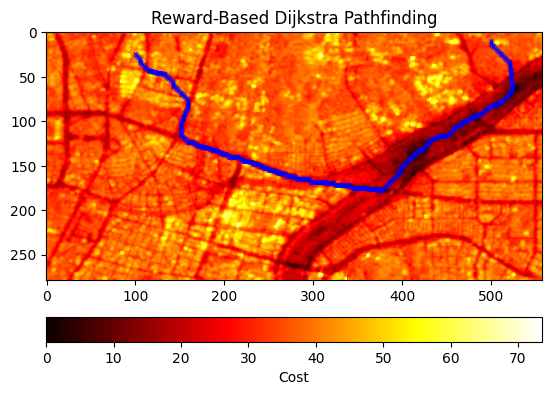

In [ ]:
# 히트맵 위에 경로 시각화
plt.imshow(final_heatmap, cmap='hot', origin='upper')
for (r, c) in path:
    plt.text(c, r, 'x', ha='center', va='center', color='blue', fontsize=6)
plt.title('Reward-Based Dijkstra Pathfinding')
plt.colorbar(label='Cost', orientation='horizontal', pad=0.1)
plt.show()

279
730
[(10, 500), (11, 500), (12, 500), (13, 500), (14, 501), (15, 502), (16, 503), (17, 504), (18, 505), (19, 506), (20, 507), (21, 508), (22, 509), (23, 510), (24, 511), (25, 512), (26, 513), (27, 514), (28, 515), (29, 516), (30, 517), (31, 518), (32, 519), (33, 520), (34, 521), (35, 522), (36, 522), (37, 522), (38, 522), (39, 522), (40, 522), (41, 522), (42, 523), (43, 523), (44, 523), (45, 523), (46, 523), (47, 523), (48, 523), (49, 523), (50, 523), (51, 523), (52, 523), (53, 523), (54, 523), (55, 523), (56, 523), (57, 524), (58, 524), (59, 525), (60, 525), (61, 525), (62, 525), (63, 524), (64, 523), (65, 523), (66, 523), (67, 523), (68, 522), (69, 521), (70, 520), (71, 519), (72, 518), (73, 517), (74, 516), (75, 515), (76, 514), (77, 513), (78, 512), (79, 511), (79, 510), (79, 509), (80, 508), (81, 507), (82, 506), (82, 505), (82, 504), (82, 503), (82, 502), (83, 501), (83, 500), (83, 499), (84, 498), (85, 497), (86, 496), (87, 495), (87, 494), (88, 493), (89, 492), (90, 491), (

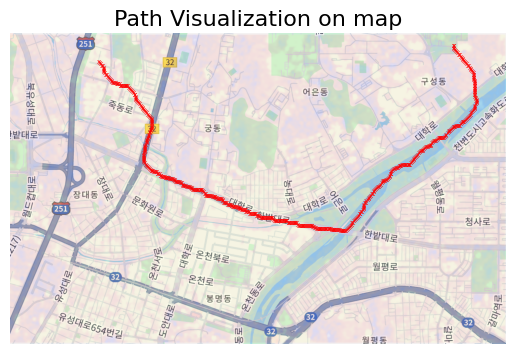

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 지도 이미지 로드
map_path = '/content/drive/My Drive/EarthEngineExports/map_final.png'
map = mpimg.imread(map_path)

# cost map 크기 가져오기
original_height, original_width = mask_heatmap.shape[:2]
print(original_height)
# 지도 이미지 크기 가져오기
img_height, img_width = map.shape[:2]
print(img_height)

# path 변환 (원본 좌표를 새로운 이미지 해상도에 맞게 스케일링)
img_path = [(int(r * img_height / original_height), int(c * img_width / original_width)) for r, c in path]
print(path)
print(img_path)

# 히트맵 이미지 설정
plt.imshow(map, origin='upper')
plt.axis('off')

for (r, c) in img_path:
    plt.text(c, r, 'x', ha='center', va='center', color='red', fontsize=5)

plt.title('Path Visualization on map', fontsize=16)
plt.show()


Width: 558, Height: 279
CRS: EPSG:4326
Transform: | 0.00, 0.00, 127.32|
| 0.00,-0.00, 36.38|
| 0.00, 0.00, 1.00|


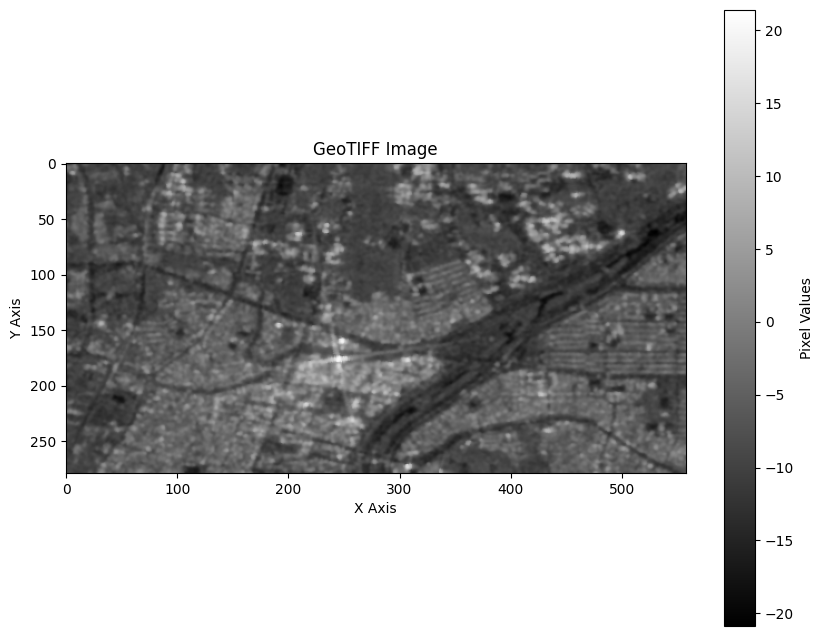

In [ ]:
import rasterio
import matplotlib.pyplot as plt

# GeoTIFF 파일 경로
file_path = '/content/drive/My Drive/EarthEngineExports/map_final.tif'

# GeoTIFF 파일 로드
with rasterio.open(file_path) as src:
    # 첫 번째 밴드 데이터 읽기
    tiff_data = src.read(1)  # 1번째 밴드

    # 해상도 및 데이터 정보 출력
    print(f"Width: {src.width}, Height: {src.height}")
    print(f"CRS: {src.crs}")
    print(f"Transform: {src.transform}")

# 이미지 시각화
plt.figure(figsize=(10, 8))
plt.title("GeoTIFF Image")
plt.imshow(tiff_data, cmap='gray')  # 흑백으로 표시
plt.colorbar(label="Pixel Values")
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.show()


## 강화학습

In [ ]:
import numpy as np
import random
from collections import deque
import tensorflow as tf

class Environment:
    def __init__(self, heatmap, start, goal):
        self.heatmap = heatmap
        self.start = start
        self.goal = goal
        self.state = start

    def reset(self):
        self.state = self.start
        return self.state

    def step(self, action):
        # 이동 방향 정의: 상, 하, 좌, 우
        d_row = [-1, 1, 0, 0]
        d_col = [0, 0, -1, 1]

        new_row = self.state[0] + d_row[action]
        new_col = self.state[1] + d_col[action]

        # 경계 조건 확인
        if not (0 <= new_row < self.heatmap.shape[0] and 0 <= new_col < self.heatmap.shape[1]):
            return self.state, -10, False  # 벽에 부딪히면 페널티

        self.state = (new_row, new_col)

        # 보상 정의
        if self.state == self.goal:
            return self.state, 100, True  # 목표 도달 시 높은 보상
        return self.state, -self.heatmap[new_row, new_col], False

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self._build_model()

    def _build_model(self):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(24, input_dim=self.state_size, activation='relu'),
            tf.keras.layers.Dense(24, activation='relu'),
            tf.keras.layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = np.reshape(state, [1, self.state_size])
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def train(self, state, action, reward, next_state, done):
        state = np.reshape(state, [1, self.state_size])
        next_state = np.reshape(next_state, [1, self.state_size])
        target = reward
        if not done:
            target += self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
        target_f = self.model.predict(state, verbose=0)
        target_f[0][action] = target
        self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [ ]:
# 시작점과 목표점
start = (20, 20)
goal = (90, 80)

env = Environment(reduced_heatmap, start, goal)
agent = DQNAgent(state_size=2, action_size=4)

# 학습
episodes = 500
rewards = []
for e in range(episodes):
    total_reward = 0
    state = np.array(env.reset())
    for time in range(200):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.train(state, action, reward, np.array(next_state), done)
        state = next_state
        total_reward += reward
        if done:
            break
    rewards.append(total_reward)
    print(f"Episode: {e+1}/{episodes}, Total Reward: {total_reward}")

# 학습 곡선 시각화
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.title('Reward Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 